<a href="https://colab.research.google.com/github/Unholy-Applepie/Bankruptcy-Prediction/blob/main/Bankruptcy_Custom_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix


# Importing the data

In [ ]:
#Input data csv
# Data uploaded in base folder, not '/content'
data = pd.read_csv('/data.csv')
print(data.shape)
#Taking first column "?Bankrupt" as the classifications
classifications = data.iloc[:, 0]
encoder = LabelEncoder()
y = encoder.fit_transform(classifications)
classification_name=np.unique(np.array(['Not Bankrupt', 'Bankrupt'])) # 0 = not bankrupt, 1 = bankrupt

#Taking all other columns as input features and scaling
X = data.iloc[:, 1:]
scaler = StandardScaler()
X=np.array(X)
X=scaler.fit_transform(X)

#Appending data scaled to classifications again (scaled after removing clasification as to not have classification be scaled or have an effect on scaling)
data_scaled=[]
for i in range(X.shape[0]):
    data_scaled.append([X[i],y[i]])

#Shuffling the data to get a balanced spread of classifications
import random
random.shuffle(data_scaled)

# Define the proportion of data for training and testing
train_percentage = 0.8  # 80% for training, 20% for testing
total_samples = len(data_scaled)
train_size = int(train_percentage * total_samples)

# Split the data into training and testing sets before applying any data augmentation (oversampling/undersampling) as to not polute the test data
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

#Splitting train data into X and y
X = []
y = []
for features, label in train_data:
    X.append(features)
    y.append(label)
X = np.array(X)
y = np.array(y)

#Splitting test data into X and y
X_test = []
y_test = []
for features, label in test_data:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(6819, 96)
(5455, 95)
(5455,)
(1364, 95)
(1364,)


# Imports for Neural networks and plotting

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Neural Networks

## Function to train neural networks with arbitary hyper parameters

In [ ]:
def train_model(X,y):

  #Using a Sequential model
  model = Sequential()

  #First densely connected neural network layer with 128 neurons, also take thes input of all the features
  model.add(Dense(128, input_shape=(X.shape[1],)))
  model.add(Dropout(0.15)) # Dropout as to not be too bias towards certain neurons
  model.add(Activation('relu')) # Arbitary activation relu

  #Second densely connected neural network layer with 64 neurons
  model.add(Dense(64))
  model.add(Dropout(0.15)) # Dropout as to not be too bias towards certain neurons
  model.add(Activation('relu'))  # Arbitary activation relu

  model.add(Dense(1)) # Output layer of 1 neuron
  model.add(Activation('sigmoid')) # gives us a value between 1 and 0 for classification

  # Checkpointing the best epoch so we can load it later after early stopping
  model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')
  # Early Stopping to conserved training time and prevent overfitting
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

  # Compiling the model with arbitary optimizer adam, binary_crossentropy as it is a binary classification problem and using metrics accuracy
  model.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

  #fitting the model with the X and y parrameters passed into the function
  # Batch size selected as 256 to speed up training time but too not be too large as to have lower accuracy
  # Epochs kept large (200) since early stopping will stop the training once there is no more improvement
  # using early stopping and model checkpoint callbacks
  model.fit(X, y,
            batch_size=256,
            epochs=200,
            validation_split=0.2,
            callbacks=[es,model_checkpoint])
  # loading the best weights after the model is done training
  model.load_weights('/content/best_model.h5')
  print("loaded")
  # returning the trained model
  return model

## Function to test model given in input for all features

In [ ]:
def test_model(model):
  #Tests

  #Evaluating the model on our test set
  loss, accuracy = model.evaluate(X_test, y_test)
  print("-"*30)
  print(f"Test loss: {loss:.4f}")
  print(f"Test accuracy: {accuracy:.4f}")

  # getting predicted labels as 1 if >0.5 and 0 if not >0.5
  # this can be changed according to the requirement of the client
  # if he wants higher classifications of bankrupts but does not mind more false positives can lower the value of which 1 is predicted (eg maybe 1 if >0.4)
  predicted_labels = (model.predict(X_test) > 0.5).astype(int).flatten()

  # Calculate the confusion matrix
  confusion = confusion_matrix(y_test, predicted_labels)

  # Extract the TP, TN, FP, and FN values
  TP = confusion[1, 1]  # True Positives
  TN = confusion[0, 0]  # True Negatives
  FP = confusion[0, 1]  # False Positives
  FN = confusion[1, 0]  # False Negatives

  print("-"*30)
  # plotting the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
              xticklabels=["Predicted 0", "Predicted 1"],
              yticklabels=["Actual 0", "Actual 1"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print("-"*30)
  # Calculate the percentages
  percentage_positive_predicted_correctly = (TP / (TP + FN)) * 100
  percentage_negative_predicted_correctly = (TN / (TN + FP)) * 100

  # Print or use these percentages as needed
  print(f"Percentage of positive (1) predicted correctly: {TP} / {TP+FN} = {percentage_positive_predicted_correctly:.2f}%")
  print(f"Percentage of negative (0) predicted correctly: {TN} / {TN+FP} = {percentage_negative_predicted_correctly:.2f}%")
  v1 = TP/(TP+FN)
  v2 = TN/(TN+FP)
  print("Classification Report:\n", classification_report(y_test, predicted_labels))
  # returning weighted average accuracy (Assmuing client values balance hence giving weight of 50-50 to each classification)
  return (v1+v2)/2

## Function to test model given in input for selected features of KBest

In [ ]:
def test_model_selected_features(model, feature_selection_KBest):
  # If model uses selected features, transform the X_test dataset to only have those selected features
  X_test_sf = feature_selection_KBest.transform(X_test)
  #Tests

  #Remaining test is same as test_model(model)
  loss, accuracy = model.evaluate(X_test_sf, y_test)
  print("-"*30)
  print(f"Test loss: {loss:.4f}")
  print(f"Test accuracy: {accuracy:.4f}")

  predicted_labels = (model.predict(X_test_sf) > 0.5).astype(int).flatten()

  # Calculate the confusion matrix
  confusion = confusion_matrix(y_test, predicted_labels)

  # Extract the TP, TN, FP, and FN values
  TP = confusion[1, 1]  # True Positives
  TN = confusion[0, 0]  # True Negatives
  FP = confusion[0, 1]  # False Positives
  FN = confusion[1, 0]  # False Negatives

  print("-"*30)
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
              xticklabels=["Predicted 0", "Predicted 1"],
              yticklabels=["Actual 0", "Actual 1"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print("-"*30)
  # Calculate the percentages
  percentage_positive_predicted_correctly = (TP / (TP + FN)) * 100
  percentage_negative_predicted_correctly = (TN / (TN + FP)) * 100

  # Print or use these percentages as needed
  print(f"Percentage of positive (1) predicted correctly: {TP} / {TP+FN} = {percentage_positive_predicted_correctly:.2f}%")
  print(f"Percentage of negative (0) predicted correctly: {TN} / {TN+FP} = {percentage_negative_predicted_correctly:.2f}%")
  v1 = TP/(TP+FN)
  v2 = TN/(TN+FP)
  print("Classification Report:\n", classification_report(y_test, predicted_labels))
  # returning weighted average accuracy (Assmuing client values balance hence giving weight of 50-50 to each classification)
  return (v1+v2)/2

## Not using any augmentation and training a model just to prove that it will perform very poorly without data sampling

In [ ]:
only_scaled_model = train_model(X,y)

Epoch 1/200
18/18 [==============================] - 1s 17ms/step - loss: 0.3168 - accuracy: 0.9480 - val_loss: 0.1491 - val_accuracy: 0.9688
Epoch 2/200
18/18 [==============================] - 0s 9ms/step - loss: 0.1602 - accuracy: 0.9709 - val_loss: 0.1106 - val_accuracy: 0.9688
Epoch 3/200
18/18 [==============================] - 0s 11ms/step - loss: 0.1233 - accuracy: 0.9704 - val_loss: 0.0996 - val_accuracy: 0.9698
Epoch 4/200
18/18 [==============================] - 0s 12ms/step - loss: 0.1048 - accuracy: 0.9707 - val_loss: 0.0968 - val_accuracy: 0.9679
Epoch 5/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0920 - accuracy: 0.9727 - val_loss: 0.0983 - val_accuracy: 0.9679
Epoch 6/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0843 - accuracy: 0.9718 - val_loss: 0.1007 - val_accuracy: 0.9679
Epoch 7/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0783 - accuracy: 0.9736 - val_loss: 0.1025 - val_accuracy: 0.9670
Epoch 7

43/43 [==============================] - 0s 6ms/step - loss: 0.1918 - accuracy: 0.9589
------------------------------
Test loss: 0.1918
Test accuracy: 0.9589
43/43 [==============================] - 0s 2ms/step
------------------------------


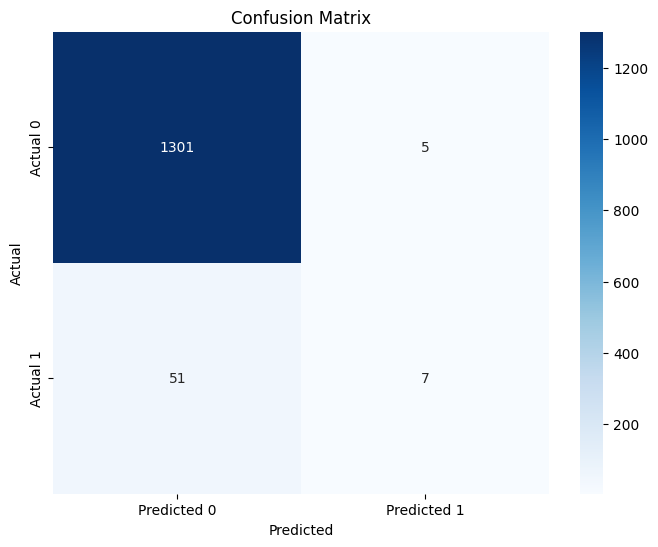

------------------------------
Percentage of positive (1) predicted correctly: 7 / 58 = 12.07%
Percentage of negative (0) predicted correctly: 1301 / 1306 = 99.62%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1306
           1       0.58      0.12      0.20        58

    accuracy                           0.96      1364
   macro avg       0.77      0.56      0.59      1364
weighted avg       0.95      0.96      0.95      1364



0.5584305856260231

In [ ]:
test_model(only_scaled_model)

As you can see it performs very poorly only classifying 7/58 (12.07%) of bankrupt cases correctly.

## Oversampling the Dataset

### Using SMOTE for oversampling the dataset

In [ ]:
#Importing and oversampling using smote
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_Smote,y_Smote=oversample.fit_resample(X,y)

# training the smote oversampled dataset
smote_model = train_model(X_Smote,y_Smote)

Epoch 1/200
34/34 [==============================] - 1s 12ms/step - loss: 0.4287 - accuracy: 0.8239 - val_loss: 0.3056 - val_accuracy: 0.8801
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.2595 - accuracy: 0.8953 - val_loss: 0.2969 - val_accuracy: 0.8735
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.2251 - accuracy: 0.9088 - val_loss: 0.2231 - val_accuracy: 0.9207
Epoch 4/200
34/34 [==============================] - 0s 6ms/step - loss: 0.1962 - accuracy: 0.9203 - val_loss: 0.2245 - val_accuracy: 0.9226
Epoch 5/200
34/34 [==============================] - 0s 7ms/step - loss: 0.1764 - accuracy: 0.9355 - val_loss: 0.1774 - val_accuracy: 0.9537
Epoch 6/200
34/34 [==============================] - 0s 7ms/step - loss: 0.1595 - accuracy: 0.9420 - val_loss: 0.1520 - val_accuracy: 0.9679
Epoch 7/200
34/34 [==============================] - 0s 7ms/step - loss: 0.1394 - accuracy: 0.9528 - val_loss: 0.1400 - val_accuracy: 0.9764
Epoch 8/200


43/43 [==============================] - 0s 2ms/step - loss: 0.9834 - accuracy: 0.9560
------------------------------
Test loss: 0.9834
Test accuracy: 0.9560
43/43 [==============================] - 0s 2ms/step
------------------------------


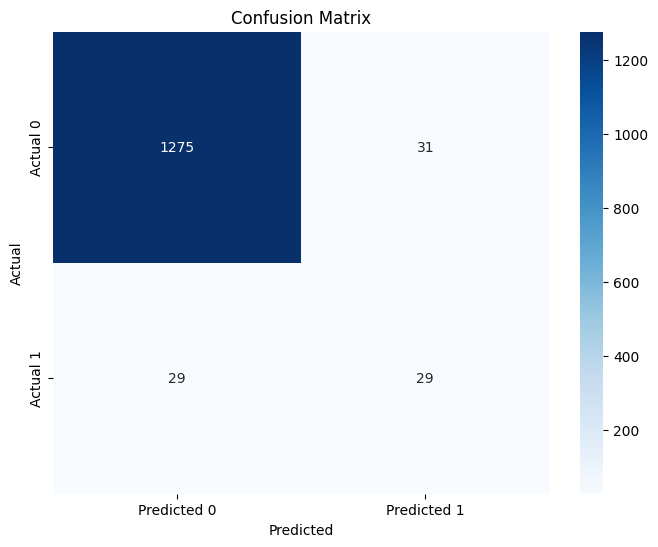

------------------------------
Percentage of positive (1) predicted correctly: 29 / 58 = 50.00%
Percentage of negative (0) predicted correctly: 1275 / 1306 = 97.63%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1306
           1       0.48      0.50      0.49        58

    accuracy                           0.96      1364
   macro avg       0.73      0.74      0.73      1364
weighted avg       0.96      0.96      0.96      1364



0.7381316998468607

In [ ]:
test_model(smote_model)

As you can see it performs much better than the model without oversampling classifying 29/58 (50%) of the bankrupt cases correctly

### Using Random Over Sampler for oversampling the dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_randomOver, y_randomOver = over_sampler.fit_resample(X , y)

randomOver_model = train_model(X_randomOver,y_randomOver)

Epoch 1/200
34/34 [==============================] - 2s 20ms/step - loss: 0.4644 - accuracy: 0.7850 - val_loss: 0.3312 - val_accuracy: 0.8744
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2991 - accuracy: 0.8731 - val_loss: 0.2723 - val_accuracy: 0.9065
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.2538 - accuracy: 0.8957 - val_loss: 0.2252 - val_accuracy: 0.9320
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 0.2226 - accuracy: 0.9079 - val_loss: 0.2408 - val_accuracy: 0.9320
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1977 - accuracy: 0.9225 - val_loss: 0.1800 - val_accuracy: 0.9504
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1765 - accuracy: 0.9327 - val_loss: 0.1579 - val_accuracy: 0.9618
Epoch 7/200
34/34 [==============================] - 0s 8ms/step - loss: 0.1641 - accuracy: 0.9382 - val_loss: 0.1099 - val_accuracy: 0.9896
Epoch 8/

43/43 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.9545
------------------------------
Test loss: 0.6069
Test accuracy: 0.9545
43/43 [==============================] - 0s 2ms/step
------------------------------


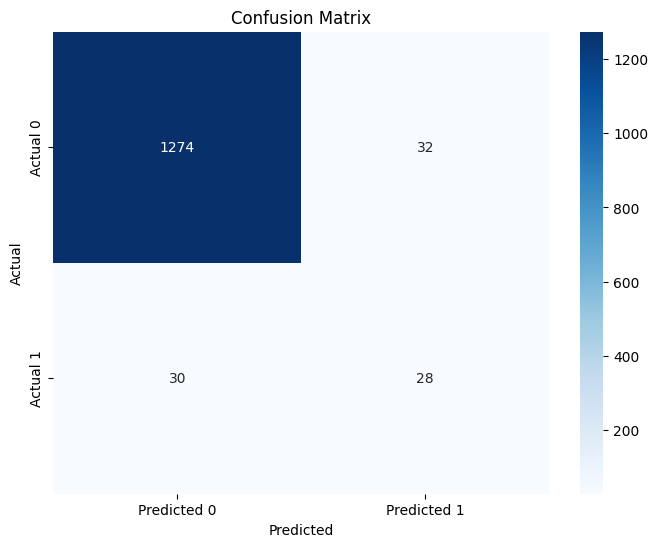

------------------------------
Percentage of positive (1) predicted correctly: 28 / 58 = 48.28%
Percentage of negative (0) predicted correctly: 1274 / 1306 = 97.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1306
           1       0.47      0.48      0.47        58

    accuracy                           0.95      1364
   macro avg       0.72      0.73      0.73      1364
weighted avg       0.96      0.95      0.95      1364



0.7291281617996515

In [ ]:
test_model(randomOver_model)

Performs better than no oversampling but worse then smote

### Using ADASYN for oversampling the dataset

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

adasyn_model = train_model(X_adasyn,y_adasyn)

Epoch 1/200
34/34 [==============================] - 2s 11ms/step - loss: 0.4087 - accuracy: 0.8275 - val_loss: 0.3584 - val_accuracy: 0.8381
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.2529 - accuracy: 0.9038 - val_loss: 0.3741 - val_accuracy: 0.8098
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.2100 - accuracy: 0.9203 - val_loss: 0.3526 - val_accuracy: 0.8216
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1852 - accuracy: 0.9310 - val_loss: 0.2602 - val_accuracy: 0.8872
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 0.1622 - accuracy: 0.9418 - val_loss: 0.3232 - val_accuracy: 0.8731
Epoch 6/200
34/34 [==============================] - 0s 9ms/step - loss: 0.1455 - accuracy: 0.9509 - val_loss: 0.2938 - val_accuracy: 0.9118
Epoch 7/200
34/34 [==============================] - 0s 10ms/step - loss: 0.1280 - accuracy: 0.9578 - val_loss: 0.3470 - val_accuracy: 0.8905
Epoch 7: 

43/43 [==============================] - 0s 3ms/step - loss: 0.2875 - accuracy: 0.9032
------------------------------
Test loss: 0.2875
Test accuracy: 0.9032
43/43 [==============================] - 0s 3ms/step
------------------------------


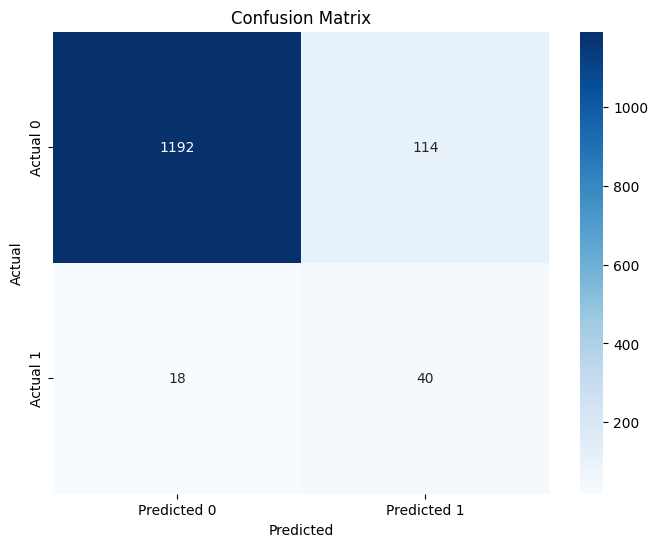

------------------------------
Percentage of positive (1) predicted correctly: 40 / 58 = 68.97%
Percentage of negative (0) predicted correctly: 1192 / 1306 = 91.27%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1306
           1       0.26      0.69      0.38        58

    accuracy                           0.90      1364
   macro avg       0.62      0.80      0.66      1364
weighted avg       0.95      0.90      0.92      1364



0.8011828695147067

In [ ]:
test_model(adasyn_model)

Performs much more balanced than Smote or Random over sampling.
Assuming the client has balance as high priority this is the best model.

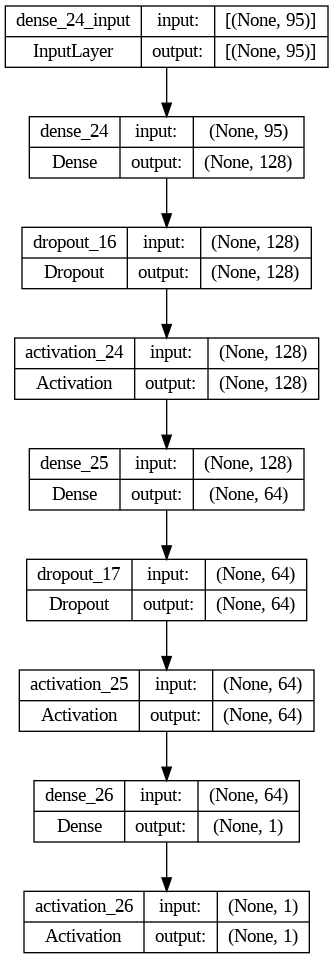

In [ ]:
# Plotting the model to show the layers
from tensorflow.keras.utils import plot_model
plot_model(adasyn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


## Undersampling the Dataset

### Using RandomUnderSampler for undersampling the dataset

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_randomUnder, y_randomUnder = rus.fit_resample(X, y)

randomUnder_model = train_model(X_randomUnder,y_randomUnder)

Epoch 1/200
2/2 [==============================] - 1s 233ms/step - loss: 0.7988 - accuracy: 0.4402 - val_loss: 0.4061 - val_accuracy: 0.9692
Epoch 2/200
2/2 [==============================] - 0s 52ms/step - loss: 0.6948 - accuracy: 0.4942 - val_loss: 0.3945 - val_accuracy: 0.9538
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: 0.6387 - accuracy: 0.6371 - val_loss: 0.4131 - val_accuracy: 0.9385
Epoch 4/200
2/2 [==============================] - 0s 36ms/step - loss: 0.5645 - accuracy: 0.7645 - val_loss: 0.4240 - val_accuracy: 0.9077
Epoch 5/200
2/2 [==============================] - 0s 53ms/step - loss: 0.5328 - accuracy: 0.7876 - val_loss: 0.4169 - val_accuracy: 0.9077
Epoch 5: early stopping
loaded


43/43 [==============================] - 0s 3ms/step - loss: 0.7657 - accuracy: 0.4479
------------------------------
Test loss: 0.7657
Test accuracy: 0.4479
43/43 [==============================] - 0s 2ms/step
------------------------------


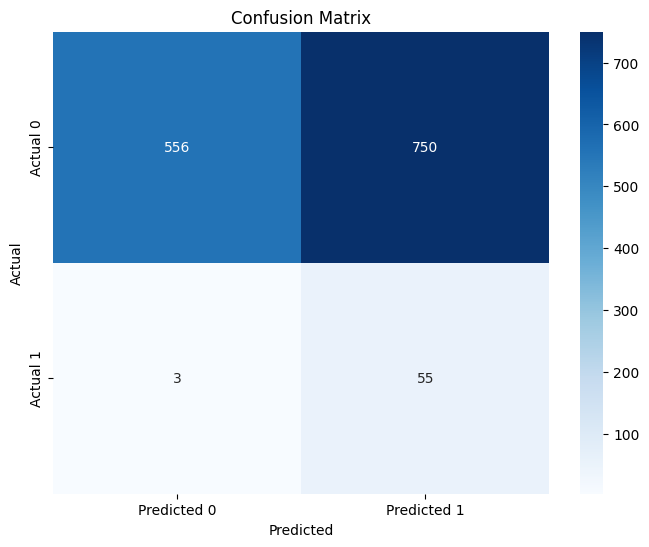

------------------------------
Percentage of positive (1) predicted correctly: 55 / 58 = 94.83%
Percentage of negative (0) predicted correctly: 556 / 1306 = 42.57%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.43      0.60      1306
           1       0.07      0.95      0.13        58

    accuracy                           0.45      1364
   macro avg       0.53      0.69      0.36      1364
weighted avg       0.96      0.45      0.58      1364



0.6870016370069176

In [ ]:
test_model(randomUnder_model)

As you can see, undersampling performs really well to classify bankrupt cases as it has the full data for bankrupt class.
However, when undersampling, it loses a lot of data for the not bankrupt class hence it performs really badly for classifying not bankrupt, i.e. predicts a very large number of false positives.

### Using EditedNearestNeighbours for undersampling the dataset

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='auto',n_neighbors=200)
X_enn, y_enn = enn.fit_resample(X, y)

enn_model = train_model(X_enn,y_enn)

Epoch 1/200
8/8 [==============================] - 1s 36ms/step - loss: 0.4831 - accuracy: 0.8007 - val_loss: 0.6397 - val_accuracy: 0.6877
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.1271 - accuracy: 1.0000 - val_loss: 0.8563 - val_accuracy: 0.6798
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0451 - accuracy: 1.0000 - val_loss: 1.1072 - val_accuracy: 0.6798
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 1.3284 - val_accuracy: 0.6798
Epoch 4: early stopping
loaded


43/43 [==============================] - 0s 2ms/step - loss: 0.3443 - accuracy: 0.9575
------------------------------
Test loss: 0.3443
Test accuracy: 0.9575
43/43 [==============================] - 0s 2ms/step
------------------------------


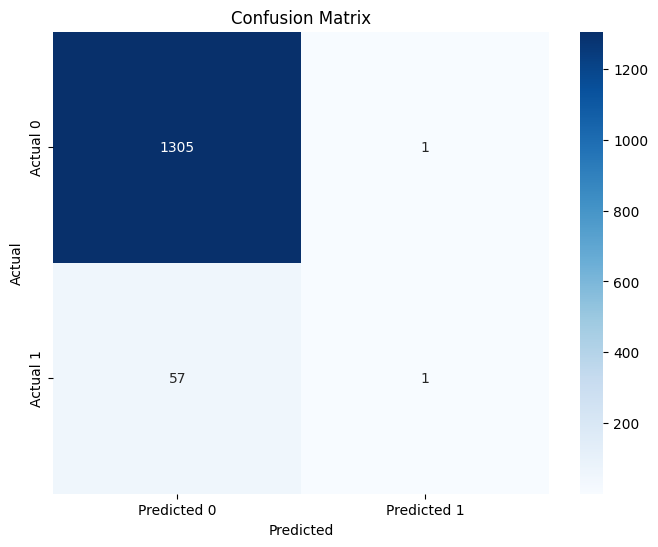

------------------------------
Percentage of positive (1) predicted correctly: 1 / 58 = 1.72%
Percentage of negative (0) predicted correctly: 1305 / 1306 = 99.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1306
           1       0.50      0.02      0.03        58

    accuracy                           0.96      1364
   macro avg       0.73      0.51      0.51      1364
weighted avg       0.94      0.96      0.94      1364



0.5082378412631356

In [ ]:
test_model(enn_model)

ENN performs horendously for classifying bankrupt, even though it is undersampled. We can theorise that this can be attributed to the technique of undersampling used and that the neural network does not perform well when this type of undersampling is used

# Implementing methods to try and improve the Neural Network

Using Adasyn as it performs the most balanced and we are assuming that the client highly values balance.

## Feature Selection using KBest

In [ ]:
# Importing the KBest and using KBest algorithm to select the 13 best features
from sklearn.feature_selection import f_classif, SelectKBest
feature_selection_KBest=SelectKBest(f_classif,k=13).fit(X_adasyn,y_adasyn)

In [ ]:
# To get the selected feature names
selected_features_mask = feature_selection_KBest.get_support()
data_features = data.iloc[:, 1:]
selected_features_df = data_features[data_features.columns[selected_features_mask]]

In [ ]:
print("Selected Feature Names:")
i=0
for feature_name in selected_features_df.columns:
  i+=1
  print(f'Feature {i}: {feature_name}')

Selected Feature Names:
Feature 1:  ROA(C) before interest and depreciation before interest
Feature 2:  ROA(A) before interest and % after tax
Feature 3:  ROA(B) before interest and depreciation after tax
Feature 4:  Net Value Per Share (B)
Feature 5:  Net Value Per Share (A)
Feature 6:  Net Value Per Share (C)
Feature 7:  Persistent EPS in the Last Four Seasons
Feature 8:  Per Share Net profit before tax (Yuan ¥)
Feature 9:  Debt ratio %
Feature 10:  Net worth/Assets
Feature 11:  Net profit before tax/Paid-in capital
Feature 12:  Working Capital to Total Assets
Feature 13:  Net Income to Total Assets


In [ ]:
# Transforming the X_adasyn to only contain selected features
X_selected = feature_selection_KBest.transform(X_adasyn)

In [ ]:
# Fitting the model with selected features
adasyn_and_fs_model = train_model(X_selected,y_adasyn)

Epoch 1/200
34/34 [==============================] - 2s 20ms/step - loss: 0.4572 - accuracy: 0.8048 - val_loss: 0.3870 - val_accuracy: 0.8372
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3377 - accuracy: 0.8598 - val_loss: 0.4275 - val_accuracy: 0.8008
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3159 - accuracy: 0.8675 - val_loss: 0.3653 - val_accuracy: 0.8419
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3057 - accuracy: 0.8728 - val_loss: 0.4464 - val_accuracy: 0.8150
Epoch 5/200
34/34 [==============================] - 0s 9ms/step - loss: 0.2976 - accuracy: 0.8764 - val_loss: 0.4338 - val_accuracy: 0.8263
Epoch 6/200
34/34 [==============================] - 0s 7ms/step - loss: 0.2897 - accuracy: 0.8801 - val_loss: 0.4686 - val_accuracy: 0.8160
Epoch 6: early stopping
loaded


43/43 [==============================] - 0s 2ms/step - loss: 0.3309 - accuracy: 0.8570
------------------------------
Test loss: 0.3309
Test accuracy: 0.8570
43/43 [==============================] - 0s 2ms/step
------------------------------


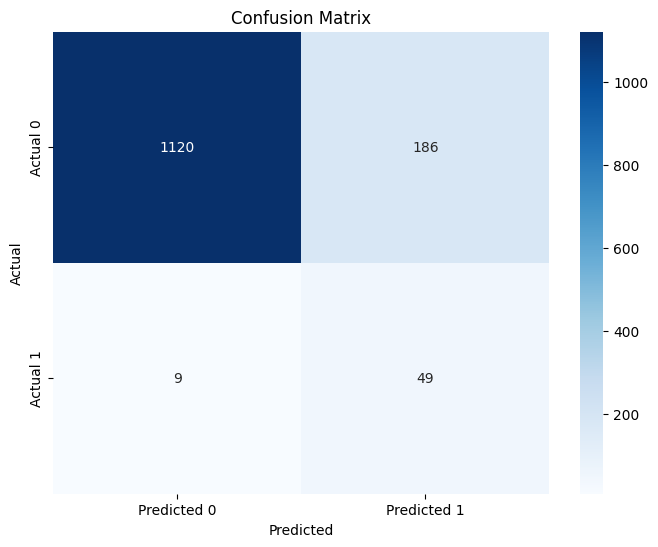

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1120 / 1306 = 85.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.84      0.33        58

    accuracy                           0.86      1364
   macro avg       0.60      0.85      0.63      1364
weighted avg       0.96      0.86      0.90      1364



0.8512039921846122

In [ ]:
test_model_selected_features(adasyn_and_fs_model, feature_selection_KBest)

As you can see the performance of the model (balance) improves with KBest feature selection

## Hyper Parameter Tuning

#### Using Keras Tuner

In [ ]:
#Installing as colab does not have it pre installed
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

#Defining the model and hyperparameters to test
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_selected.shape[1],)))  # Input layer

    # Determine the number of hidden layers
    # Searching between 1 to 3 layers
    for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=3)):
        # Determine the number of units in each hidden layer
        # Searching between 32 to 128 neurons
        # step of 32
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                              activation=hp.Choice('activation_' + str(i), values=['relu'])))
        # Add dropout with a tunable rate
        # Searching between 0 to 0.2 with step of 0.05
        model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.2, step=0.05)))

    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=40,  # Number of combinations to try
    directory='keras_tuner_results',  # Directory to store results
    project_name='my_model_tuned_1')

# Start the search
tuner.search(X_selected, y_adasyn,
             epochs=10,  # Number of epochs to run for search
             validation_split=0.2)

# Get the best model and hyperparameters
best_model_tuned = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print("Best Hyperparameters: ")
print(best_hyperparameters.values)

model_checkpoint = ModelCheckpoint('best_model_tuned.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fitting to tuned model
best_model_tuned.fit(X_selected, y_adasyn,
          batch_size=256,
          epochs=200,
          validation_split=0.2,
          callbacks=[es,model_checkpoint])
best_model_tuned.load_weights('/content/best_model_tuned.h5')
print("loaded")

Trial 40 Complete [00h 00m 11s]
val_accuracy: 0.8253893256187439

Best val_accuracy So Far: 0.8975932002067566
Total elapsed time: 00h 09m 56s
Best Hyperparameters: 
{'num_hidden_layers': 3, 'units_0': 64, 'activation_0': 'relu', 'dropout_0': 0.0, 'units_1': 64, 'activation_1': 'relu', 'dropout_1': 0.05, 'units_2': 32, 'activation_2': 'relu', 'dropout_2': 0.1}
Epoch 1/200
34/34 [==============================] - 1s 13ms/step - loss: 0.2041 - accuracy: 0.9187 - val_loss: 0.6342 - val_accuracy: 0.7697
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.1947 - accuracy: 0.9244 - val_loss: 0.5873 - val_accuracy: 0.7990
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.1933 - accuracy: 0.9274 - val_loss: 0.4977 - val_accuracy: 0.8466
Epoch 4/200
34/34 [==============================] - 0s 5ms/step - loss: 0.1909 - accuracy: 0.9260 - val_loss: 0.5840 - val_accuracy: 0.8042
Epoch 5/200
34/34 [==============================] - 0s 5ms/step - loss:

43/43 [==============================] - 0s 2ms/step - loss: 0.2844 - accuracy: 0.8856
------------------------------
Test loss: 0.2844
Test accuracy: 0.8856
43/43 [==============================] - 0s 2ms/step
------------------------------


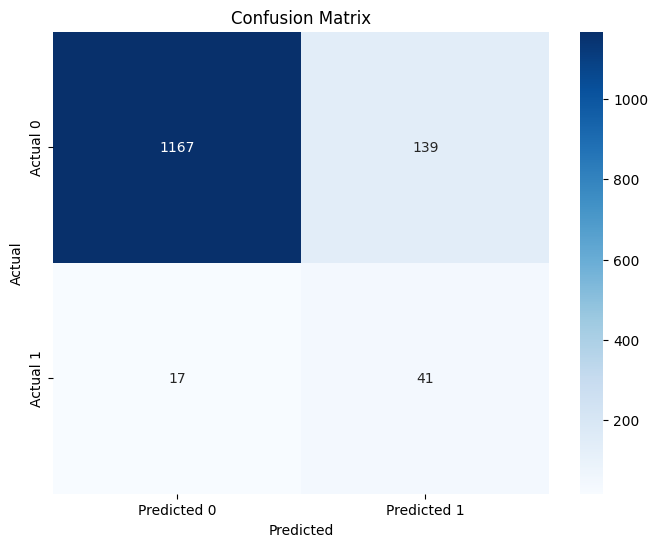

------------------------------
Percentage of positive (1) predicted correctly: 41 / 58 = 70.69%
Percentage of negative (0) predicted correctly: 1167 / 1306 = 89.36%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      1306
           1       0.23      0.71      0.34        58

    accuracy                           0.89      1364
   macro avg       0.61      0.80      0.64      1364
weighted avg       0.95      0.89      0.91      1364



0.8002323493689603

In [ ]:
test_model_selected_features(best_model_tuned,feature_selection_KBest)

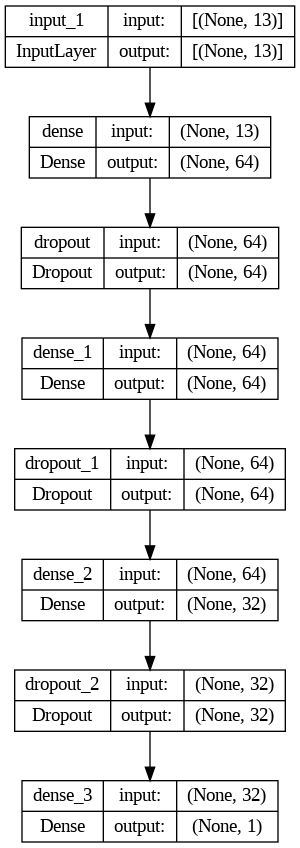

In [ ]:
plot_model(best_model_tuned, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

As you can see the model does not perform better than the arbitarily selected hyper parameters. This shows to us that the hyper-parameters selected are close to being optimal.

However let us also try some manual hyper parameter selections using for loops and permutations

#### Manual hyper parameter tuning

FEA_EXT_DENSE_2Layers_32Size_0.15DO_1698265270
Epoch 1/200
34/34 [==============================] - 2s 48ms/step - loss: 0.5747 - accuracy: 0.7156 - val_loss: 0.3575 - val_accuracy: 0.9264
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.4092 - accuracy: 0.8440 - val_loss: 0.3741 - val_accuracy: 0.8523
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3561 - accuracy: 0.8590 - val_loss: 0.3858 - val_accuracy: 0.8131
Epoch 4/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3337 - accuracy: 0.8650 - val_loss: 0.3837 - val_accuracy: 0.8155
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.8685 - val_loss: 0.3962 - val_accuracy: 0.8141
Epoch 5: early stopping
loaded
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                448    

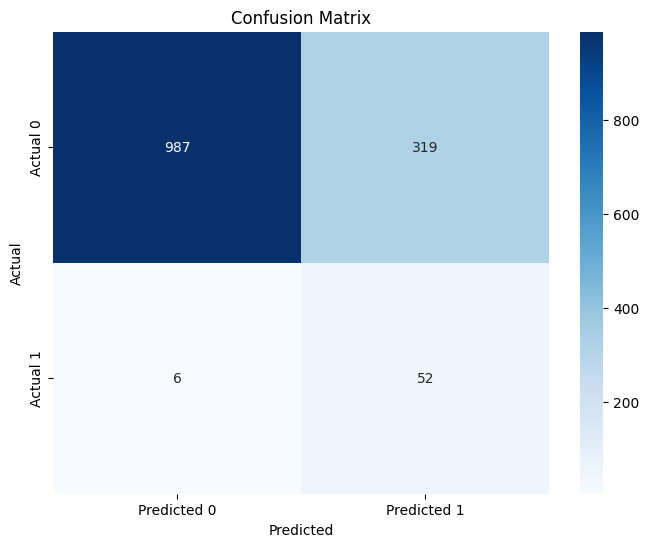

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 987 / 1306 = 75.57%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86      1306
           1       0.14      0.90      0.24        58

    accuracy                           0.76      1364
   macro avg       0.57      0.83      0.55      1364
weighted avg       0.96      0.76      0.83      1364

FEA_EXT_DENSE_2Layers_32Size_0.1DO_1698265275
Epoch 1/200
34/34 [==============================] - 2s 34ms/step - loss: 0.5119 - accuracy: 0.7741 - val_loss: 0.3949 - val_accuracy: 0.8915
Epoch 2/200
34/34 [==============================] - 1s 30ms/step - loss: 0.3813 - accuracy: 0.8408 - val_loss: 0.3542 - val_accuracy: 0.8613
Epoch 3/200
34/34 [==============================] - 1s 29ms/step - loss: 0.3457 - accuracy: 0.8528 - val_loss: 0.3452 - val_accuracy: 0.8504
Epoch 4/200
3

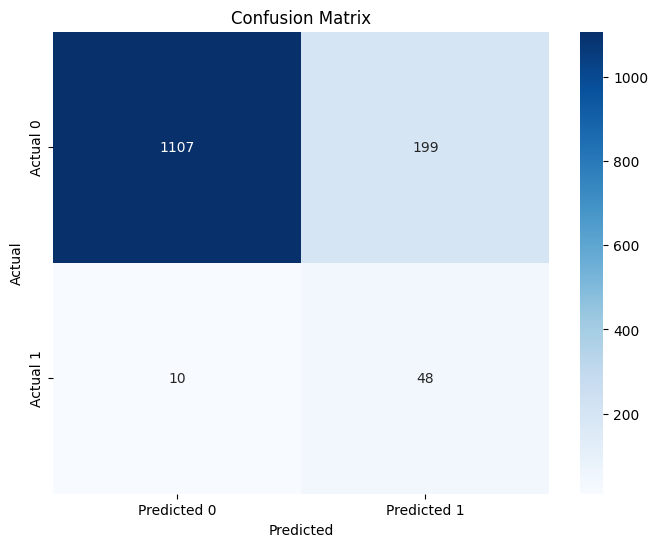

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1107 / 1306 = 84.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.19      0.83      0.31        58

    accuracy                           0.85      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_2Layers_32Size_0.2DO_1698265282
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5845 - accuracy: 0.7102 - val_loss: 0.3496 - val_accuracy: 0.9226
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 0.4099 - accuracy: 0.8342 - val_loss: 0.3906 - val_accuracy: 0.8207
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3618 - accuracy: 0.8458 - val_loss: 0.3737 - val_accuracy: 0.8287
Epoch 4/200
34

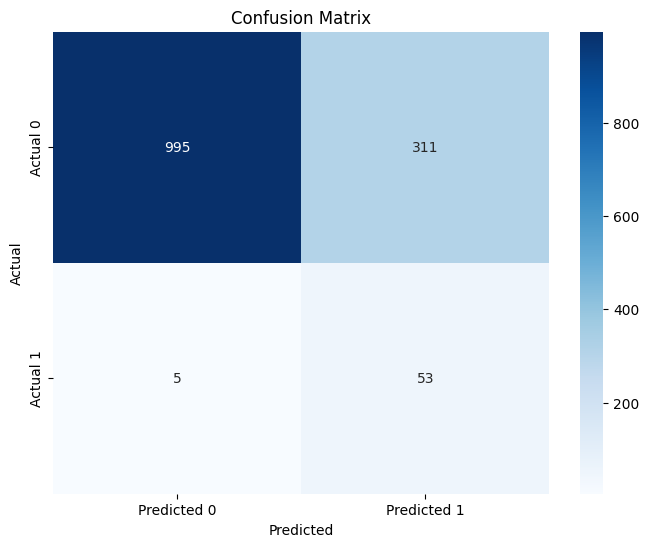

------------------------------
Percentage of positive (1) predicted correctly: 53 / 58 = 91.38%
Percentage of negative (0) predicted correctly: 995 / 1306 = 76.19%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86      1306
           1       0.15      0.91      0.25        58

    accuracy                           0.77      1364
   macro avg       0.57      0.84      0.56      1364
weighted avg       0.96      0.77      0.84      1364

FEA_EXT_DENSE_2Layers_32Size_0.15DO_1698265287
Epoch 1/200
34/34 [==============================] - 2s 38ms/step - loss: 0.4927 - accuracy: 0.7977 - val_loss: 0.3520 - val_accuracy: 0.9259
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3687 - accuracy: 0.8563 - val_loss: 0.3901 - val_accuracy: 0.8202
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3358 - accuracy: 0.8618 - val_loss: 0.4276 - val_accuracy: 0.8013
Epoch 4/200
34

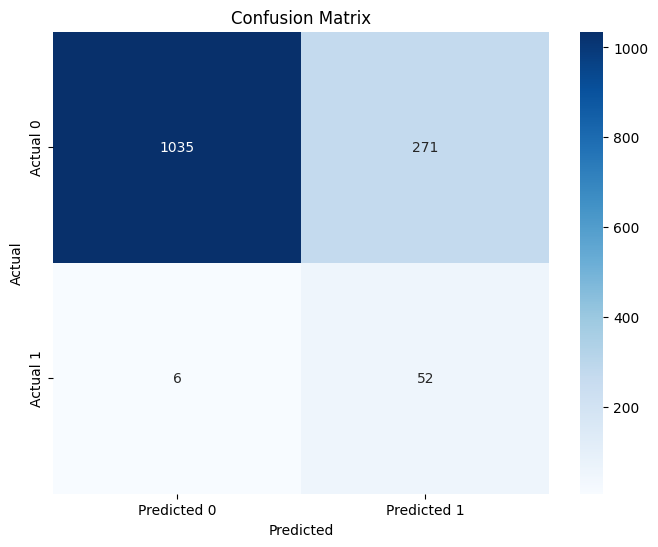

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 1035 / 1306 = 79.25%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      1306
           1       0.16      0.90      0.27        58

    accuracy                           0.80      1364
   macro avg       0.58      0.84      0.58      1364
weighted avg       0.96      0.80      0.86      1364

FEA_EXT_DENSE_2Layers_32Size_0.1DO_1698265291
Epoch 1/200
34/34 [==============================] - 2s 36ms/step - loss: 0.4972 - accuracy: 0.7931 - val_loss: 0.3779 - val_accuracy: 0.8820
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3657 - accuracy: 0.8435 - val_loss: 0.3881 - val_accuracy: 0.8169
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3384 - accuracy: 0.8595 - val_loss: 0.4138 - val_accuracy: 0.8136
Epoch 4/200
34

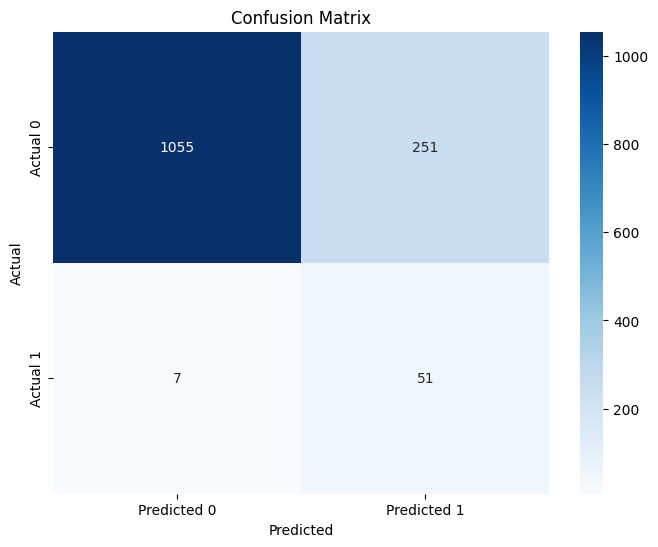

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1055 / 1306 = 80.78%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.28        58

    accuracy                           0.81      1364
   macro avg       0.58      0.84      0.59      1364
weighted avg       0.96      0.81      0.87      1364

FEA_EXT_DENSE_2Layers_32Size_0.2DO_1698265296
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5728 - accuracy: 0.7313 - val_loss: 0.3572 - val_accuracy: 0.9198
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.4010 - accuracy: 0.8408 - val_loss: 0.3729 - val_accuracy: 0.8339
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3452 - accuracy: 0.8565 - val_loss: 0.4226 - val_accuracy: 0.8070
Epoch 4/200
34

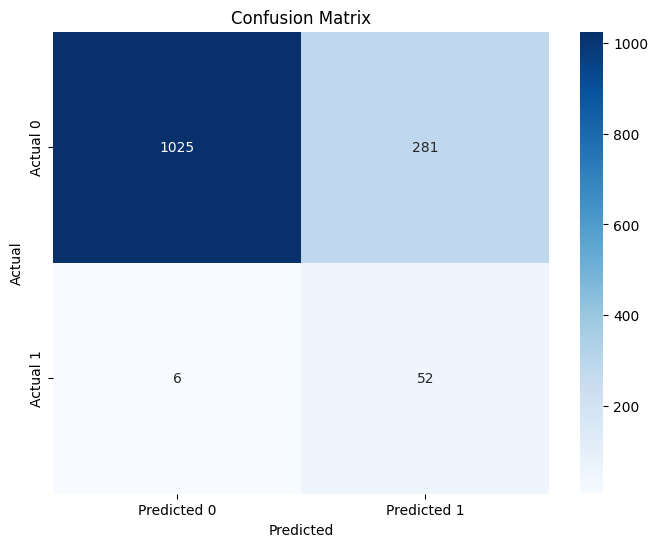

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 1025 / 1306 = 78.48%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.88      1306
           1       0.16      0.90      0.27        58

    accuracy                           0.79      1364
   macro avg       0.58      0.84      0.57      1364
weighted avg       0.96      0.79      0.85      1364

FEA_EXT_DENSE_2Layers_32Size_0.15DO_1698265300
Epoch 1/200
34/34 [==============================] - 3s 41ms/step - loss: 0.5351 - accuracy: 0.7444 - val_loss: 0.3903 - val_accuracy: 0.8943
Epoch 2/200
27/34 [======================>.......] - ETA: 0s - loss: 0.3844 - accuracy: 0.8413

34/34 [==============================] - 2s 67ms/step - loss: 0.3829 - accuracy: 0.8401 - val_loss: 0.3719 - val_accuracy: 0.8395
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3425 - accuracy: 0.8573 - val_loss: 0.3891 - val_accuracy: 0.8315
Epoch 4/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3324 - accuracy: 0.8587 - val_loss: 0.4386 - val_accuracy: 0.8126
Epoch 5/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3224 - accuracy: 0.8645 - val_loss: 0.4272 - val_accuracy: 0.8235
Epoch 6/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3159 - accuracy: 0.8695 - val_loss: 0.4378 - val_accuracy: 0.8183
Epoch 6: early stopping
loaded
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 32)                448       
                                                       

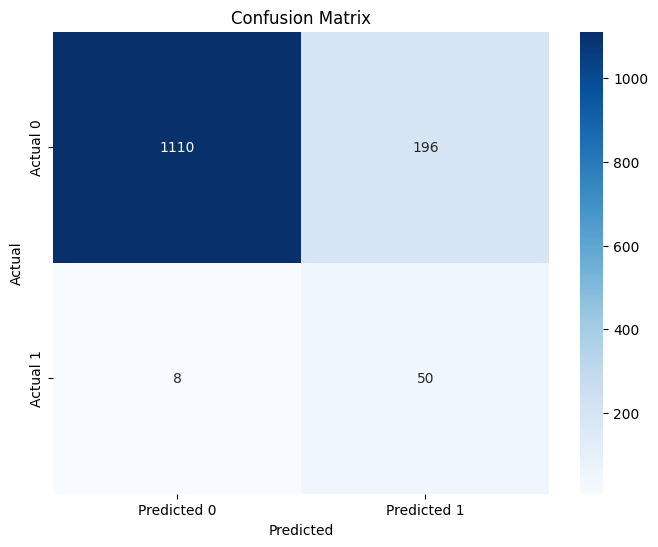

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1110 / 1306 = 84.99%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.86      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_2Layers_32Size_0.1DO_1698265307
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5266 - accuracy: 0.7489 - val_loss: 0.3855 - val_accuracy: 0.8664
Epoch 2/200
34/34 [==============================] - 1s 32ms/step - loss: 0.3675 - accuracy: 0.8538 - val_loss: 0.3768 - val_accuracy: 0.8344
Epoch 3/200
34/34 [==============================] - 1s 32ms/step - loss: 0.3348 - accuracy: 0.8629 - val_loss: 0.3683 - val_accuracy: 0.8372
Epoch 4/200


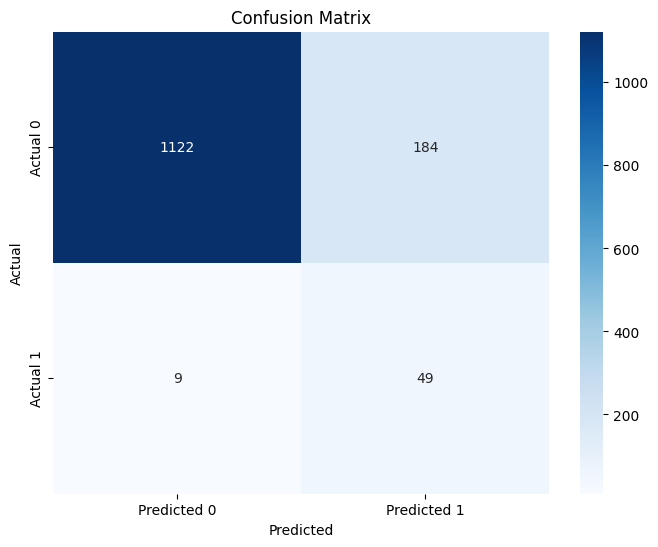

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1122 / 1306 = 85.91%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.84      0.34        58

    accuracy                           0.86      1364
   macro avg       0.60      0.85      0.63      1364
weighted avg       0.96      0.86      0.90      1364

FEA_EXT_DENSE_2Layers_32Size_0.2DO_1698265316
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.4554 - accuracy: 0.8111 - val_loss: 0.3792 - val_accuracy: 0.8674
Epoch 2/200
34/34 [==============================] - 1s 31ms/step - loss: 0.3525 - accuracy: 0.8540 - val_loss: 0.3786 - val_accuracy: 0.8273
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3287 - accuracy: 0.8593 - val_loss: 0.4036 - val_accuracy: 0.8202
Epoch 4/200
3

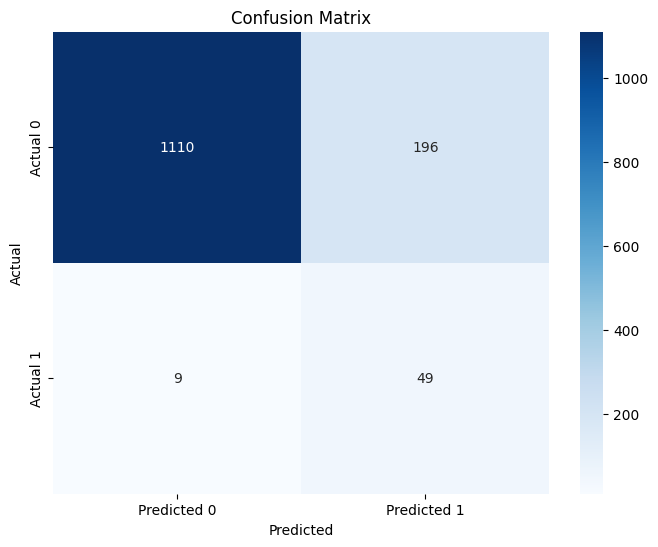

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1110 / 1306 = 84.99%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.84      0.32        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_2Layers_64Size_0.15DO_1698265323
Epoch 1/200
34/34 [==============================] - 3s 57ms/step - loss: 0.4862 - accuracy: 0.7990 - val_loss: 0.3662 - val_accuracy: 0.9037
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3659 - accuracy: 0.8473 - val_loss: 0.3671 - val_accuracy: 0.8329
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3351 - accuracy: 0.8572 - val_loss: 0.4031 - val_accuracy: 0.8221
Epoch 4/200
3

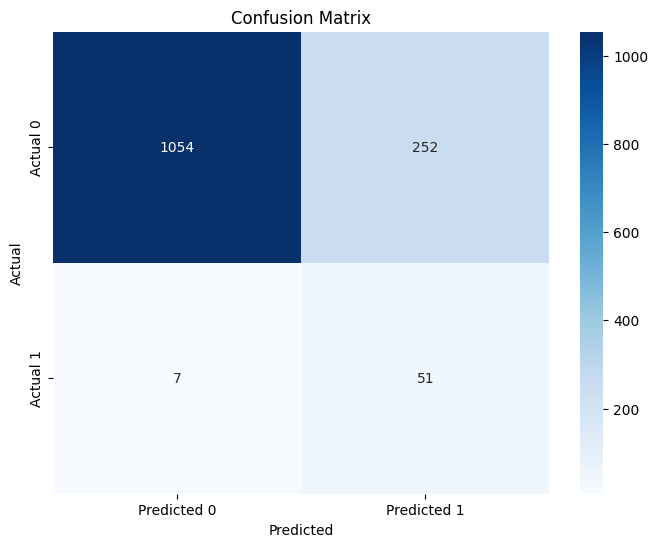

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1054 / 1306 = 80.70%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.28        58

    accuracy                           0.81      1364
   macro avg       0.58      0.84      0.59      1364
weighted avg       0.96      0.81      0.86      1364

FEA_EXT_DENSE_2Layers_64Size_0.1DO_1698265330
Epoch 1/200
34/34 [==============================] - 2s 36ms/step - loss: 0.5021 - accuracy: 0.7864 - val_loss: 0.3782 - val_accuracy: 0.8778
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3724 - accuracy: 0.8472 - val_loss: 0.3889 - val_accuracy: 0.8108
Epoch 3/200
34/34 [==============================] - 1s 31ms/step - loss: 0.3375 - accuracy: 0.8611 - val_loss: 0.3705 - val_accuracy: 0.8178
Epoch 4/200
3

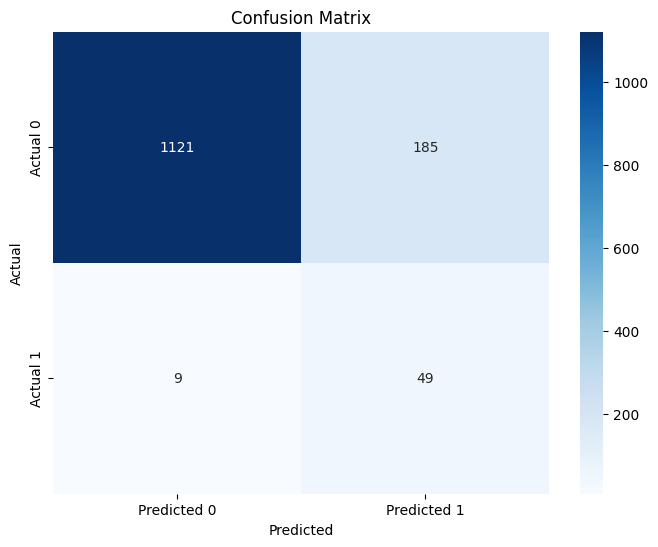

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1121 / 1306 = 85.83%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.84      0.34        58

    accuracy                           0.86      1364
   macro avg       0.60      0.85      0.63      1364
weighted avg       0.96      0.86      0.90      1364

FEA_EXT_DENSE_2Layers_64Size_0.2DO_1698265335
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5017 - accuracy: 0.7917 - val_loss: 0.3891 - val_accuracy: 0.8929
Epoch 2/200
34/34 [==============================] - 1s 30ms/step - loss: 0.3750 - accuracy: 0.8512 - val_loss: 0.3758 - val_accuracy: 0.8244
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3378 - accuracy: 0.8612 - val_loss: 0.3969 - val_accuracy: 0.8160
Epoch 4/200
3

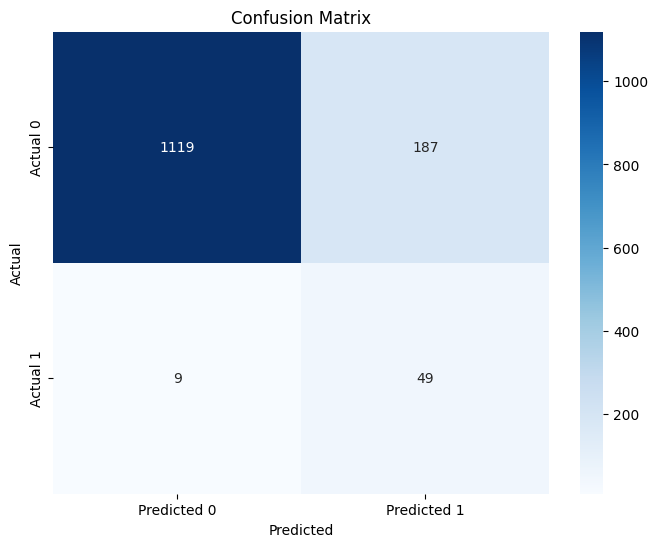

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1119 / 1306 = 85.68%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.84      0.33        58

    accuracy                           0.86      1364
   macro avg       0.60      0.85      0.63      1364
weighted avg       0.96      0.86      0.89      1364

FEA_EXT_DENSE_2Layers_64Size_0.15DO_1698265341
Epoch 1/200
34/34 [==============================] - 3s 38ms/step - loss: 0.4831 - accuracy: 0.8001 - val_loss: 0.3505 - val_accuracy: 0.8933
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3455 - accuracy: 0.8631 - val_loss: 0.4350 - val_accuracy: 0.7909
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3186 - accuracy: 0.8689 - val_loss: 0.4797 - val_accuracy: 0.7796
Epoch 4/200
3

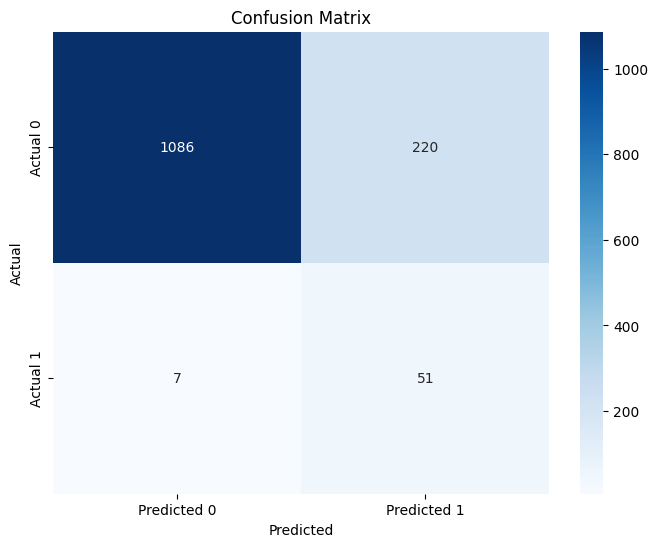

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1086 / 1306 = 83.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.88      0.31        58

    accuracy                           0.83      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_2Layers_64Size_0.1DO_1698265345
Epoch 1/200
27/34 [======================>.......] - ETA: 0s - loss: 0.4710 - accuracy: 0.8199

34/34 [==============================] - 3s 74ms/step - loss: 0.4530 - accuracy: 0.8259 - val_loss: 0.3947 - val_accuracy: 0.8306
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3359 - accuracy: 0.8618 - val_loss: 0.4624 - val_accuracy: 0.7796
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3144 - accuracy: 0.8701 - val_loss: 0.4194 - val_accuracy: 0.8112
Epoch 4/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3032 - accuracy: 0.8724 - val_loss: 0.4797 - val_accuracy: 0.7900
Epoch 5/200
34/34 [==============================] - 0s 7ms/step - loss: 0.2956 - accuracy: 0.8786 - val_loss: 0.4674 - val_accuracy: 0.8056
Epoch 5: early stopping
loaded
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 64)                896       
                                                      

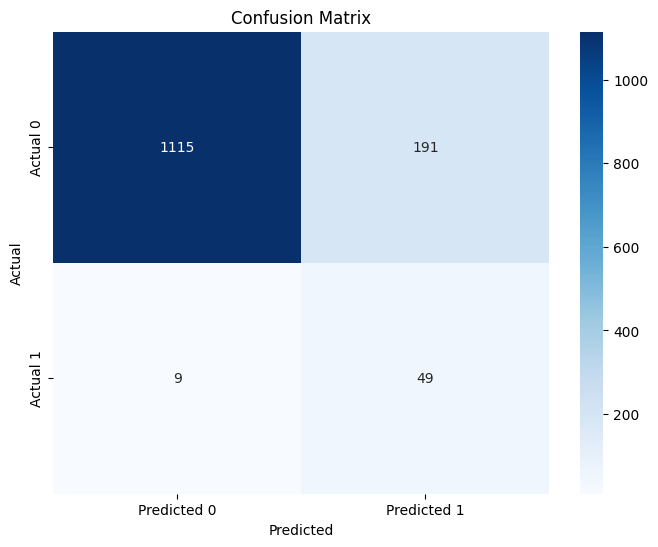

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1115 / 1306 = 85.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.84      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_2Layers_64Size_0.2DO_1698265353
Epoch 1/200
34/34 [==============================] - 3s 49ms/step - loss: 0.4764 - accuracy: 0.7995 - val_loss: 0.3471 - val_accuracy: 0.8622
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3541 - accuracy: 0.8528 - val_loss: 0.4221 - val_accuracy: 0.7829
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3324 - accuracy: 0.8644 - val_loss: 0.3881 - val_accuracy: 0.8221
Epoch 4/200
34

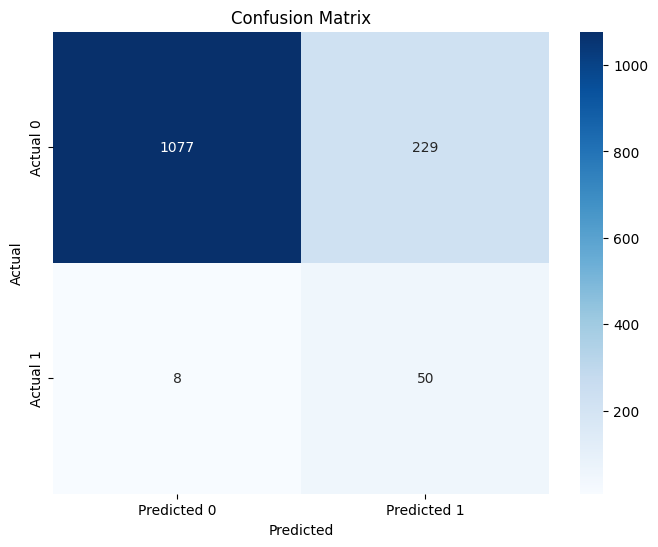

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1077 / 1306 = 82.47%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.86      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.84      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_2Layers_64Size_0.15DO_1698265358
Epoch 1/200
34/34 [==============================] - 2s 38ms/step - loss: 0.4912 - accuracy: 0.7807 - val_loss: 0.3654 - val_accuracy: 0.8679
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3442 - accuracy: 0.8589 - val_loss: 0.4463 - val_accuracy: 0.7928
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3245 - accuracy: 0.8642 - val_loss: 0.3724 - val_accuracy: 0.8334
Epoch 4/200
3

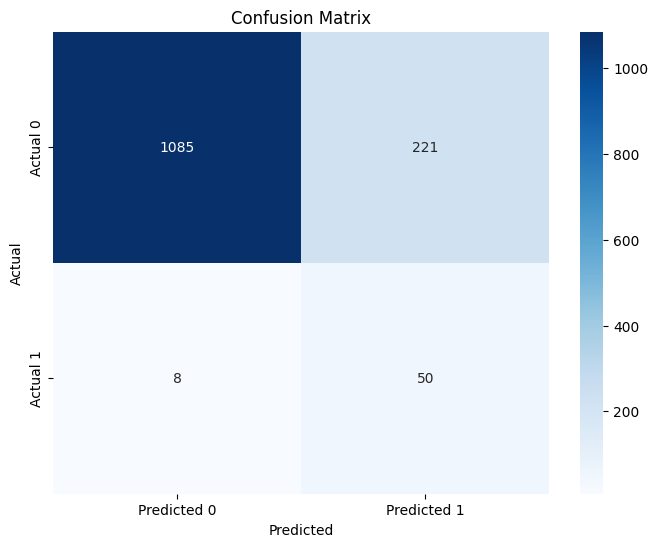

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1085 / 1306 = 83.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1306
           1       0.18      0.86      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_2Layers_64Size_0.1DO_1698265362
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.4804 - accuracy: 0.7982 - val_loss: 0.3868 - val_accuracy: 0.8542
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3506 - accuracy: 0.8561 - val_loss: 0.4287 - val_accuracy: 0.8046
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3244 - accuracy: 0.8657 - val_loss: 0.4041 - val_accuracy: 0.8136
Epoch 4/200
34

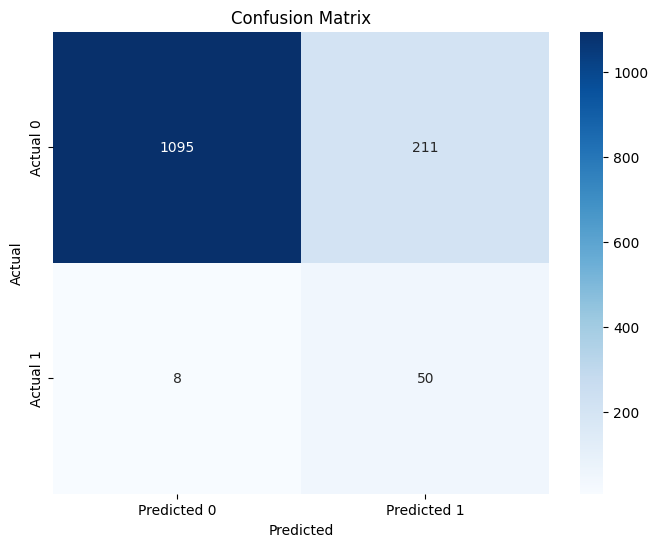

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1095 / 1306 = 83.84%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.86      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_2Layers_64Size_0.2DO_1698265367
Epoch 1/200
34/34 [==============================] - 3s 48ms/step - loss: 0.4838 - accuracy: 0.7929 - val_loss: 0.3359 - val_accuracy: 0.8933
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3486 - accuracy: 0.8527 - val_loss: 0.4338 - val_accuracy: 0.7824
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3312 - accuracy: 0.8602 - val_loss: 0.3886 - val_accuracy: 0.8169
Epoch 4/200
34

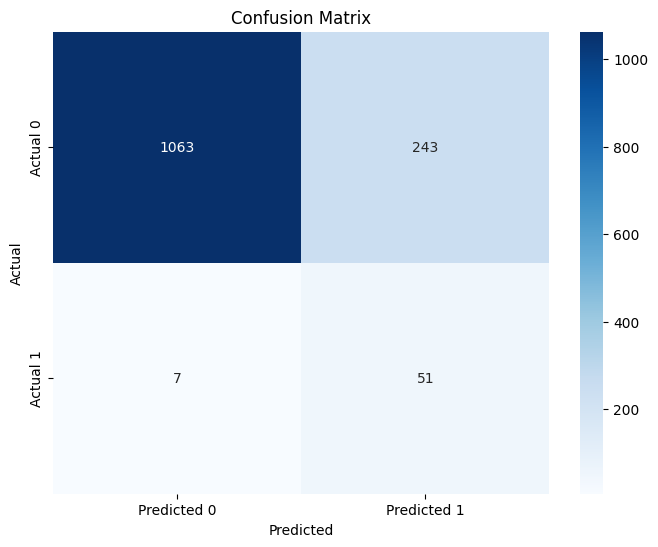

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1063 / 1306 = 81.39%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.29        58

    accuracy                           0.82      1364
   macro avg       0.58      0.85      0.59      1364
weighted avg       0.96      0.82      0.87      1364

FEA_EXT_DENSE_2Layers_96Size_0.15DO_1698265371
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5236 - accuracy: 0.7517 - val_loss: 0.3631 - val_accuracy: 0.9396
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3706 - accuracy: 0.8484 - val_loss: 0.3780 - val_accuracy: 0.8353
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.3309 - accuracy: 0.8611 - val_loss: 0.3975 - val_accuracy: 0.8207
Epoch 4/200
3

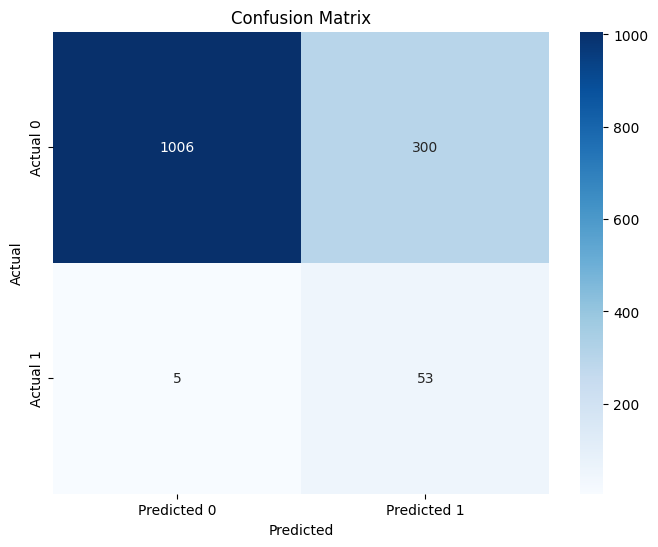

------------------------------
Percentage of positive (1) predicted correctly: 53 / 58 = 91.38%
Percentage of negative (0) predicted correctly: 1006 / 1306 = 77.03%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87      1306
           1       0.15      0.91      0.26        58

    accuracy                           0.78      1364
   macro avg       0.57      0.84      0.56      1364
weighted avg       0.96      0.78      0.84      1364

FEA_EXT_DENSE_2Layers_96Size_0.1DO_1698265376
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5405 - accuracy: 0.7412 - val_loss: 0.3968 - val_accuracy: 0.8495
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3779 - accuracy: 0.8526 - val_loss: 0.4104 - val_accuracy: 0.8108
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3351 - accuracy: 0.8637 - val_loss: 0.4049 - val_accuracy: 0.8084
Epoch 4/200
34

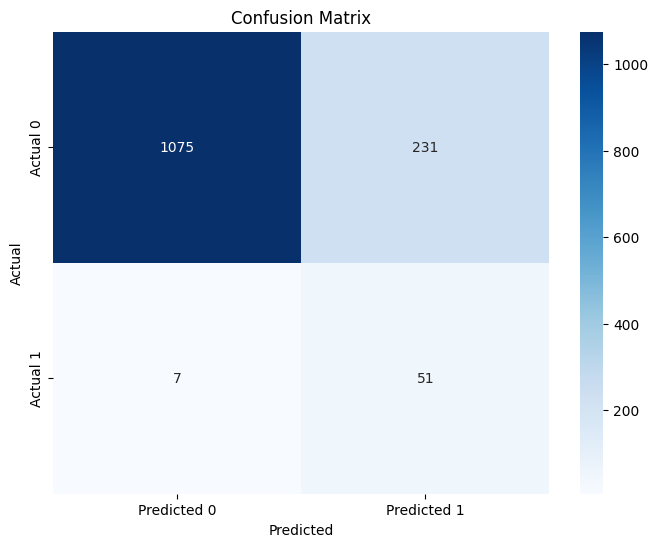

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1075 / 1306 = 82.31%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.88      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.87      1364

FEA_EXT_DENSE_2Layers_96Size_0.2DO_1698265380
Epoch 1/200
34/34 [==============================] - 3s 50ms/step - loss: 0.5405 - accuracy: 0.7558 - val_loss: 0.3488 - val_accuracy: 0.9401
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3794 - accuracy: 0.8432 - val_loss: 0.3675 - val_accuracy: 0.8344
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3372 - accuracy: 0.8559 - val_loss: 0.3740 - val_accuracy: 0.8301
Epoch 4/200
34

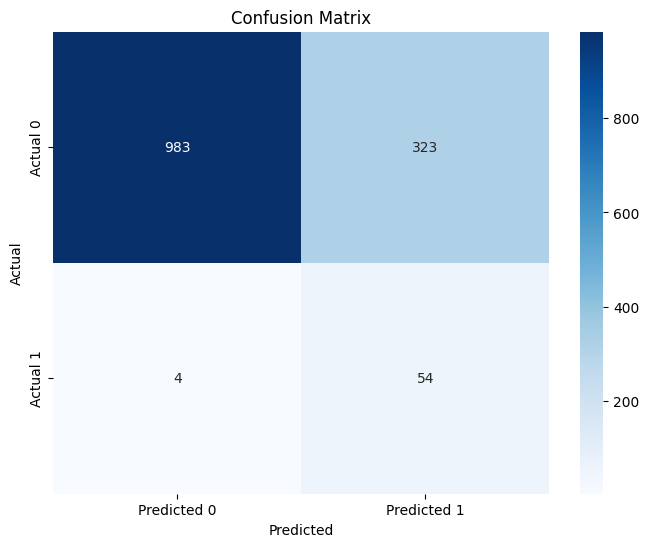

------------------------------
Percentage of positive (1) predicted correctly: 54 / 58 = 93.10%
Percentage of negative (0) predicted correctly: 983 / 1306 = 75.27%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86      1306
           1       0.14      0.93      0.25        58

    accuracy                           0.76      1364
   macro avg       0.57      0.84      0.55      1364
weighted avg       0.96      0.76      0.83      1364

FEA_EXT_DENSE_2Layers_96Size_0.15DO_1698265387
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5235 - accuracy: 0.7229 - val_loss: 0.3590 - val_accuracy: 0.8943
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3578 - accuracy: 0.8520 - val_loss: 0.3613 - val_accuracy: 0.8377
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3293 - accuracy: 0.8606 - val_loss: 0.4039 - val_accuracy: 0.8216
Epoch 4/200
34

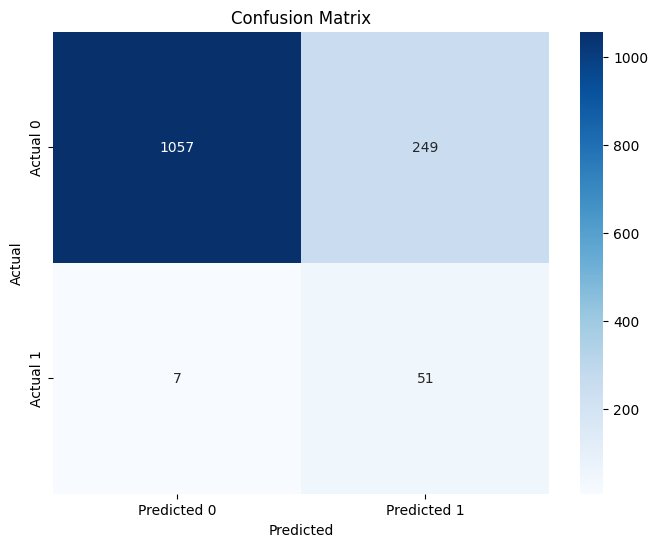

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1057 / 1306 = 80.93%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.28        58

    accuracy                           0.81      1364
   macro avg       0.58      0.84      0.59      1364
weighted avg       0.96      0.81      0.87      1364

FEA_EXT_DENSE_2Layers_96Size_0.1DO_1698265391
Epoch 1/200
34/34 [==============================] - 3s 51ms/step - loss: 0.4960 - accuracy: 0.7770 - val_loss: 0.3793 - val_accuracy: 0.8485
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3519 - accuracy: 0.8583 - val_loss: 0.4341 - val_accuracy: 0.7900
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3200 - accuracy: 0.8659 - val_loss: 0.4579 - val_accuracy: 0.7876
Epoch 4/200
3

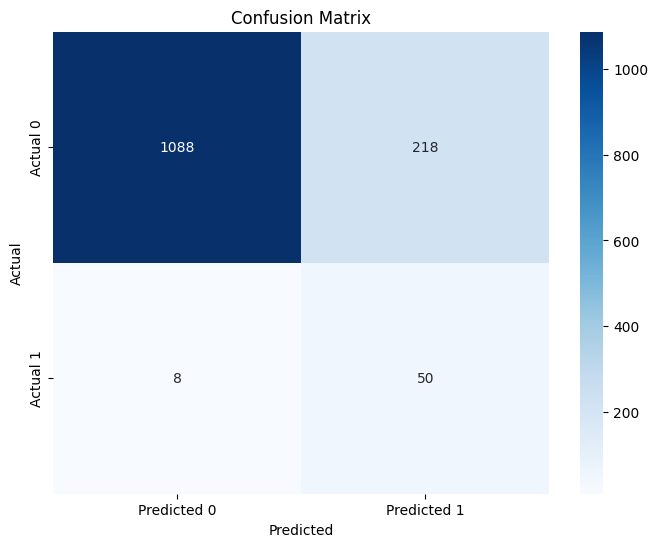

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1088 / 1306 = 83.31%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.86      0.31        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_2Layers_96Size_0.2DO_1698265397
Epoch 1/200
34/34 [==============================] - 2s 36ms/step - loss: 0.5043 - accuracy: 0.7688 - val_loss: 0.3209 - val_accuracy: 0.8938
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3606 - accuracy: 0.8489 - val_loss: 0.4337 - val_accuracy: 0.7697
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3304 - accuracy: 0.8620 - val_loss: 0.4105 - val_accuracy: 0.8084
Epoch 4/200
34

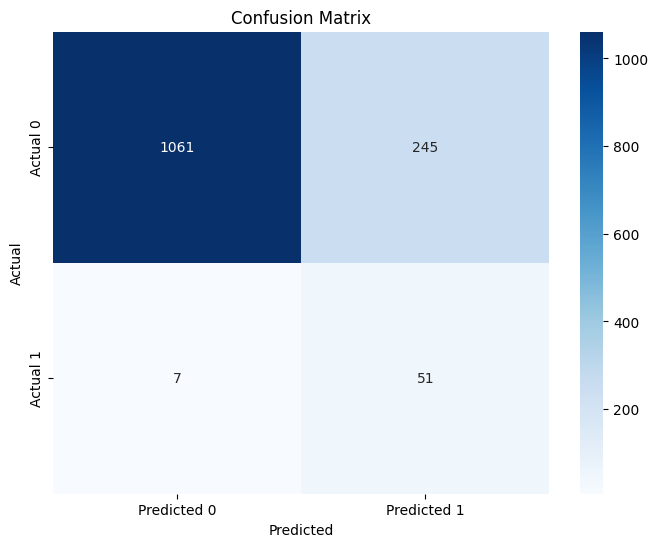

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1061 / 1306 = 81.24%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.29        58

    accuracy                           0.82      1364
   macro avg       0.58      0.85      0.59      1364
weighted avg       0.96      0.82      0.87      1364

FEA_EXT_DENSE_2Layers_96Size_0.15DO_1698265401
Epoch 1/200


34/34 [==============================] - 4s 38ms/step - loss: 0.4996 - accuracy: 0.7864 - val_loss: 0.3526 - val_accuracy: 0.8919
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3446 - accuracy: 0.8576 - val_loss: 0.3797 - val_accuracy: 0.8277
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3224 - accuracy: 0.8648 - val_loss: 0.3793 - val_accuracy: 0.8292
Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3116 - accuracy: 0.8698 - val_loss: 0.4094 - val_accuracy: 0.8240
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3016 - accuracy: 0.8751 - val_loss: 0.4222 - val_accuracy: 0.8353
Epoch 5: early stopping
loaded
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 96)                1344      
                                                      

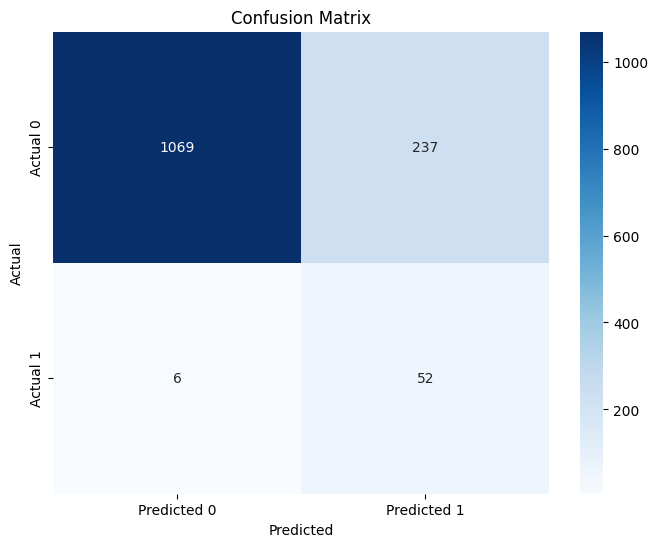

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 1069 / 1306 = 81.85%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.90      0.30        58

    accuracy                           0.82      1364
   macro avg       0.59      0.86      0.60      1364
weighted avg       0.96      0.82      0.87      1364

FEA_EXT_DENSE_2Layers_96Size_0.1DO_1698265407
Epoch 1/200
34/34 [==============================] - 3s 51ms/step - loss: 0.4670 - accuracy: 0.7923 - val_loss: 0.4135 - val_accuracy: 0.7919
Epoch 2/200
34/34 [==============================] - 1s 33ms/step - loss: 0.3344 - accuracy: 0.8632 - val_loss: 0.3916 - val_accuracy: 0.8084
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3167 - accuracy: 0.8701 - val_loss: 0.4582 - val_accuracy: 0.8004
Epoch 4/200
3

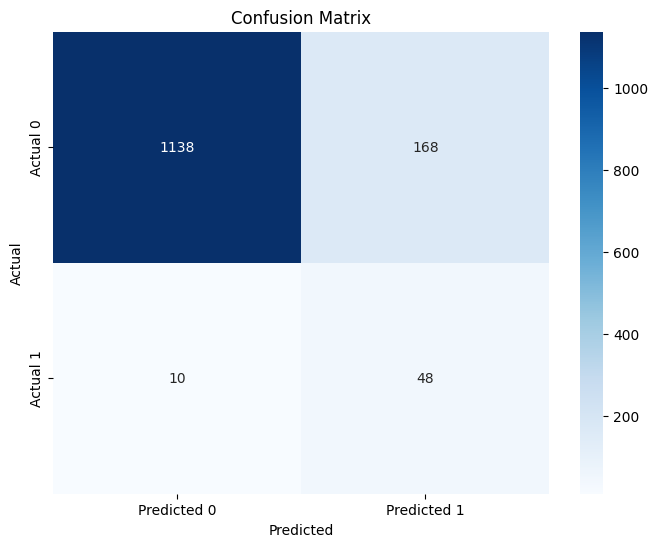

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1138 / 1306 = 87.14%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1306
           1       0.22      0.83      0.35        58

    accuracy                           0.87      1364
   macro avg       0.61      0.85      0.64      1364
weighted avg       0.96      0.87      0.90      1364

FEA_EXT_DENSE_2Layers_96Size_0.2DO_1698265414
Epoch 1/200
34/34 [==============================] - 2s 40ms/step - loss: 0.4631 - accuracy: 0.7954 - val_loss: 0.3616 - val_accuracy: 0.8452
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3409 - accuracy: 0.8612 - val_loss: 0.4641 - val_accuracy: 0.7777
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3199 - accuracy: 0.8691 - val_loss: 0.4192 - val_accuracy: 0.8183
Epoch 4/200
34

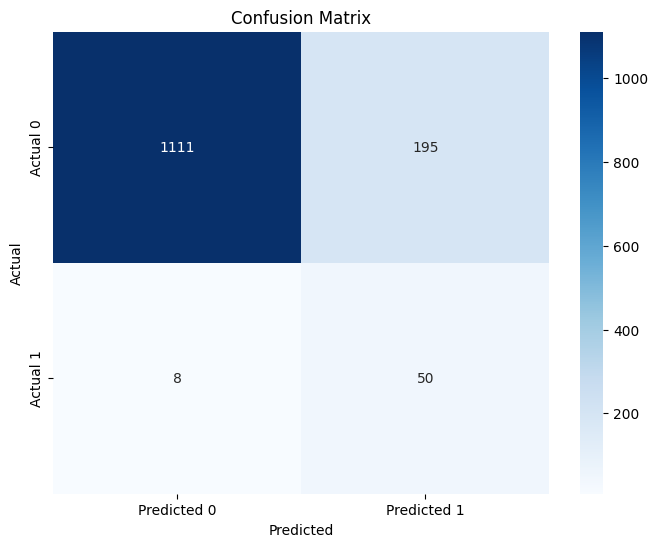

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1111 / 1306 = 85.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.86      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_2Layers_128Size_0.15DO_1698265418
Epoch 1/200
34/34 [==============================] - 2s 43ms/step - loss: 0.5309 - accuracy: 0.7491 - val_loss: 0.3569 - val_accuracy: 0.8872
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3707 - accuracy: 0.8591 - val_loss: 0.3809 - val_accuracy: 0.8155
Epoch 3/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3303 - accuracy: 0.8668 - val_loss: 0.4681 - val_accuracy: 0.7801
Epoch 4/20

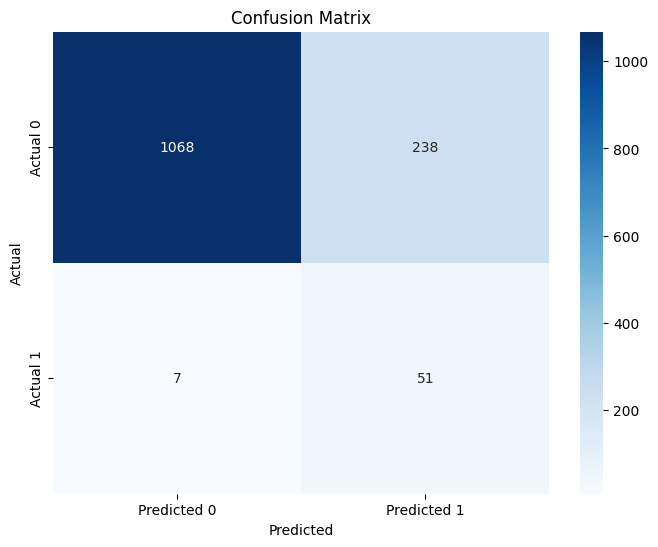

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1068 / 1306 = 81.78%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.88      0.29        58

    accuracy                           0.82      1364
   macro avg       0.58      0.85      0.60      1364
weighted avg       0.96      0.82      0.87      1364

FEA_EXT_DENSE_2Layers_128Size_0.1DO_1698265424
Epoch 1/200
34/34 [==============================] - 2s 34ms/step - loss: 0.4993 - accuracy: 0.7745 - val_loss: 0.3502 - val_accuracy: 0.8962
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3587 - accuracy: 0.8533 - val_loss: 0.3601 - val_accuracy: 0.8452
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3273 - accuracy: 0.8663 - val_loss: 0.4245 - val_accuracy: 0.7985
Epoch 4/200
3

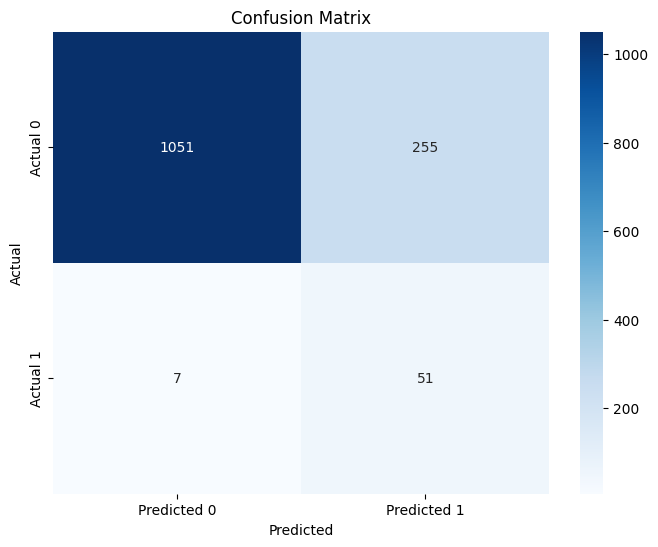

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1051 / 1306 = 80.47%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      1306
           1       0.17      0.88      0.28        58

    accuracy                           0.81      1364
   macro avg       0.58      0.84      0.58      1364
weighted avg       0.96      0.81      0.86      1364

FEA_EXT_DENSE_2Layers_128Size_0.2DO_1698265428
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.5342 - accuracy: 0.7425 - val_loss: 0.3753 - val_accuracy: 0.8915
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss: 0.3795 - accuracy: 0.8559 - val_loss: 0.3871 - val_accuracy: 0.8131
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3382 - accuracy: 0.8635 - val_loss: 0.3805 - val_accuracy: 0.8183
Epoch 4/200
3

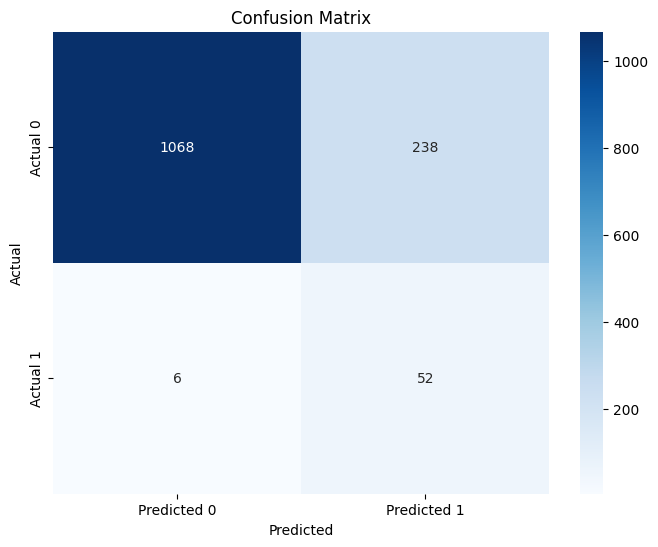

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 1068 / 1306 = 81.78%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.90      0.30        58

    accuracy                           0.82      1364
   macro avg       0.59      0.86      0.60      1364
weighted avg       0.96      0.82      0.87      1364

FEA_EXT_DENSE_2Layers_128Size_0.15DO_1698265432
Epoch 1/200
34/34 [==============================] - 2s 37ms/step - loss: 0.5140 - accuracy: 0.7495 - val_loss: 0.3430 - val_accuracy: 0.8782
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3498 - accuracy: 0.8633 - val_loss: 0.4076 - val_accuracy: 0.7985
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3194 - accuracy: 0.8689 - val_loss: 0.4229 - val_accuracy: 0.8131
Epoch 4/20

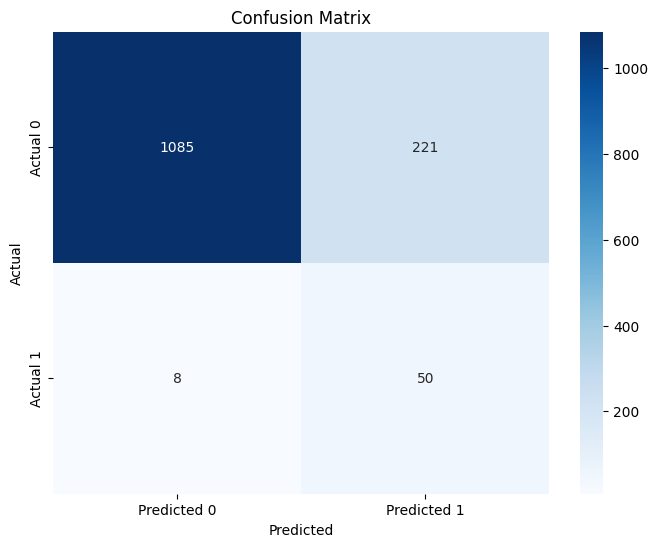

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1085 / 1306 = 83.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1306
           1       0.18      0.86      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_2Layers_128Size_0.1DO_1698265439
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.4724 - accuracy: 0.7921 - val_loss: 0.3613 - val_accuracy: 0.8518
Epoch 2/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3391 - accuracy: 0.8576 - val_loss: 0.4015 - val_accuracy: 0.8141
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3172 - accuracy: 0.8668 - val_loss: 0.4229 - val_accuracy: 0.8046
Epoch 4/200
3

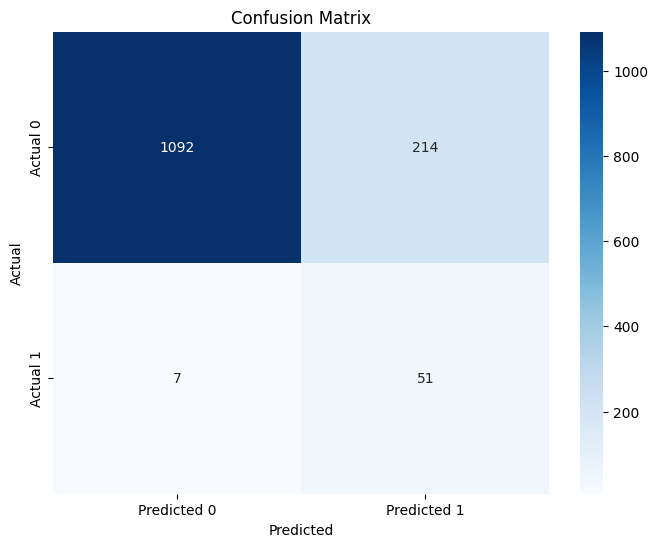

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1092 / 1306 = 83.61%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.88      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_2Layers_128Size_0.2DO_1698265443
Epoch 1/200
34/34 [==============================] - 2s 35ms/step - loss: 0.4569 - accuracy: 0.8022 - val_loss: 0.3735 - val_accuracy: 0.8476
Epoch 2/200
34/34 [==============================] - 1s 31ms/step - loss: 0.3393 - accuracy: 0.8592 - val_loss: 0.3734 - val_accuracy: 0.8282
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3219 - accuracy: 0.8645 - val_loss: 0.4370 - val_accuracy: 0.8075
Epoch 4/200


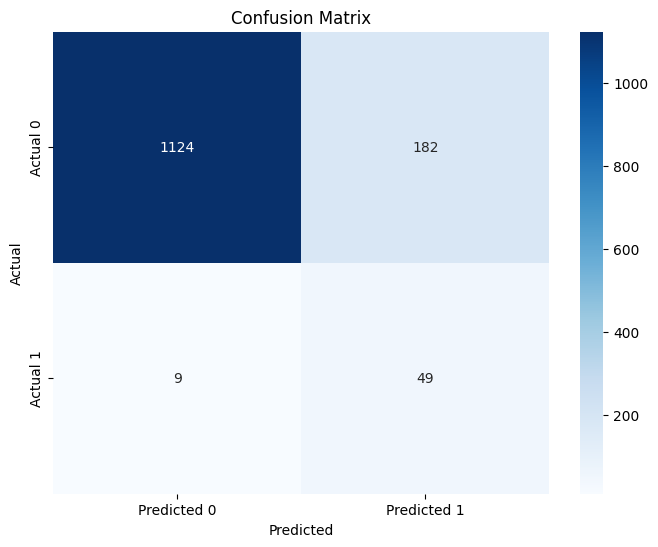

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1124 / 1306 = 86.06%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.84      0.34        58

    accuracy                           0.86      1364
   macro avg       0.60      0.85      0.63      1364
weighted avg       0.96      0.86      0.90      1364

FEA_EXT_DENSE_2Layers_128Size_0.15DO_1698265450
Epoch 1/200
30/34 [=========================>....] - ETA: 0s - loss: 0.4857 - accuracy: 0.7798

34/34 [==============================] - 4s 88ms/step - loss: 0.4763 - accuracy: 0.7859 - val_loss: 0.3865 - val_accuracy: 0.8367
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3355 - accuracy: 0.8598 - val_loss: 0.4592 - val_accuracy: 0.7891
Epoch 3/200
34/34 [==============================] - 0s 7ms/step - loss: 0.3187 - accuracy: 0.8652 - val_loss: 0.4292 - val_accuracy: 0.8150
Epoch 4/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3098 - accuracy: 0.8694 - val_loss: 0.4607 - val_accuracy: 0.8131
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3007 - accuracy: 0.8723 - val_loss: 0.4751 - val_accuracy: 0.8013
Epoch 5: early stopping
loaded
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 128)               1792      
                                                      

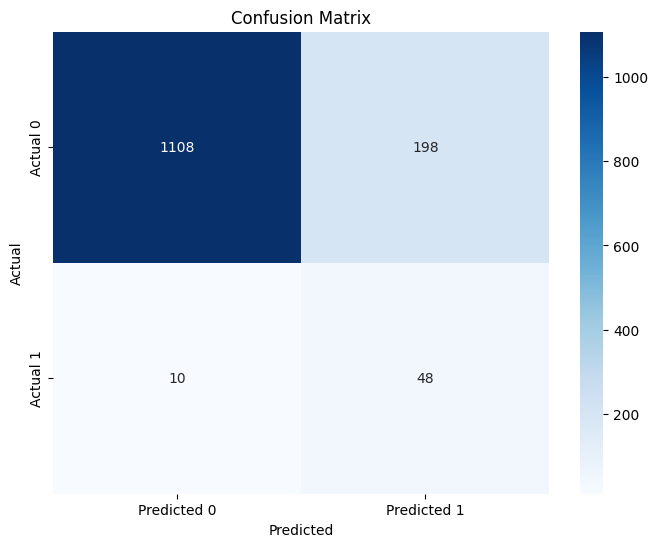

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1108 / 1306 = 84.84%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.20      0.83      0.32        58

    accuracy                           0.85      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_2Layers_128Size_0.1DO_1698265456
Epoch 1/200
34/34 [==============================] - 2s 37ms/step - loss: 0.4307 - accuracy: 0.8243 - val_loss: 0.4264 - val_accuracy: 0.7872
Epoch 2/200
34/34 [==============================] - 1s 34ms/step - loss: 0.3309 - accuracy: 0.8617 - val_loss: 0.3810 - val_accuracy: 0.8273
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3122 - accuracy: 0.8697 - val_loss: 0.4312 - val_accuracy: 0.8093
Epoch 4/200

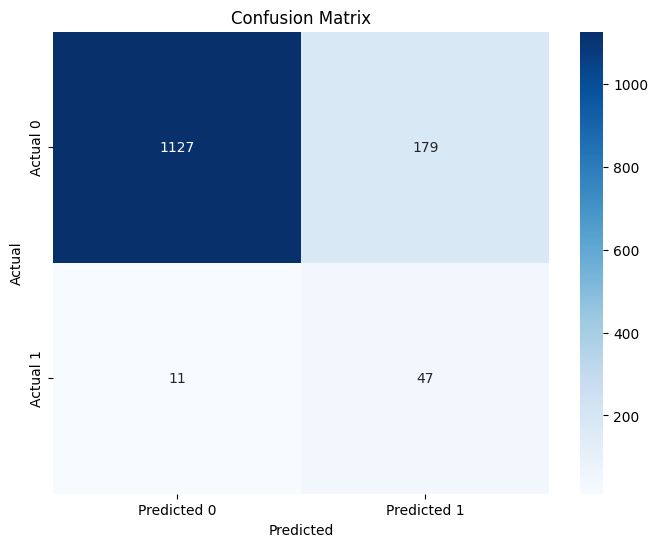

------------------------------
Percentage of positive (1) predicted correctly: 47 / 58 = 81.03%
Percentage of negative (0) predicted correctly: 1127 / 1306 = 86.29%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.81      0.33        58

    accuracy                           0.86      1364
   macro avg       0.60      0.84      0.63      1364
weighted avg       0.96      0.86      0.90      1364

FEA_EXT_DENSE_2Layers_128Size_0.2DO_1698265463
Epoch 1/200
34/34 [==============================] - 2s 38ms/step - loss: 0.4759 - accuracy: 0.7844 - val_loss: 0.3493 - val_accuracy: 0.8386
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3380 - accuracy: 0.8619 - val_loss: 0.4136 - val_accuracy: 0.7994
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3180 - accuracy: 0.8717 - val_loss: 0.4400 - val_accuracy: 0.8042
Epoch 4/200
3

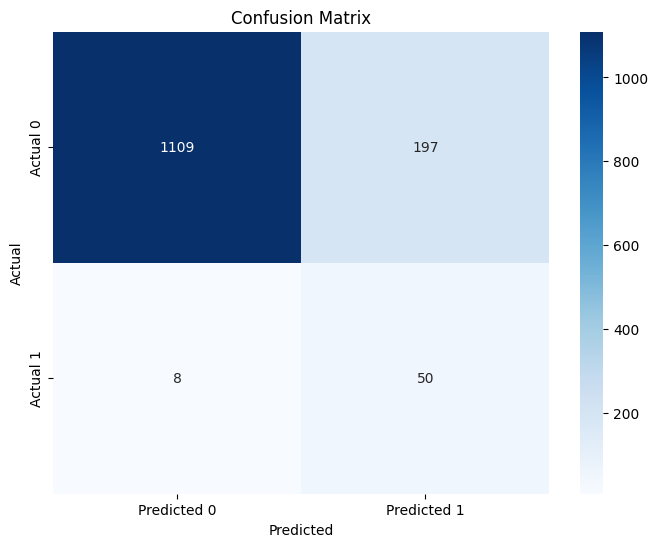

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1109 / 1306 = 84.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.86      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_32Size_0.15DO_1698265468
Epoch 1/200
34/34 [==============================] - 3s 44ms/step - loss: 0.5137 - accuracy: 0.7728 - val_loss: 0.2779 - val_accuracy: 0.9042
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3682 - accuracy: 0.8425 - val_loss: 0.3533 - val_accuracy: 0.8395
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3367 - accuracy: 0.8553 - val_loss: 0.3804 - val_accuracy: 0.8358
Epoch 4/200


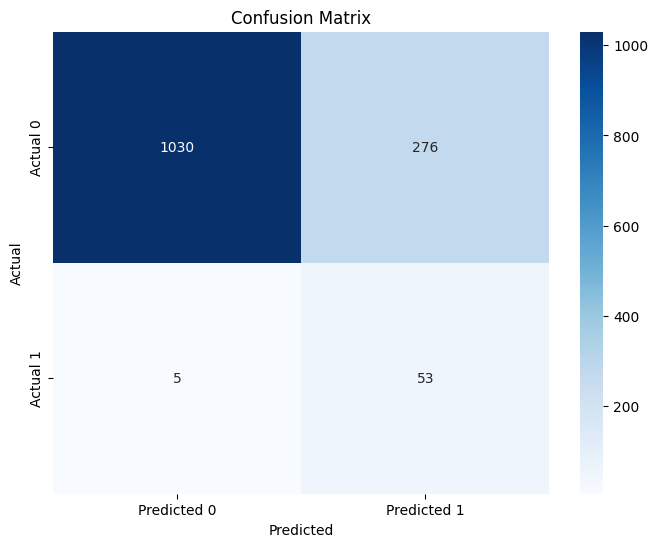

------------------------------
Percentage of positive (1) predicted correctly: 53 / 58 = 91.38%
Percentage of negative (0) predicted correctly: 1030 / 1306 = 78.87%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88      1306
           1       0.16      0.91      0.27        58

    accuracy                           0.79      1364
   macro avg       0.58      0.85      0.58      1364
weighted avg       0.96      0.79      0.85      1364

FEA_EXT_DENSE_3Layers_32Size_0.1DO_1698265473
Epoch 1/200
34/34 [==============================] - 4s 68ms/step - loss: 0.5397 - accuracy: 0.7355 - val_loss: 0.3605 - val_accuracy: 0.8938
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3573 - accuracy: 0.8521 - val_loss: 0.4211 - val_accuracy: 0.8060
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3267 - accuracy: 0.8613 - val_loss: 0.4803 - val_accuracy: 0.8032
Epoch 4/200


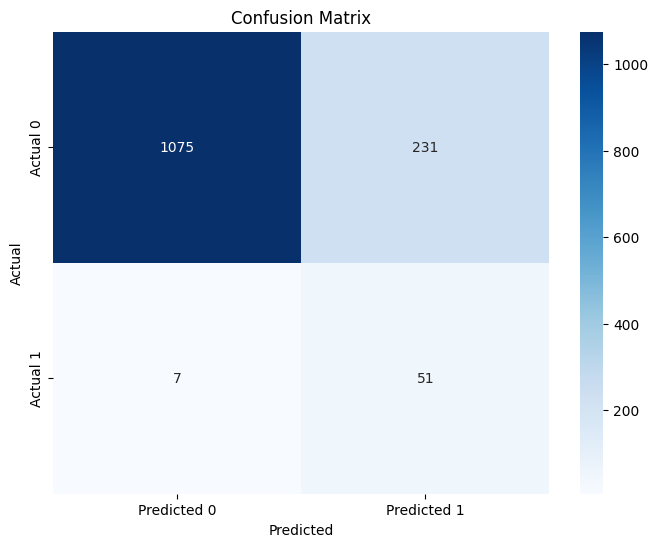

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1075 / 1306 = 82.31%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.88      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.87      1364

FEA_EXT_DENSE_3Layers_32Size_0.2DO_1698265480
Epoch 1/200
34/34 [==============================] - 3s 46ms/step - loss: 0.5458 - accuracy: 0.7514 - val_loss: 0.3308 - val_accuracy: 0.8660
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3632 - accuracy: 0.8511 - val_loss: 0.3477 - val_accuracy: 0.8490
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3350 - accuracy: 0.8619 - val_loss: 0.4319 - val_accuracy: 0.8296
Epoch 4/200
34

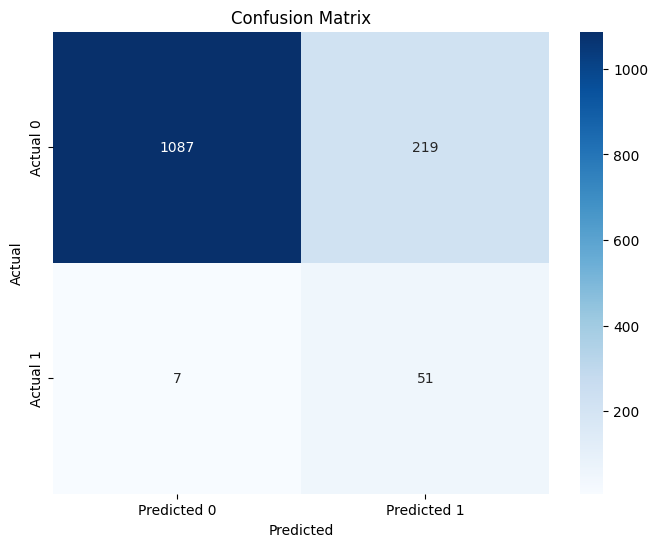

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1087 / 1306 = 83.23%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.88      0.31        58

    accuracy                           0.83      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_32Size_0.15DO_1698265485
Epoch 1/200
34/34 [==============================] - 4s 81ms/step - loss: 0.5094 - accuracy: 0.7770 - val_loss: 0.3264 - val_accuracy: 0.8834
Epoch 2/200
34/34 [==============================] - 1s 34ms/step - loss: 0.3554 - accuracy: 0.8554 - val_loss: 0.3391 - val_accuracy: 0.8419
Epoch 3/200
34/34 [==============================] - 1s 35ms/step - loss: 0.3291 - accuracy: 0.8597 - val_loss: 0.3985 - val_accuracy: 0.8230
Epoch 4/200

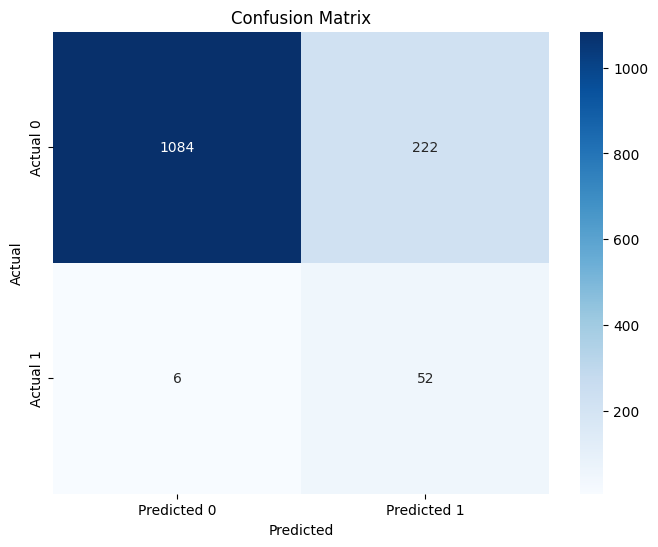

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 1084 / 1306 = 83.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1306
           1       0.19      0.90      0.31        58

    accuracy                           0.83      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_32Size_0.1DO_1698265499
Epoch 1/200
34/34 [==============================] - 8s 189ms/step - loss: 0.4788 - accuracy: 0.8040 - val_loss: 0.3856 - val_accuracy: 0.8287
Epoch 2/200
34/34 [==============================] - 1s 19ms/step - loss: 0.3476 - accuracy: 0.8544 - val_loss: 0.4334 - val_accuracy: 0.8150
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3229 - accuracy: 0.8623 - val_loss: 0.4341 - val_accuracy: 0.8240
Epoch 4/200

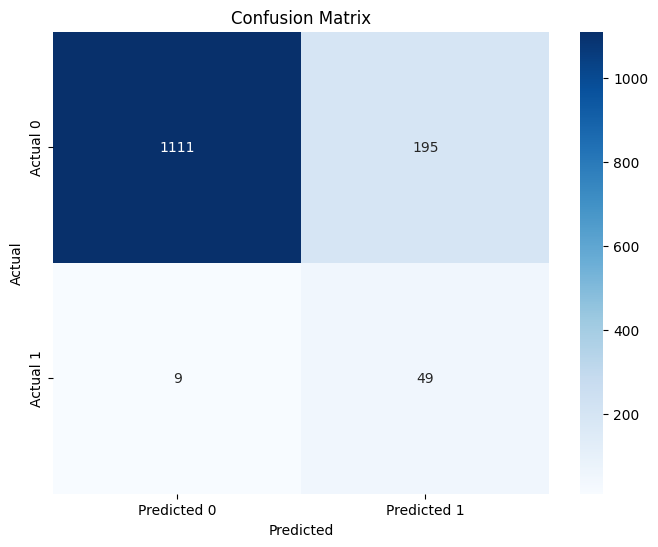

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1111 / 1306 = 85.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.84      0.32        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_32Size_0.2DO_1698265510
Epoch 1/200
34/34 [==============================] - 3s 45ms/step - loss: 0.4948 - accuracy: 0.7876 - val_loss: 0.3379 - val_accuracy: 0.8636
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3687 - accuracy: 0.8414 - val_loss: 0.3555 - val_accuracy: 0.8598
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.3456 - accuracy: 0.8552 - val_loss: 0.4149 - val_accuracy: 0.8358
Epoch 4/200
34

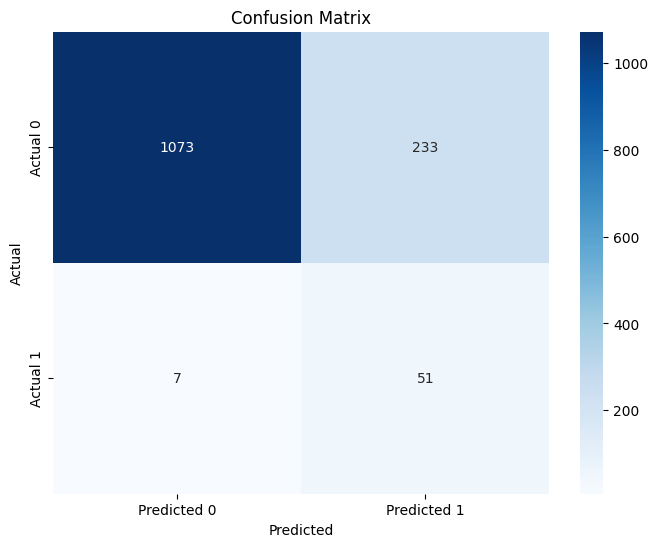

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1073 / 1306 = 82.16%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.88      0.30        58

    accuracy                           0.82      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.82      0.87      1364

FEA_EXT_DENSE_3Layers_32Size_0.15DO_1698265518
Epoch 1/200
34/34 [==============================] - ETA: 0s - loss: 0.5183 - accuracy: 0.7595

34/34 [==============================] - 6s 147ms/step - loss: 0.5183 - accuracy: 0.7595 - val_loss: 0.3191 - val_accuracy: 0.9061
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3649 - accuracy: 0.8400 - val_loss: 0.3441 - val_accuracy: 0.8726
Epoch 3/200
34/34 [==============================] - 0s 15ms/step - loss: 0.3292 - accuracy: 0.8573 - val_loss: 0.3787 - val_accuracy: 0.8523
Epoch 4/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3183 - accuracy: 0.8646 - val_loss: 0.4264 - val_accuracy: 0.8344
Epoch 5/200
34/34 [==============================] - 1s 14ms/step - loss: 0.3139 - accuracy: 0.8664 - val_loss: 0.4501 - val_accuracy: 0.8353
Epoch 5: early stopping
loaded
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 32)                448       
                                                 

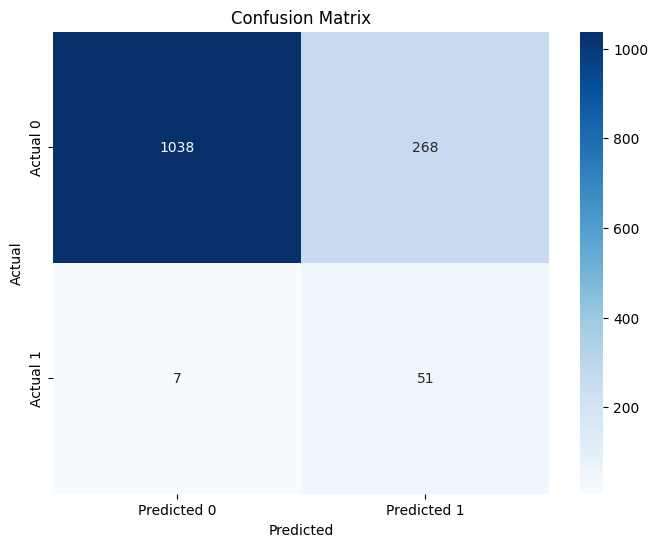

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1038 / 1306 = 79.48%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      1306
           1       0.16      0.88      0.27        58

    accuracy                           0.80      1364
   macro avg       0.58      0.84      0.58      1364
weighted avg       0.96      0.80      0.86      1364

FEA_EXT_DENSE_3Layers_32Size_0.1DO_1698265532
Epoch 1/200
34/34 [==============================] - 6s 76ms/step - loss: 0.4786 - accuracy: 0.7973 - val_loss: 0.4072 - val_accuracy: 0.8414
Epoch 2/200
34/34 [==============================] - 2s 70ms/step - loss: 0.3530 - accuracy: 0.8448 - val_loss: 0.3972 - val_accuracy: 0.8367
Epoch 3/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3248 - accuracy: 0.8635 - val_loss: 0.4491 - val_accuracy: 0.8235
Epoch 4/200


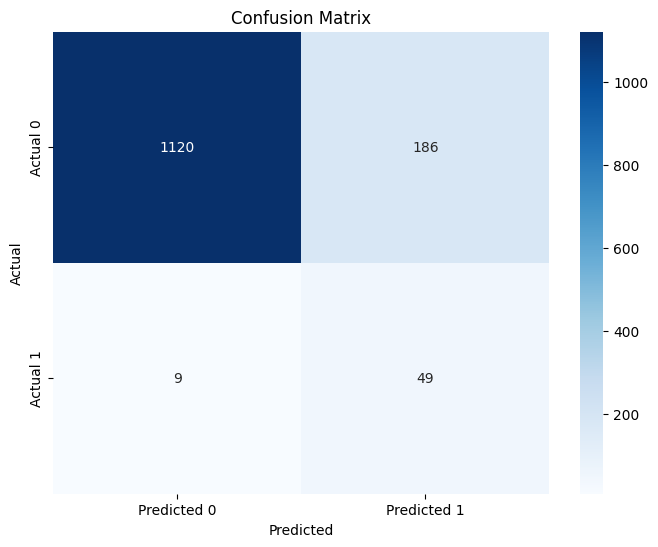

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1120 / 1306 = 85.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.84      0.33        58

    accuracy                           0.86      1364
   macro avg       0.60      0.85      0.63      1364
weighted avg       0.96      0.86      0.90      1364

FEA_EXT_DENSE_3Layers_32Size_0.2DO_1698265544
Epoch 1/200
34/34 [==============================] - 8s 128ms/step - loss: 0.4975 - accuracy: 0.7862 - val_loss: 0.3592 - val_accuracy: 0.8589
Epoch 2/200
34/34 [==============================] - 1s 16ms/step - loss: 0.3551 - accuracy: 0.8478 - val_loss: 0.4183 - val_accuracy: 0.8268
Epoch 3/200
34/34 [==============================] - 1s 26ms/step - loss: 0.3320 - accuracy: 0.8609 - val_loss: 0.4295 - val_accuracy: 0.8287
Epoch 4/200

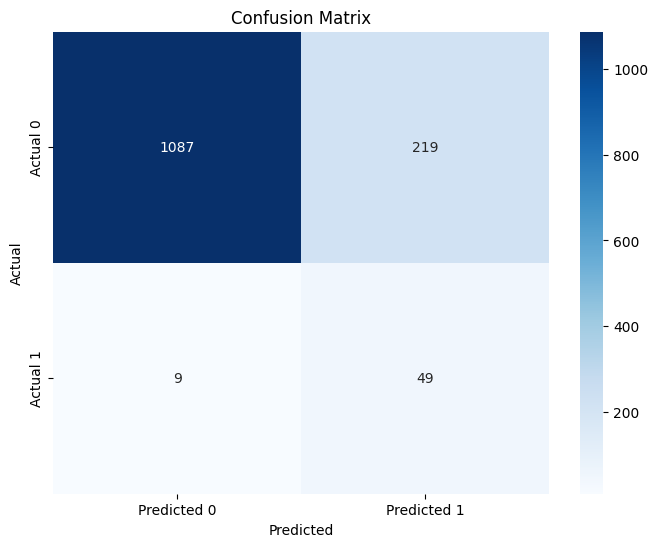

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1087 / 1306 = 83.23%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.18      0.84      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.84      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_32Size_0.15DO_1698265559
Epoch 1/200
34/34 [==============================] - 6s 112ms/step - loss: 0.4961 - accuracy: 0.7714 - val_loss: 0.3761 - val_accuracy: 0.8216
Epoch 2/200
34/34 [==============================] - 2s 73ms/step - loss: 0.3411 - accuracy: 0.8510 - val_loss: 0.3522 - val_accuracy: 0.8523
Epoch 3/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3199 - accuracy: 0.8672 - val_loss: 0.4170 - val_accuracy: 0.8216
Epoch 4/20

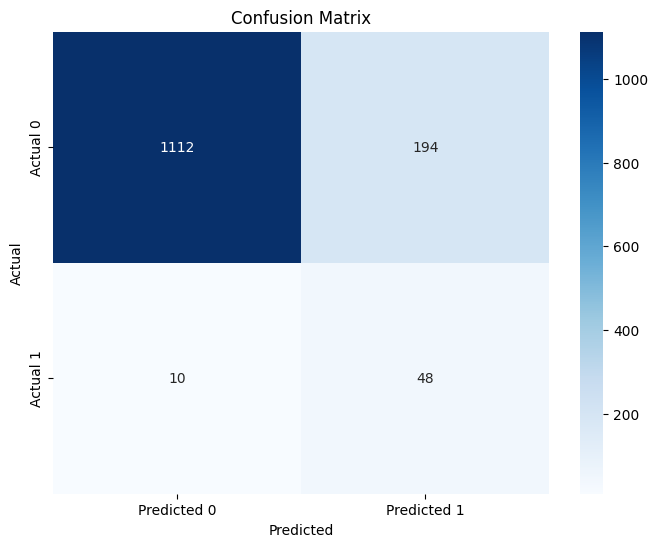

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1112 / 1306 = 85.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.83      0.32        58

    accuracy                           0.85      1364
   macro avg       0.59      0.84      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_32Size_0.1DO_1698265573
Epoch 1/200
34/34 [==============================] - 4s 85ms/step - loss: 0.4662 - accuracy: 0.8060 - val_loss: 0.3236 - val_accuracy: 0.8495
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3342 - accuracy: 0.8582 - val_loss: 0.3417 - val_accuracy: 0.8480
Epoch 3/200
34/34 [==============================] - 1s 16ms/step - loss: 0.3184 - accuracy: 0.8654 - val_loss: 0.4099 - val_accuracy: 0.8306
Epoch 4/200


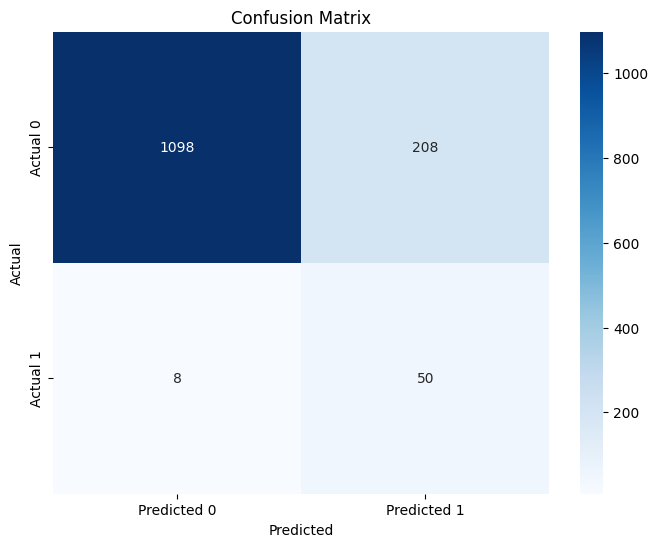

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1098 / 1306 = 84.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.86      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_32Size_0.2DO_1698265581
Epoch 1/200
34/34 [==============================] - 3s 57ms/step - loss: 0.5018 - accuracy: 0.7759 - val_loss: 0.3438 - val_accuracy: 0.8438
Epoch 2/200
34/34 [==============================] - 2s 50ms/step - loss: 0.3537 - accuracy: 0.8497 - val_loss: 0.3267 - val_accuracy: 0.8608
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3343 - accuracy: 0.8591 - val_loss: 0.4101 - val_accuracy: 0.8311
Epoch 4/200
3

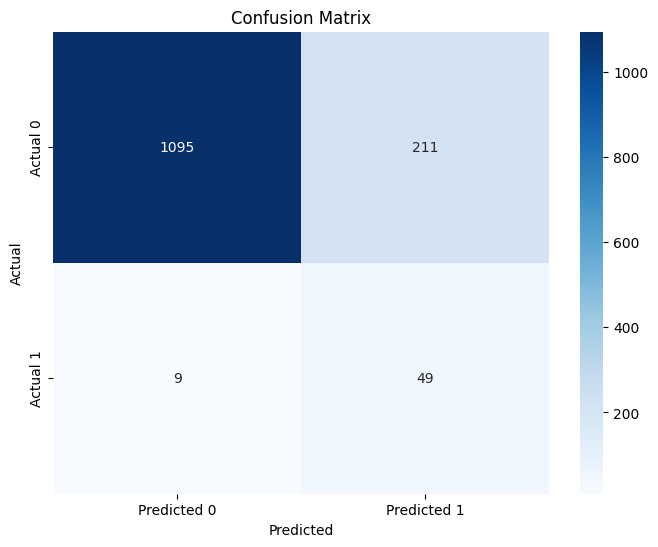

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1095 / 1306 = 83.84%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.84      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_32Size_0.15DO_1698265589
Epoch 1/200
34/34 [==============================] - 5s 89ms/step - loss: 0.4714 - accuracy: 0.7970 - val_loss: 0.3700 - val_accuracy: 0.8240
Epoch 2/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3480 - accuracy: 0.8475 - val_loss: 0.4210 - val_accuracy: 0.8254
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3279 - accuracy: 0.8612 - val_loss: 0.4259 - val_accuracy: 0.8325
Epoch 4/200

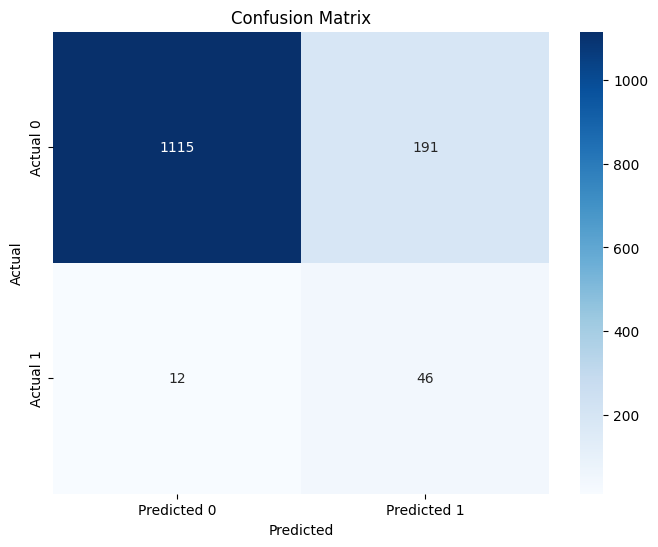

------------------------------
Percentage of positive (1) predicted correctly: 46 / 58 = 79.31%
Percentage of negative (0) predicted correctly: 1115 / 1306 = 85.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.19      0.79      0.31        58

    accuracy                           0.85      1364
   macro avg       0.59      0.82      0.61      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_32Size_0.1DO_1698265599
Epoch 1/200
33/34 [============================>.] - ETA: 0s - loss: 0.4627 - accuracy: 0.8124

34/34 [==============================] - 6s 140ms/step - loss: 0.4626 - accuracy: 0.8122 - val_loss: 0.3433 - val_accuracy: 0.8556
Epoch 2/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3384 - accuracy: 0.8584 - val_loss: 0.4251 - val_accuracy: 0.8226
Epoch 3/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3240 - accuracy: 0.8642 - val_loss: 0.4335 - val_accuracy: 0.8282
Epoch 4/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3122 - accuracy: 0.8677 - val_loss: 0.4066 - val_accuracy: 0.8395
Epoch 5/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3072 - accuracy: 0.8711 - val_loss: 0.4809 - val_accuracy: 0.8131
Epoch 5: early stopping
loaded
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_164 (Dense)           (None, 32)                448       
                                                 

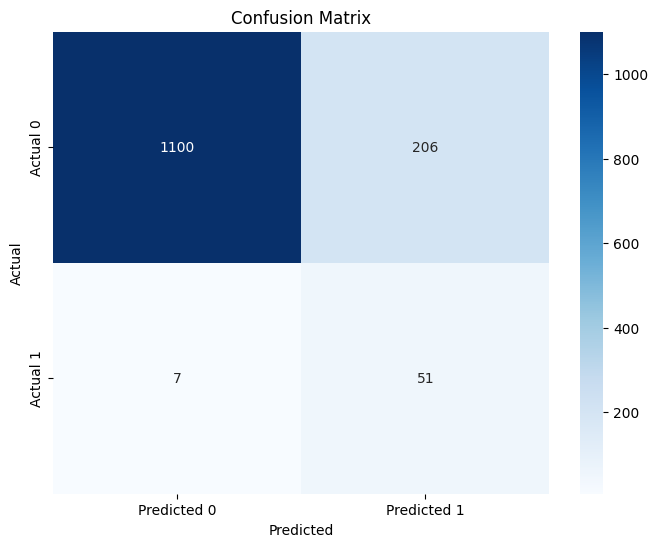

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1100 / 1306 = 84.23%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.20      0.88      0.32        58

    accuracy                           0.84      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_32Size_0.2DO_1698265610
Epoch 1/200
34/34 [==============================] - 3s 67ms/step - loss: 0.5212 - accuracy: 0.7666 - val_loss: 0.3256 - val_accuracy: 0.8693
Epoch 2/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3692 - accuracy: 0.8487 - val_loss: 0.3896 - val_accuracy: 0.8339
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3381 - accuracy: 0.8625 - val_loss: 0.4199 - val_accuracy: 0.8230
Epoch 4/200


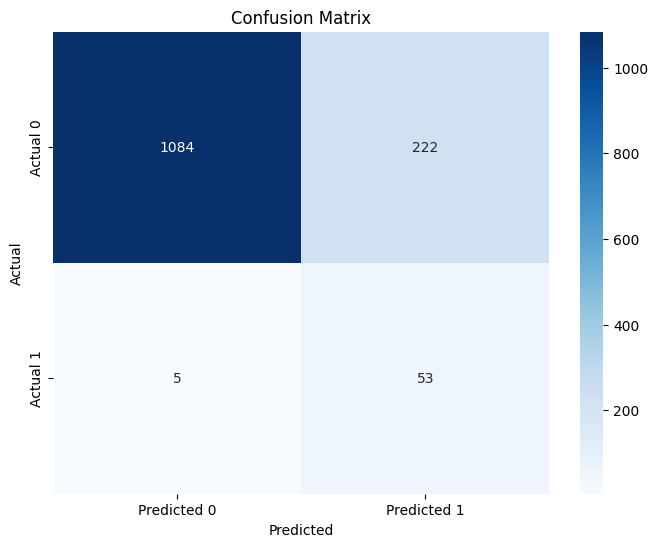

------------------------------
Percentage of positive (1) predicted correctly: 53 / 58 = 91.38%
Percentage of negative (0) predicted correctly: 1084 / 1306 = 83.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91      1306
           1       0.19      0.91      0.32        58

    accuracy                           0.83      1364
   macro avg       0.59      0.87      0.61      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_32Size_0.15DO_1698265617
Epoch 1/200
34/34 [==============================] - 4s 80ms/step - loss: 0.4915 - accuracy: 0.7778 - val_loss: 0.3579 - val_accuracy: 0.8575
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3434 - accuracy: 0.8474 - val_loss: 0.3988 - val_accuracy: 0.8414
Epoch 3/200
34/34 [==============================] - 1s 21ms/step - loss: 0.3226 - accuracy: 0.8599 - val_loss: 0.4351 - val_accuracy: 0.8353
Epoch 4/200

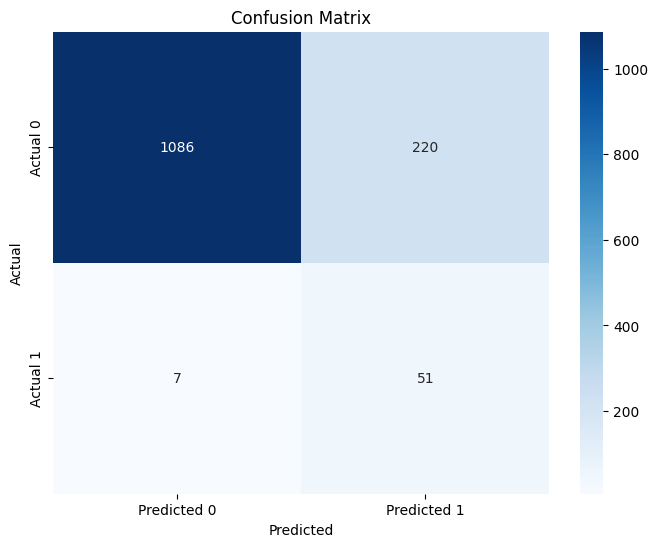

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1086 / 1306 = 83.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.88      0.31        58

    accuracy                           0.83      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_32Size_0.1DO_1698265625
Epoch 1/200
34/34 [==============================] - 3s 56ms/step - loss: 0.4926 - accuracy: 0.7843 - val_loss: 0.4072 - val_accuracy: 0.8103
Epoch 2/200
34/34 [==============================] - 2s 52ms/step - loss: 0.3427 - accuracy: 0.8617 - val_loss: 0.3755 - val_accuracy: 0.8311
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3154 - accuracy: 0.8656 - val_loss: 0.4470 - val_accuracy: 0.8183
Epoch 4/200


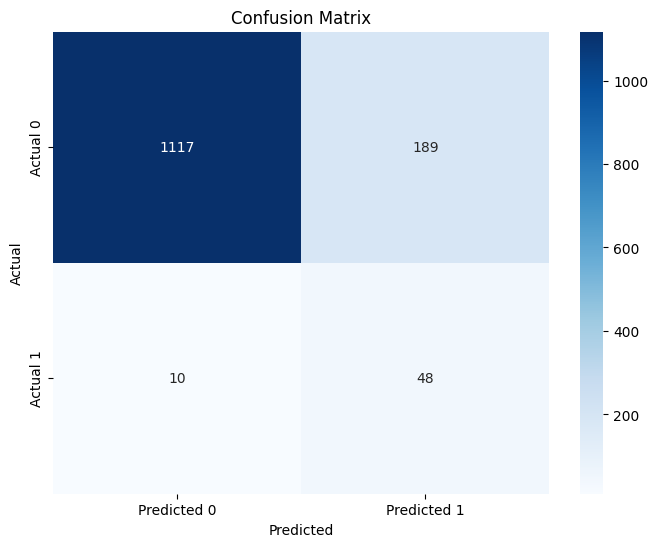

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1117 / 1306 = 85.53%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.20      0.83      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.84      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_32Size_0.2DO_1698265633
Epoch 1/200
34/34 [==============================] - 4s 84ms/step - loss: 0.5142 - accuracy: 0.7735 - val_loss: 0.4012 - val_accuracy: 0.7990
Epoch 2/200
34/34 [==============================] - 2s 53ms/step - loss: 0.3654 - accuracy: 0.8487 - val_loss: 0.3699 - val_accuracy: 0.8320
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3337 - accuracy: 0.8609 - val_loss: 0.4138 - val_accuracy: 0.8329
Epoch 4/200


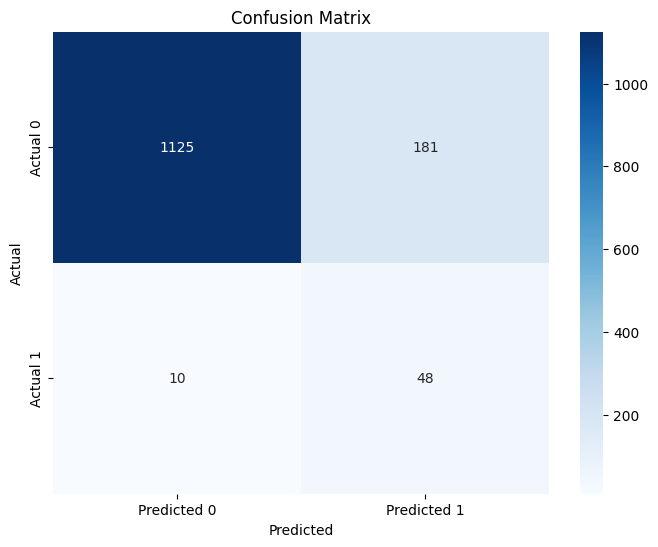

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1125 / 1306 = 86.14%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.83      0.33        58

    accuracy                           0.86      1364
   macro avg       0.60      0.84      0.63      1364
weighted avg       0.96      0.86      0.90      1364

FEA_EXT_DENSE_3Layers_64Size_0.15DO_1698265647
Epoch 1/200
34/34 [==============================] - 7s 81ms/step - loss: 0.5410 - accuracy: 0.7624 - val_loss: 0.3771 - val_accuracy: 0.8849
Epoch 2/200
34/34 [==============================] - 3s 80ms/step - loss: 0.3630 - accuracy: 0.8531 - val_loss: 0.3641 - val_accuracy: 0.8358
Epoch 3/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3352 - accuracy: 0.8582 - val_loss: 0.4185 - val_accuracy: 0.8235
Epoch 4/200

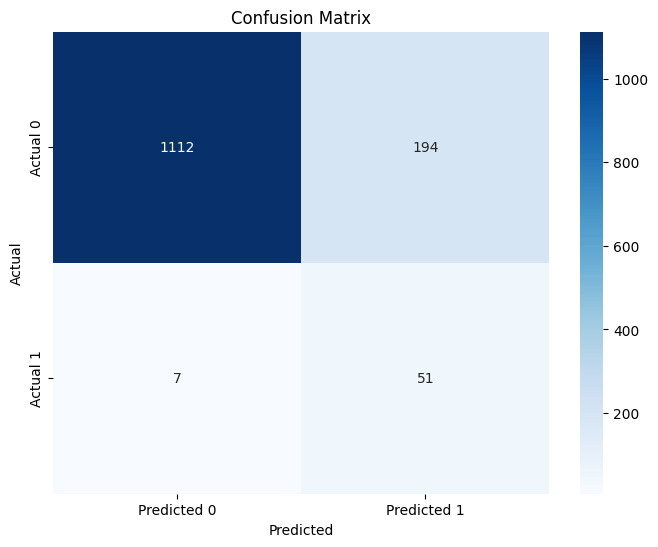

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1112 / 1306 = 85.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.21      0.88      0.34        58

    accuracy                           0.85      1364
   macro avg       0.60      0.87      0.63      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.1DO_1698265660
Epoch 1/200
34/34 [==============================] - 4s 74ms/step - loss: 0.5273 - accuracy: 0.7949 - val_loss: 0.3526 - val_accuracy: 0.8872
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3425 - accuracy: 0.8622 - val_loss: 0.3725 - val_accuracy: 0.8254
Epoch 3/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3214 - accuracy: 0.8654 - val_loss: 0.4785 - val_accuracy: 0.7971
Epoch 4/200


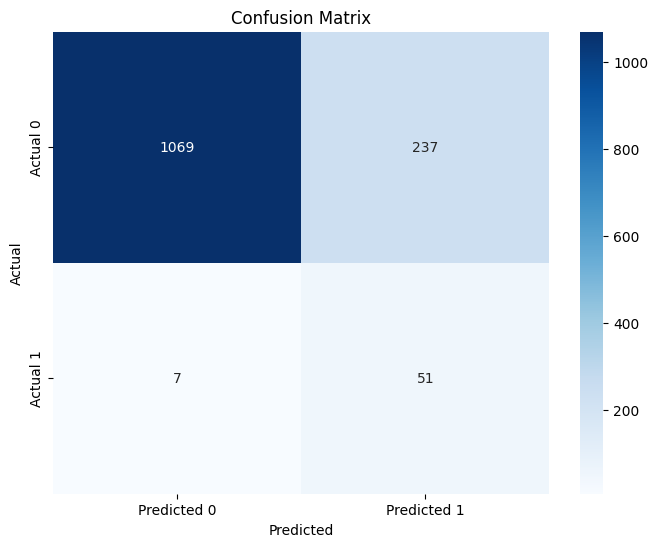

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1069 / 1306 = 81.85%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.88      0.29        58

    accuracy                           0.82      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.82      0.87      1364

FEA_EXT_DENSE_3Layers_64Size_0.2DO_1698265668
Epoch 1/200
34/34 [==============================] - 3s 57ms/step - loss: 0.5579 - accuracy: 0.7432 - val_loss: 0.3399 - val_accuracy: 0.8891
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3722 - accuracy: 0.8485 - val_loss: 0.4081 - val_accuracy: 0.8126
Epoch 3/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3343 - accuracy: 0.8580 - val_loss: 0.4177 - val_accuracy: 0.8325
Epoch 4/200
3

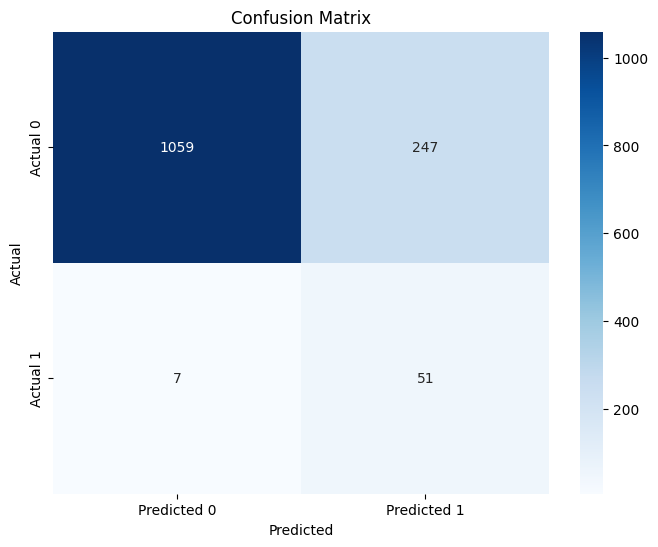

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1059 / 1306 = 81.09%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.29        58

    accuracy                           0.81      1364
   macro avg       0.58      0.85      0.59      1364
weighted avg       0.96      0.81      0.87      1364

FEA_EXT_DENSE_3Layers_64Size_0.15DO_1698265676
Epoch 1/200
33/34 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.7835

34/34 [==============================] - 6s 135ms/step - loss: 0.4974 - accuracy: 0.7836 - val_loss: 0.3573 - val_accuracy: 0.8617
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3469 - accuracy: 0.8537 - val_loss: 0.4235 - val_accuracy: 0.8112
Epoch 3/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3191 - accuracy: 0.8645 - val_loss: 0.4500 - val_accuracy: 0.8103
Epoch 4/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3150 - accuracy: 0.8701 - val_loss: 0.4563 - val_accuracy: 0.8240
Epoch 5/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3055 - accuracy: 0.8724 - val_loss: 0.4209 - val_accuracy: 0.8372
Epoch 5: early stopping
loaded
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 64)                896       
                                                   

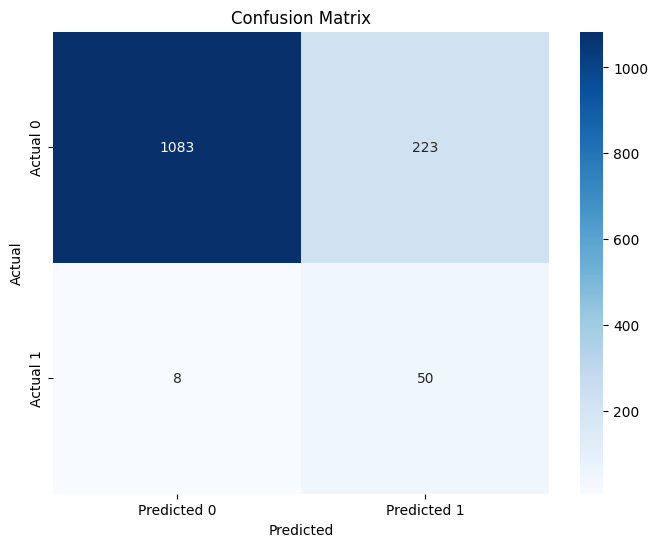

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1083 / 1306 = 82.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1306
           1       0.18      0.86      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_64Size_0.1DO_1698265690
Epoch 1/200
34/34 [==============================] - 4s 66ms/step - loss: 0.5511 - accuracy: 0.7355 - val_loss: 0.3866 - val_accuracy: 0.8273
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3462 - accuracy: 0.8521 - val_loss: 0.4113 - val_accuracy: 0.8131
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3223 - accuracy: 0.8639 - val_loss: 0.4136 - val_accuracy: 0.8301
Epoch 4/200
3

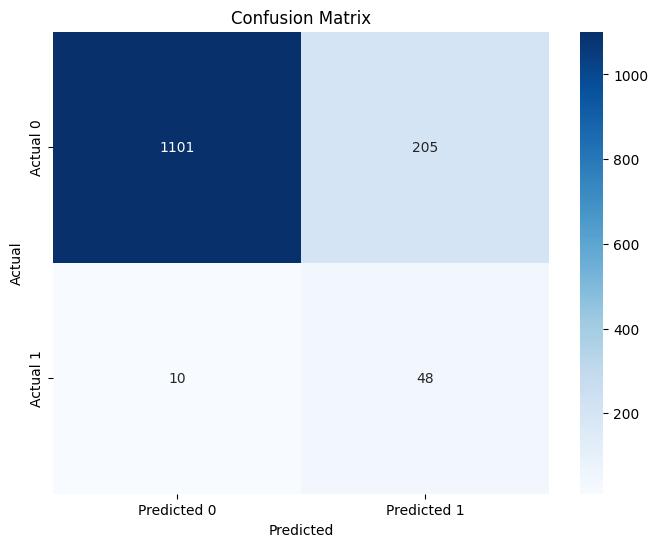

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1101 / 1306 = 84.30%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.83      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.2DO_1698265698
Epoch 1/200
34/34 [==============================] - 4s 63ms/step - loss: 0.5247 - accuracy: 0.7733 - val_loss: 0.3655 - val_accuracy: 0.9113
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3644 - accuracy: 0.8469 - val_loss: 0.4161 - val_accuracy: 0.8193
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3385 - accuracy: 0.8571 - val_loss: 0.4801 - val_accuracy: 0.8108
Epoch 4/200
34

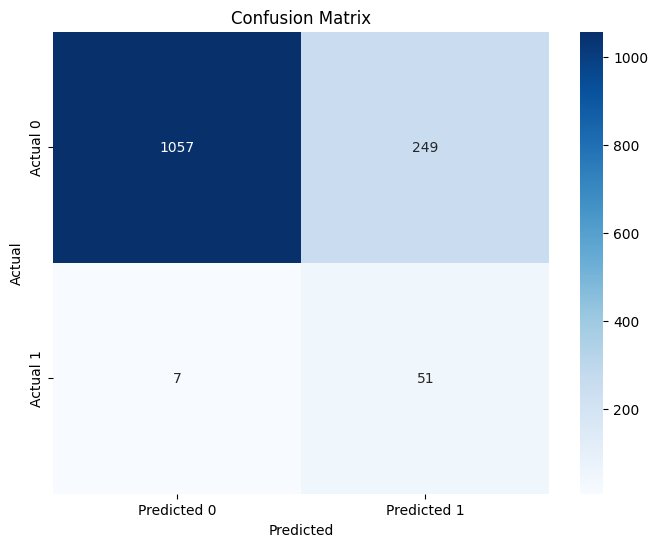

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1057 / 1306 = 80.93%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.28        58

    accuracy                           0.81      1364
   macro avg       0.58      0.84      0.59      1364
weighted avg       0.96      0.81      0.87      1364

FEA_EXT_DENSE_3Layers_64Size_0.15DO_1698265707
Epoch 1/200
34/34 [==============================] - 3s 50ms/step - loss: 0.4979 - accuracy: 0.7740 - val_loss: 0.3919 - val_accuracy: 0.8462
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3456 - accuracy: 0.8478 - val_loss: 0.4523 - val_accuracy: 0.8145
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3272 - accuracy: 0.8605 - val_loss: 0.4221 - val_accuracy: 0.8320
Epoch 4/200


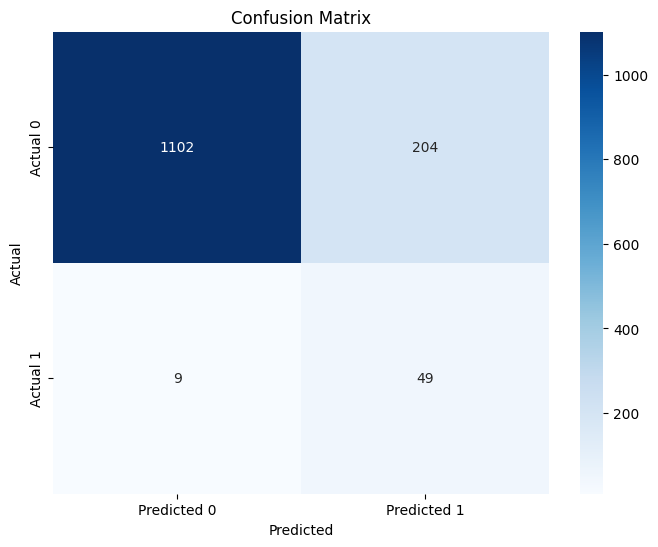

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1102 / 1306 = 84.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.84      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.1DO_1698265715
Epoch 1/200
34/34 [==============================] - 3s 68ms/step - loss: 0.4474 - accuracy: 0.8130 - val_loss: 0.4046 - val_accuracy: 0.8268
Epoch 2/200
34/34 [==============================] - 2s 57ms/step - loss: 0.3351 - accuracy: 0.8576 - val_loss: 0.3666 - val_accuracy: 0.8513
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3143 - accuracy: 0.8684 - val_loss: 0.3800 - val_accuracy: 0.8532
Epoch 4/200
3

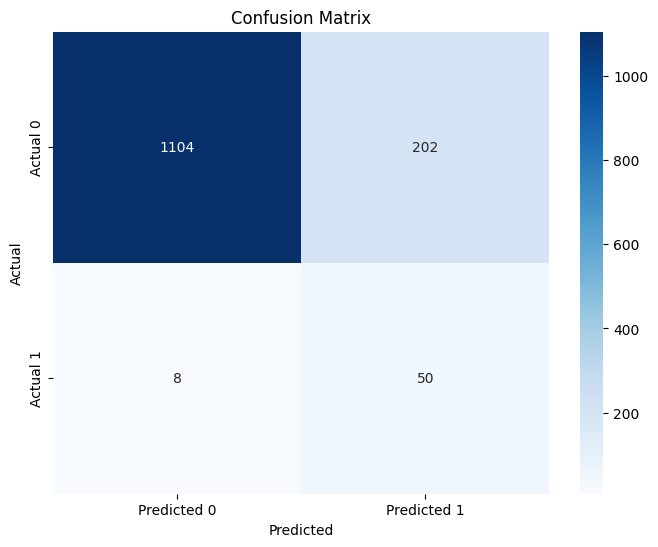

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1104 / 1306 = 84.53%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.20      0.86      0.32        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.2DO_1698265723
Epoch 1/200
34/34 [==============================] - 3s 47ms/step - loss: 0.5141 - accuracy: 0.7734 - val_loss: 0.3626 - val_accuracy: 0.8551
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3485 - accuracy: 0.8565 - val_loss: 0.3941 - val_accuracy: 0.8202
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3211 - accuracy: 0.8682 - val_loss: 0.4329 - val_accuracy: 0.8240
Epoch 4/200


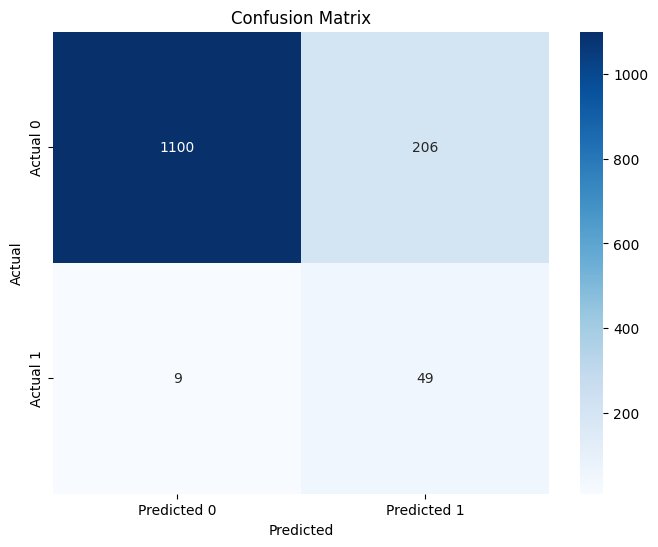

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1100 / 1306 = 84.23%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.84      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.15DO_1698265732
Epoch 1/200
34/34 [==============================] - 7s 109ms/step - loss: 0.4572 - accuracy: 0.8101 - val_loss: 0.3227 - val_accuracy: 0.8485
Epoch 2/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3340 - accuracy: 0.8565 - val_loss: 0.3290 - val_accuracy: 0.8773
Epoch 3/200
34/34 [==============================] - 1s 20ms/step - loss: 0.3183 - accuracy: 0.8646 - val_loss: 0.4791 - val_accuracy: 0.8098
Epoch 4/20

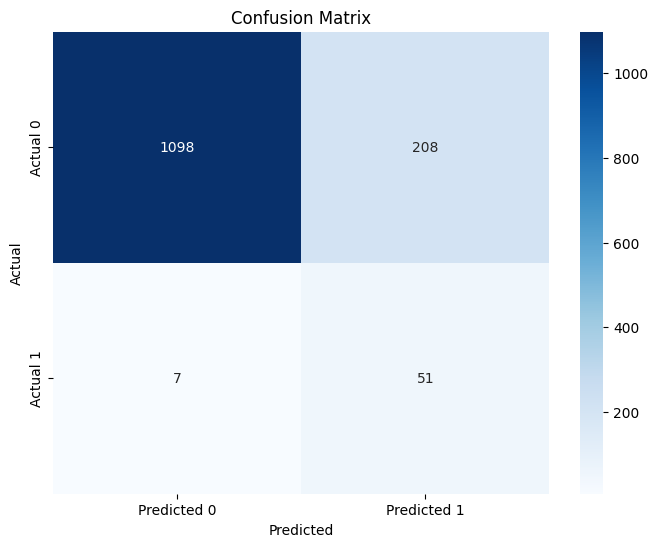

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1098 / 1306 = 84.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.20      0.88      0.32        58

    accuracy                           0.84      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.1DO_1698265748
Epoch 1/200
34/34 [==============================] - 3s 49ms/step - loss: 0.4514 - accuracy: 0.8112 - val_loss: 0.3504 - val_accuracy: 0.8377
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3254 - accuracy: 0.8638 - val_loss: 0.4258 - val_accuracy: 0.8244
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3065 - accuracy: 0.8702 - val_loss: 0.3888 - val_accuracy: 0.8410
Epoch 4/200


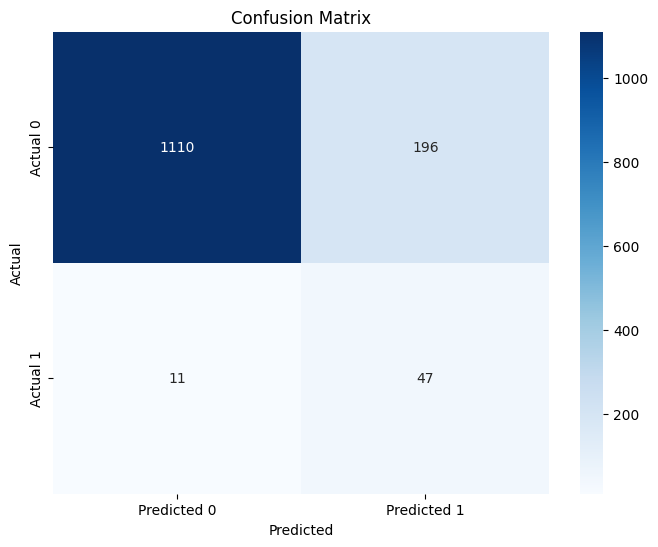

------------------------------
Percentage of positive (1) predicted correctly: 47 / 58 = 81.03%
Percentage of negative (0) predicted correctly: 1110 / 1306 = 84.99%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.19      0.81      0.31        58

    accuracy                           0.85      1364
   macro avg       0.59      0.83      0.61      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.2DO_1698265756
Epoch 1/200
33/34 [============================>.] - ETA: 0s - loss: 0.4748 - accuracy: 0.7882

34/34 [==============================] - 6s 143ms/step - loss: 0.4746 - accuracy: 0.7883 - val_loss: 0.4064 - val_accuracy: 0.8136
Epoch 2/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3396 - accuracy: 0.8510 - val_loss: 0.4127 - val_accuracy: 0.8315
Epoch 3/200
34/34 [==============================] - 2s 63ms/step - loss: 0.3203 - accuracy: 0.8664 - val_loss: 0.3702 - val_accuracy: 0.8598
Epoch 4/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3104 - accuracy: 0.8722 - val_loss: 0.4076 - val_accuracy: 0.8561
Epoch 5/200
34/34 [==============================] - 1s 16ms/step - loss: 0.2990 - accuracy: 0.8750 - val_loss: 0.4409 - val_accuracy: 0.8429
Epoch 6/200
34/34 [==============================] - 0s 13ms/step - loss: 0.2928 - accuracy: 0.8770 - val_loss: 0.4879 - val_accuracy: 0.8277
Epoch 7/200
34/34 [==============================] - 1s 19ms/step - loss: 0.2852 - accuracy: 0.8807 - val_loss: 0.5127 - val_accuracy: 0.8188
Epoch 7: early st

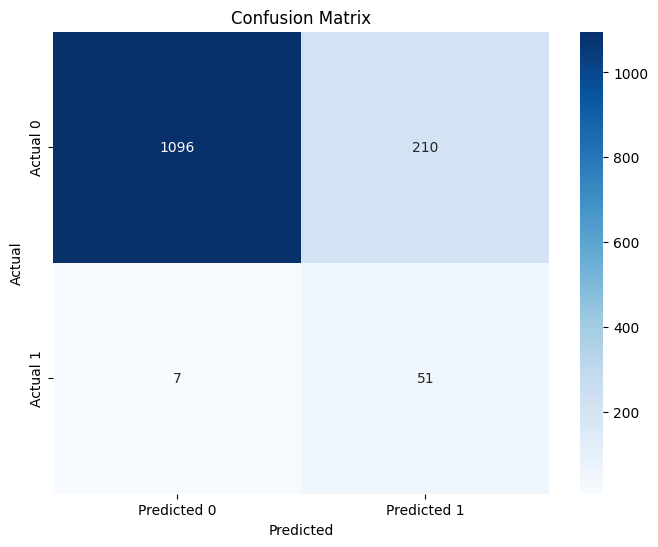

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1096 / 1306 = 83.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.20      0.88      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_64Size_0.15DO_1698265771
Epoch 1/200
34/34 [==============================] - 7s 96ms/step - loss: 0.4566 - accuracy: 0.8105 - val_loss: 0.3480 - val_accuracy: 0.8495
Epoch 2/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3400 - accuracy: 0.8524 - val_loss: 0.3770 - val_accuracy: 0.8499
Epoch 3/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3199 - accuracy: 0.8663 - val_loss: 0.5037 - val_accuracy: 0.7862
Epoch 4/200

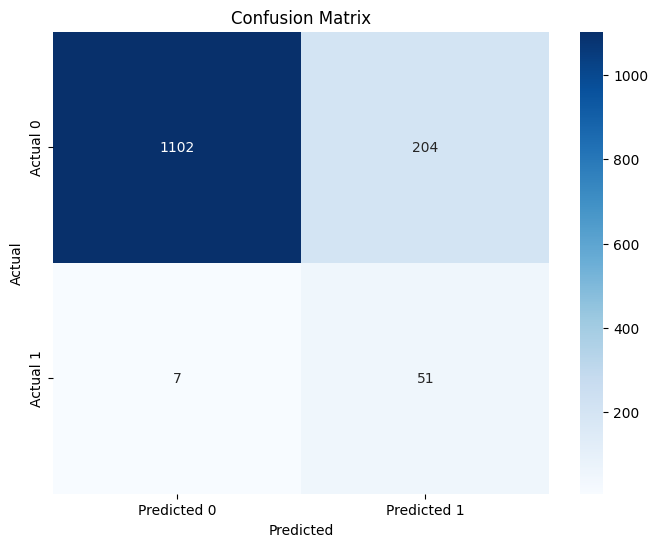

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1102 / 1306 = 84.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.20      0.88      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.1DO_1698265783
Epoch 1/200
34/34 [==============================] - 5s 100ms/step - loss: 0.4639 - accuracy: 0.8074 - val_loss: 0.4219 - val_accuracy: 0.8089
Epoch 2/200
34/34 [==============================] - 3s 103ms/step - loss: 0.3339 - accuracy: 0.8547 - val_loss: 0.4032 - val_accuracy: 0.8372
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3132 - accuracy: 0.8677 - val_loss: 0.4184 - val_accuracy: 0.8419
Epoch 4/20

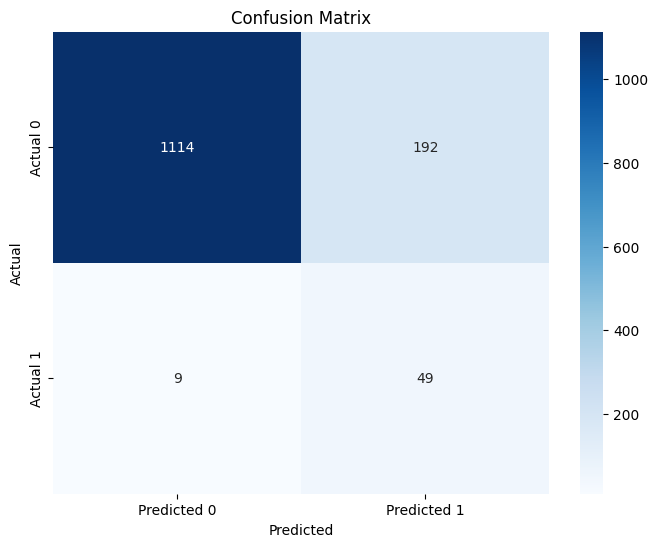

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1114 / 1306 = 85.30%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.84      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.2DO_1698265797
Epoch 1/200
34/34 [==============================] - 3s 51ms/step - loss: 0.4801 - accuracy: 0.7897 - val_loss: 0.3377 - val_accuracy: 0.8381
Epoch 2/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3439 - accuracy: 0.8532 - val_loss: 0.3524 - val_accuracy: 0.8504
Epoch 3/200
34/34 [==============================] - 1s 19ms/step - loss: 0.3223 - accuracy: 0.8632 - val_loss: 0.4015 - val_accuracy: 0.8395
Epoch 4/200


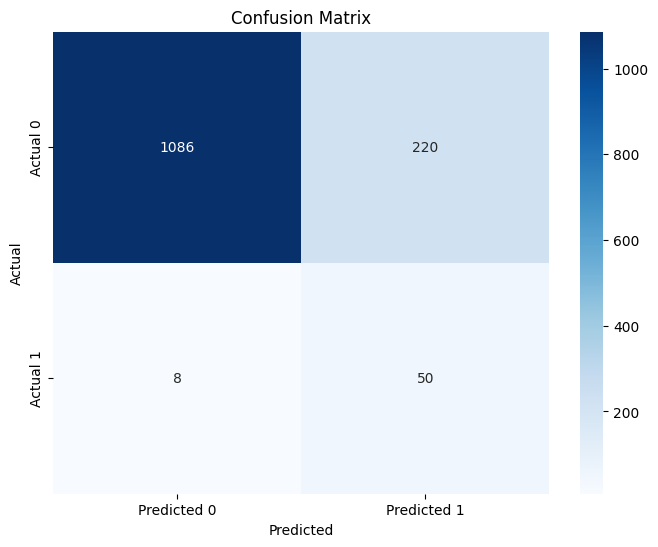

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1086 / 1306 = 83.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.86      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_64Size_0.15DO_1698265806
Epoch 1/200
34/34 [==============================] - 6s 85ms/step - loss: 0.4551 - accuracy: 0.7979 - val_loss: 0.3370 - val_accuracy: 0.8580
Epoch 2/200
34/34 [==============================] - 1s 18ms/step - loss: 0.3289 - accuracy: 0.8592 - val_loss: 0.4507 - val_accuracy: 0.8169
Epoch 3/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3155 - accuracy: 0.8683 - val_loss: 0.4642 - val_accuracy: 0.8178
Epoch 4/200

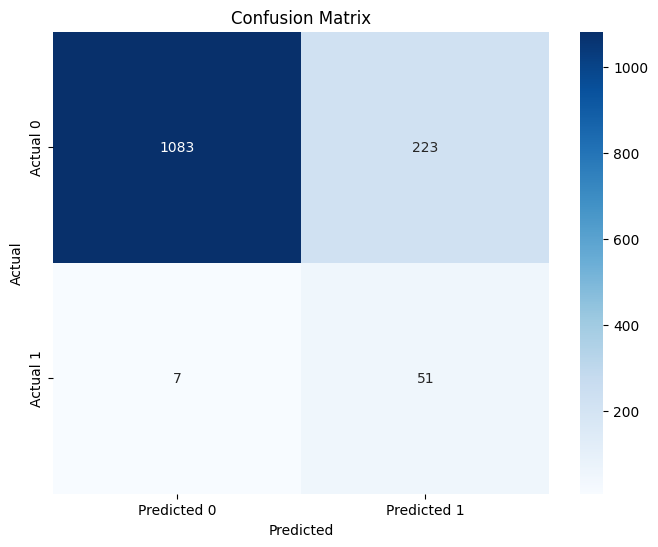

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1083 / 1306 = 82.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1306
           1       0.19      0.88      0.31        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_64Size_0.1DO_1698265822
Epoch 1/200
34/34 [==============================] - 4s 58ms/step - loss: 0.4639 - accuracy: 0.7918 - val_loss: 0.3608 - val_accuracy: 0.8391
Epoch 2/200
34/34 [==============================] - 1s 45ms/step - loss: 0.3278 - accuracy: 0.8630 - val_loss: 0.3600 - val_accuracy: 0.8433
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3131 - accuracy: 0.8679 - val_loss: 0.4491 - val_accuracy: 0.8155
Epoch 4/200


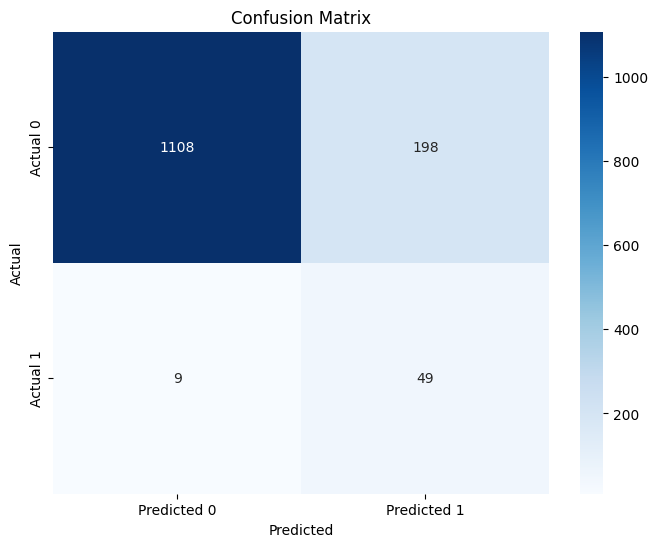

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1108 / 1306 = 84.84%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.20      0.84      0.32        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_64Size_0.2DO_1698265836
Epoch 1/200
34/34 [==============================] - 4s 78ms/step - loss: 0.4786 - accuracy: 0.7833 - val_loss: 0.3515 - val_accuracy: 0.8259
Epoch 2/200
34/34 [==============================] - 1s 32ms/step - loss: 0.3452 - accuracy: 0.8587 - val_loss: 0.4065 - val_accuracy: 0.8273
Epoch 3/200
34/34 [==============================] - 1s 37ms/step - loss: 0.3201 - accuracy: 0.8665 - val_loss: 0.3969 - val_accuracy: 0.8386
Epoch 4/200


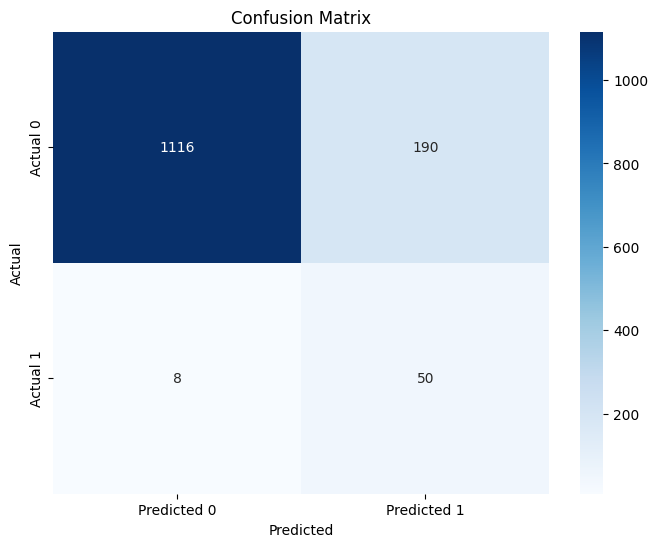

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1116 / 1306 = 85.45%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.21      0.86      0.34        58

    accuracy                           0.85      1364
   macro avg       0.60      0.86      0.63      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.15DO_1698265848
Epoch 1/200
34/34 [==============================] - 8s 106ms/step - loss: 0.5657 - accuracy: 0.7229 - val_loss: 0.3666 - val_accuracy: 0.8815
Epoch 2/200
34/34 [==============================] - 3s 78ms/step - loss: 0.3733 - accuracy: 0.8528 - val_loss: 0.3352 - val_accuracy: 0.8320
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3319 - accuracy: 0.8624 - val_loss: 0.3809 - val_accuracy: 0.8386
Epoch 4/20

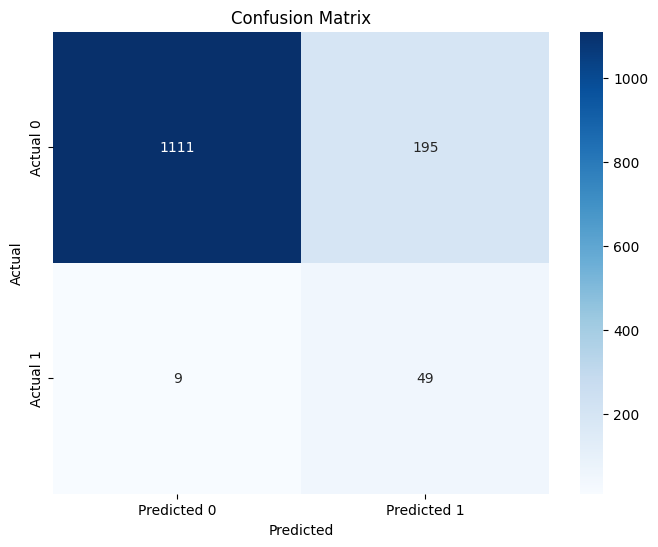

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1111 / 1306 = 85.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.84      0.32        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.1DO_1698265867
Epoch 1/200
33/34 [============================>.] - ETA: 0s - loss: 0.5219 - accuracy: 0.7790

34/34 [==============================] - 7s 168ms/step - loss: 0.5213 - accuracy: 0.7794 - val_loss: 0.3681 - val_accuracy: 0.8721
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3459 - accuracy: 0.8570 - val_loss: 0.4349 - val_accuracy: 0.8117
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3173 - accuracy: 0.8721 - val_loss: 0.4822 - val_accuracy: 0.7952
Epoch 4/200
34/34 [==============================] - 1s 19ms/step - loss: 0.3036 - accuracy: 0.8722 - val_loss: 0.4547 - val_accuracy: 0.8103
Epoch 5/200
34/34 [==============================] - 0s 14ms/step - loss: 0.2949 - accuracy: 0.8773 - val_loss: 0.4823 - val_accuracy: 0.8046
Epoch 5: early stopping
loaded
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 96)                1344      
                                                 

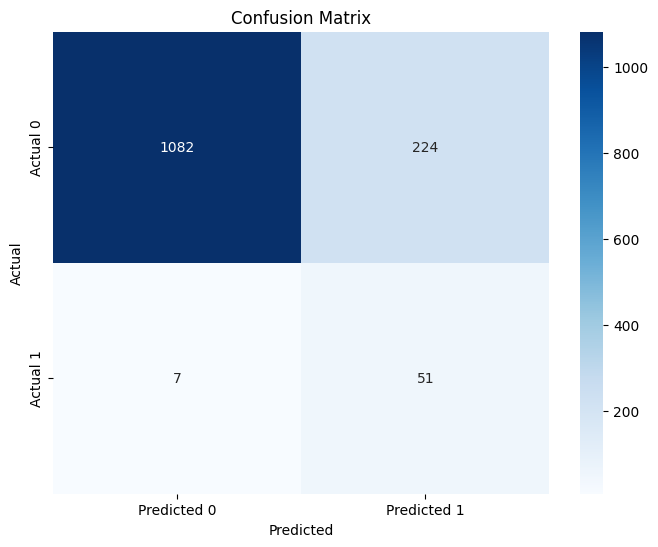

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1082 / 1306 = 82.85%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1306
           1       0.19      0.88      0.31        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_96Size_0.2DO_1698265883
Epoch 1/200
34/34 [==============================] - 5s 84ms/step - loss: 0.5446 - accuracy: 0.7608 - val_loss: 0.3403 - val_accuracy: 0.9193
Epoch 2/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3645 - accuracy: 0.8527 - val_loss: 0.3691 - val_accuracy: 0.8466
Epoch 3/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3294 - accuracy: 0.8652 - val_loss: 0.4662 - val_accuracy: 0.8174
Epoch 4/200


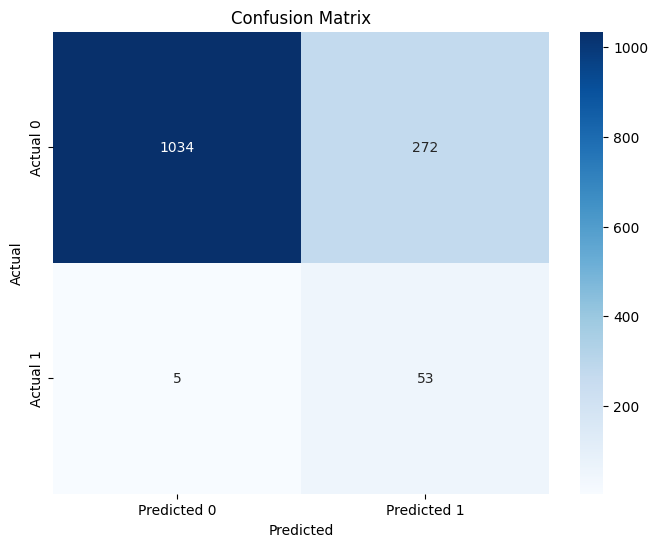

------------------------------
Percentage of positive (1) predicted correctly: 53 / 58 = 91.38%
Percentage of negative (0) predicted correctly: 1034 / 1306 = 79.17%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88      1306
           1       0.16      0.91      0.28        58

    accuracy                           0.80      1364
   macro avg       0.58      0.85      0.58      1364
weighted avg       0.96      0.80      0.86      1364

FEA_EXT_DENSE_3Layers_96Size_0.15DO_1698265893
Epoch 1/200
34/34 [==============================] - 6s 78ms/step - loss: 0.4923 - accuracy: 0.8028 - val_loss: 0.3944 - val_accuracy: 0.8320
Epoch 2/200
34/34 [==============================] - 2s 46ms/step - loss: 0.3403 - accuracy: 0.8554 - val_loss: 0.3623 - val_accuracy: 0.8452
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3170 - accuracy: 0.8642 - val_loss: 0.4436 - val_accuracy: 0.8230
Epoch 4/200

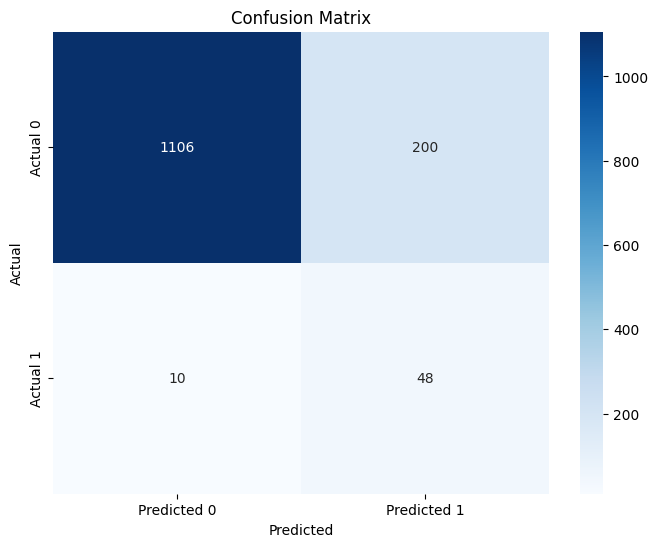

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1106 / 1306 = 84.69%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.19      0.83      0.31        58

    accuracy                           0.85      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.1DO_1698265908
Epoch 1/200
34/34 [==============================] - 7s 110ms/step - loss: 0.4977 - accuracy: 0.8059 - val_loss: 0.3381 - val_accuracy: 0.8716
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3305 - accuracy: 0.8602 - val_loss: 0.4000 - val_accuracy: 0.8372
Epoch 3/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3131 - accuracy: 0.8715 - val_loss: 0.3458 - val_accuracy: 0.8627
Epoch 4/200

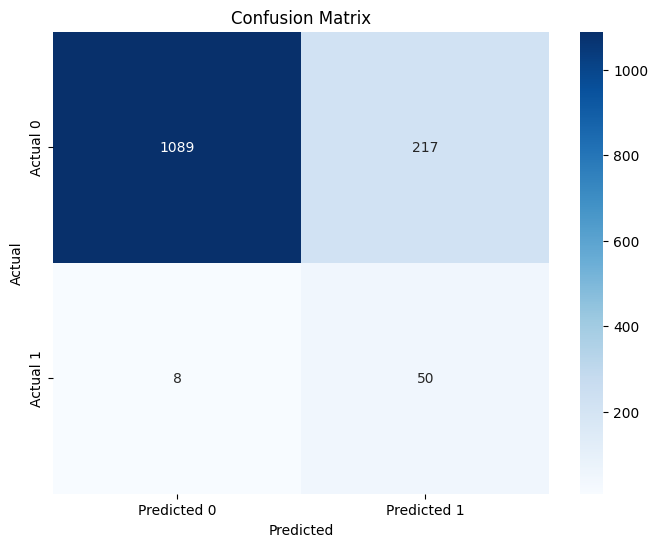

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1089 / 1306 = 83.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.86      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_96Size_0.2DO_1698265924
Epoch 1/200
34/34 [==============================] - 3s 50ms/step - loss: 0.5246 - accuracy: 0.7721 - val_loss: 0.3887 - val_accuracy: 0.8329
Epoch 2/200
34/34 [==============================] - 1s 45ms/step - loss: 0.3543 - accuracy: 0.8526 - val_loss: 0.3690 - val_accuracy: 0.8452
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.3279 - accuracy: 0.8631 - val_loss: 0.4191 - val_accuracy: 0.8353
Epoch 4/200
3

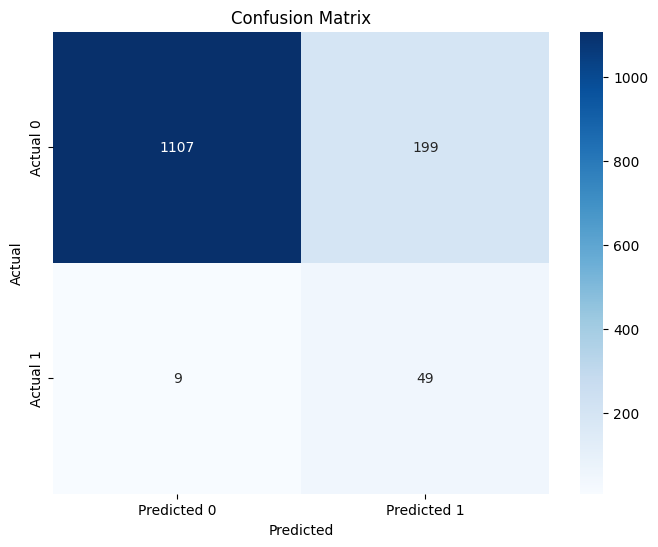

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1107 / 1306 = 84.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.20      0.84      0.32        58

    accuracy                           0.85      1364
   macro avg       0.59      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.15DO_1698265932
Epoch 1/200
34/34 [==============================] - 6s 134ms/step - loss: 0.5048 - accuracy: 0.7757 - val_loss: 0.3791 - val_accuracy: 0.8617
Epoch 2/200
34/34 [==============================] - 1s 25ms/step - loss: 0.3416 - accuracy: 0.8534 - val_loss: 0.4214 - val_accuracy: 0.8230
Epoch 3/200
34/34 [==============================] - 1s 20ms/step - loss: 0.3148 - accuracy: 0.8691 - val_loss: 0.4078 - val_accuracy: 0.8301
Epoch 4/20

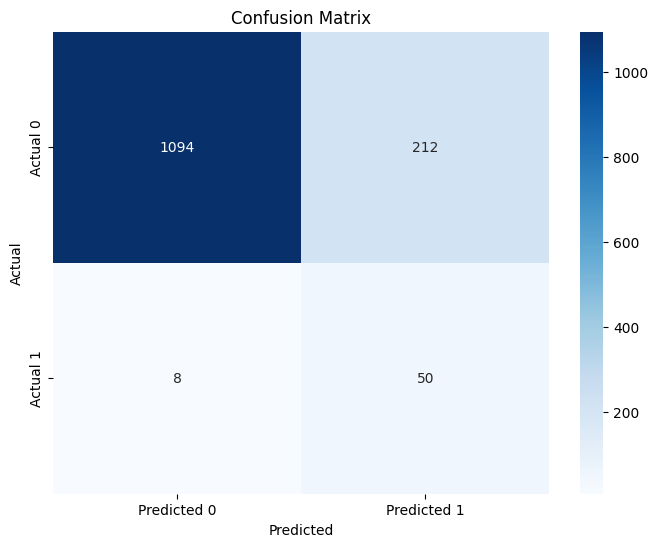

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1094 / 1306 = 83.77%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.86      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_96Size_0.1DO_1698265946
Epoch 1/200
34/34 [==============================] - 6s 103ms/step - loss: 0.5146 - accuracy: 0.7844 - val_loss: 0.3838 - val_accuracy: 0.8542
Epoch 2/200
34/34 [==============================] - 2s 66ms/step - loss: 0.3401 - accuracy: 0.8583 - val_loss: 0.3754 - val_accuracy: 0.8377
Epoch 3/200
34/34 [==============================] - 1s 16ms/step - loss: 0.3168 - accuracy: 0.8700 - val_loss: 0.3902 - val_accuracy: 0.8353
Epoch 4/200

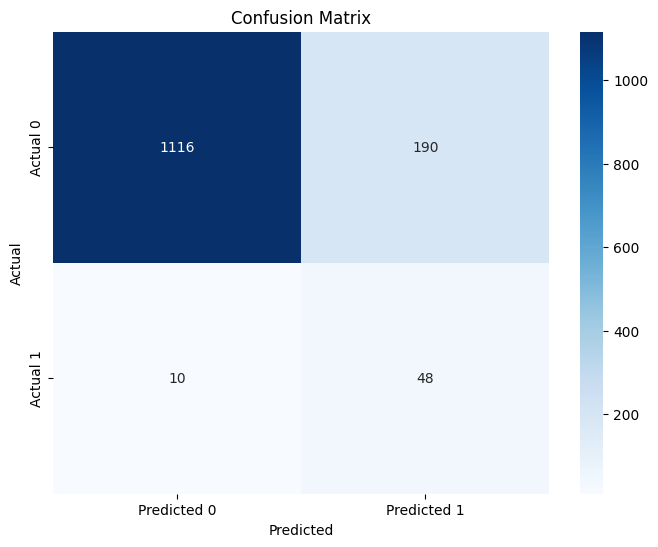

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1116 / 1306 = 85.45%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.83      0.32        58

    accuracy                           0.85      1364
   macro avg       0.60      0.84      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.2DO_1698265959
Epoch 1/200
34/34 [==============================] - 6s 134ms/step - loss: 0.5007 - accuracy: 0.7783 - val_loss: 0.3202 - val_accuracy: 0.9004
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3530 - accuracy: 0.8527 - val_loss: 0.3704 - val_accuracy: 0.8650
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3238 - accuracy: 0.8664 - val_loss: 0.4217 - val_accuracy: 0.8320
Epoch 4/200

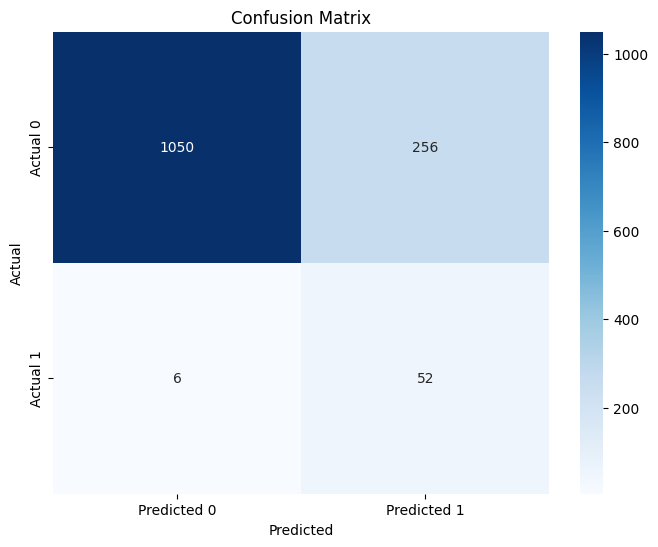

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 1050 / 1306 = 80.40%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      1306
           1       0.17      0.90      0.28        58

    accuracy                           0.81      1364
   macro avg       0.58      0.85      0.59      1364
weighted avg       0.96      0.81      0.86      1364

FEA_EXT_DENSE_3Layers_96Size_0.15DO_1698265971
Epoch 1/200
34/34 [==============================] - 3s 51ms/step - loss: 0.4703 - accuracy: 0.7994 - val_loss: 0.2891 - val_accuracy: 0.8952
Epoch 2/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3350 - accuracy: 0.8583 - val_loss: 0.4172 - val_accuracy: 0.8292
Epoch 3/200
34/34 [==============================] - 1s 30ms/step - loss: 0.3139 - accuracy: 0.8683 - val_loss: 0.4599 - val_accuracy: 0.8188
Epoch 4/200

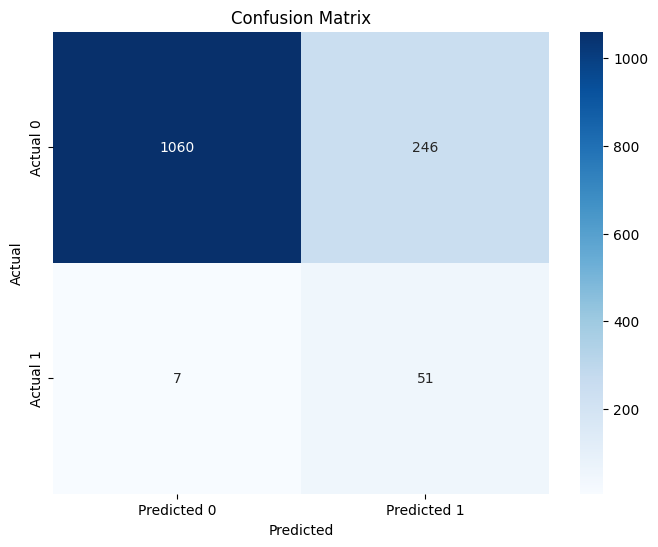

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1060 / 1306 = 81.16%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.88      0.29        58

    accuracy                           0.81      1364
   macro avg       0.58      0.85      0.59      1364
weighted avg       0.96      0.81      0.87      1364

FEA_EXT_DENSE_3Layers_96Size_0.1DO_1698265978
Epoch 1/200
32/34 [===========================>..] - ETA: 0s - loss: 0.4801 - accuracy: 0.7922

34/34 [==============================] - 7s 155ms/step - loss: 0.4749 - accuracy: 0.7940 - val_loss: 0.3480 - val_accuracy: 0.8424
Epoch 2/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3291 - accuracy: 0.8605 - val_loss: 0.3721 - val_accuracy: 0.8575
Epoch 3/200
34/34 [==============================] - 1s 16ms/step - loss: 0.3138 - accuracy: 0.8676 - val_loss: 0.4745 - val_accuracy: 0.8112
Epoch 4/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3044 - accuracy: 0.8738 - val_loss: 0.4182 - val_accuracy: 0.8419
Epoch 5/200
34/34 [==============================] - 1s 18ms/step - loss: 0.2939 - accuracy: 0.8767 - val_loss: 0.3967 - val_accuracy: 0.8561
Epoch 5: early stopping
loaded
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 96)                1344      
                                                 

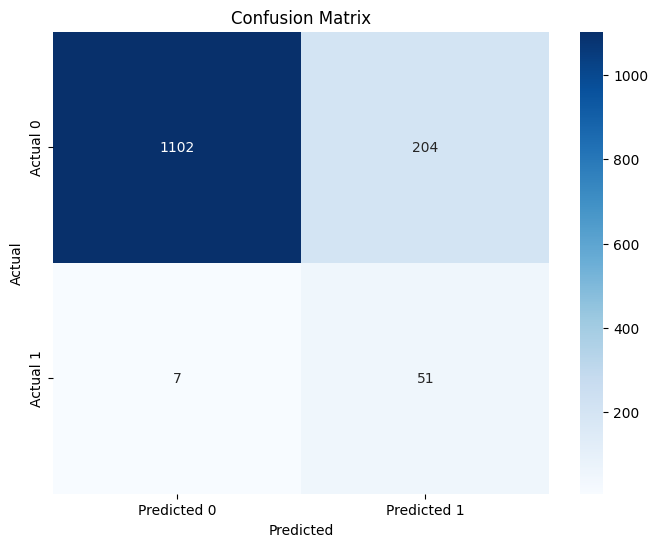

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1102 / 1306 = 84.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.20      0.88      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.2DO_1698265989
Epoch 1/200
34/34 [==============================] - 5s 81ms/step - loss: 0.4829 - accuracy: 0.7844 - val_loss: 0.3981 - val_accuracy: 0.8235
Epoch 2/200
34/34 [==============================] - 4s 123ms/step - loss: 0.3400 - accuracy: 0.8576 - val_loss: 0.3715 - val_accuracy: 0.8542
Epoch 3/200
34/34 [==============================] - 1s 29ms/step - loss: 0.3175 - accuracy: 0.8672 - val_loss: 0.4198 - val_accuracy: 0.8372
Epoch 4/200

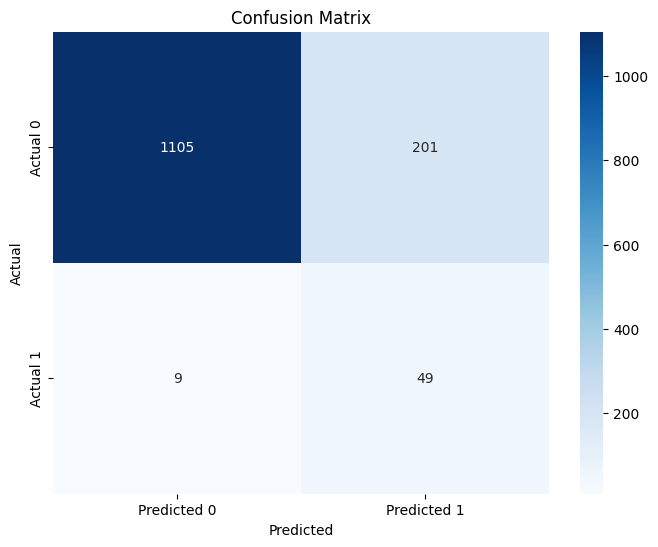

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1105 / 1306 = 84.61%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1306
           1       0.20      0.84      0.32        58

    accuracy                           0.85      1364
   macro avg       0.59      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.15DO_1698266017
Epoch 1/200
34/34 [==============================] - 5s 96ms/step - loss: 0.4818 - accuracy: 0.7877 - val_loss: 0.3131 - val_accuracy: 0.8664
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3396 - accuracy: 0.8583 - val_loss: 0.3465 - val_accuracy: 0.8537
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3152 - accuracy: 0.8687 - val_loss: 0.4455 - val_accuracy: 0.8183
Epoch 4/200

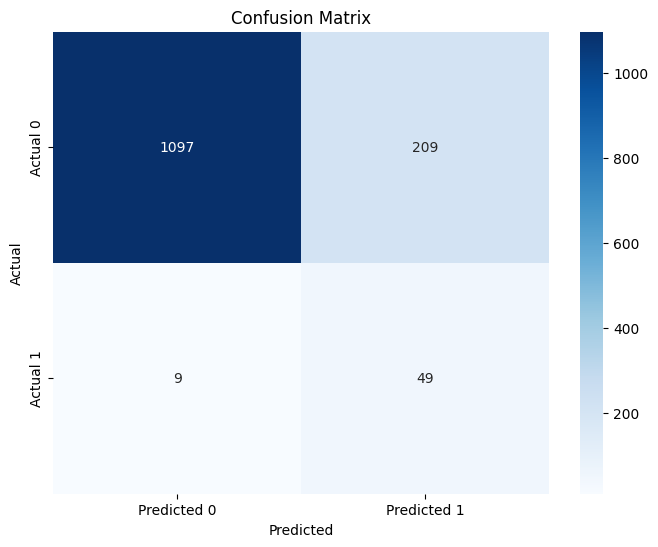

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1097 / 1306 = 84.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.84      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_96Size_0.1DO_1698266026
Epoch 1/200
34/34 [==============================] - 3s 63ms/step - loss: 0.4904 - accuracy: 0.7760 - val_loss: 0.2832 - val_accuracy: 0.8726
Epoch 2/200
34/34 [==============================] - 1s 19ms/step - loss: 0.3333 - accuracy: 0.8624 - val_loss: 0.4284 - val_accuracy: 0.8216
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3092 - accuracy: 0.8729 - val_loss: 0.4725 - val_accuracy: 0.8056
Epoch 4/200


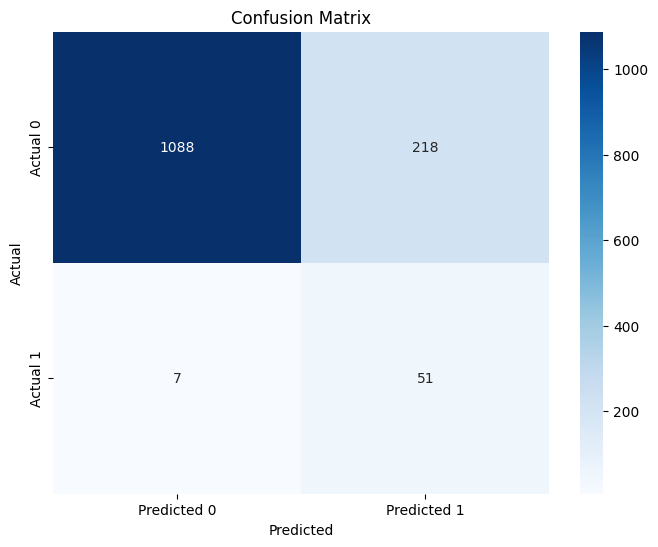

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1088 / 1306 = 83.31%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.88      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_96Size_0.2DO_1698266035
Epoch 1/200
34/34 [==============================] - 6s 74ms/step - loss: 0.4654 - accuracy: 0.7942 - val_loss: 0.3700 - val_accuracy: 0.8344
Epoch 2/200
34/34 [==============================] - 1s 20ms/step - loss: 0.3394 - accuracy: 0.8613 - val_loss: 0.4220 - val_accuracy: 0.8320
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3196 - accuracy: 0.8718 - val_loss: 0.4251 - val_accuracy: 0.8362
Epoch 4/200


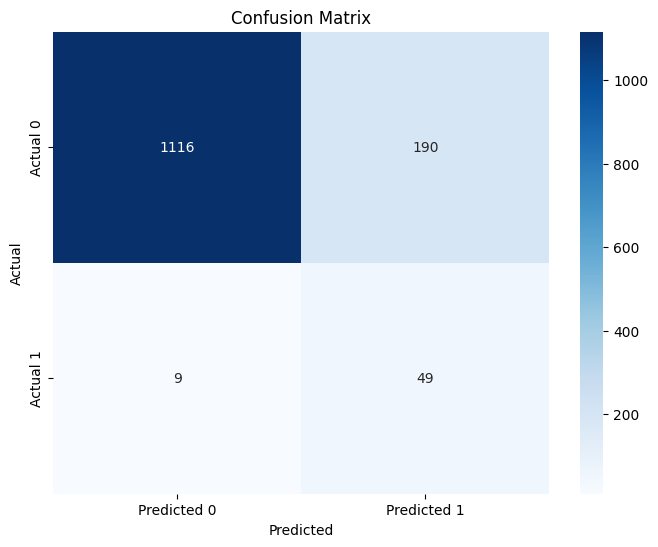

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1116 / 1306 = 85.45%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.21      0.84      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.85      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.15DO_1698266047
Epoch 1/200
34/34 [==============================] - 6s 131ms/step - loss: 0.4325 - accuracy: 0.8212 - val_loss: 0.3318 - val_accuracy: 0.8476
Epoch 2/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3275 - accuracy: 0.8656 - val_loss: 0.3786 - val_accuracy: 0.8443
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3039 - accuracy: 0.8727 - val_loss: 0.5386 - val_accuracy: 0.7820
Epoch 4/20

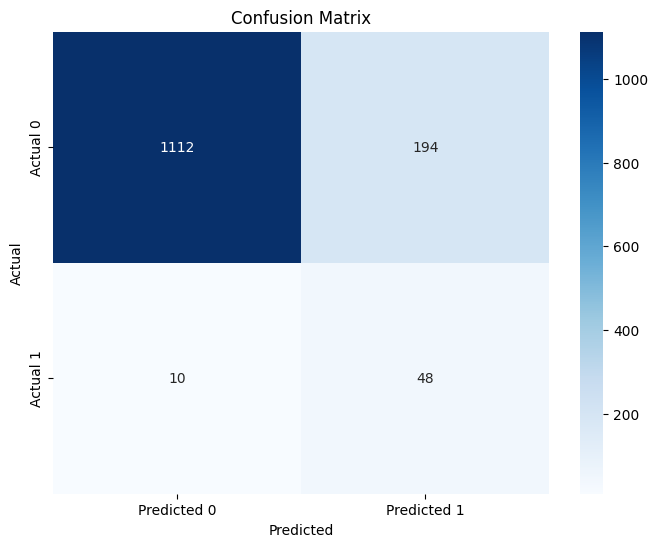

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1112 / 1306 = 85.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.83      0.32        58

    accuracy                           0.85      1364
   macro avg       0.59      0.84      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.1DO_1698266061
Epoch 1/200
34/34 [==============================] - 7s 89ms/step - loss: 0.4248 - accuracy: 0.8241 - val_loss: 0.3138 - val_accuracy: 0.8712
Epoch 2/200
34/34 [==============================] - 1s 23ms/step - loss: 0.3165 - accuracy: 0.8646 - val_loss: 0.4058 - val_accuracy: 0.8306
Epoch 3/200
34/34 [==============================] - 1s 20ms/step - loss: 0.2997 - accuracy: 0.8750 - val_loss: 0.5131 - val_accuracy: 0.7853
Epoch 4/200


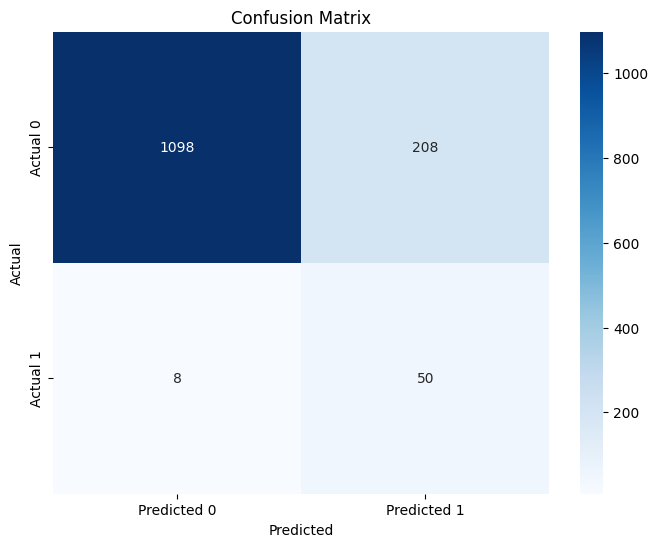

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1098 / 1306 = 84.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.86      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_96Size_0.2DO_1698266073
Epoch 1/200
34/34 [==============================] - 5s 95ms/step - loss: 0.4438 - accuracy: 0.8144 - val_loss: 0.3202 - val_accuracy: 0.8679
Epoch 2/200
34/34 [==============================] - 1s 21ms/step - loss: 0.3308 - accuracy: 0.8616 - val_loss: 0.3615 - val_accuracy: 0.8716
Epoch 3/200
34/34 [==============================] - 1s 18ms/step - loss: 0.3099 - accuracy: 0.8694 - val_loss: 0.4030 - val_accuracy: 0.8447
Epoch 4/200


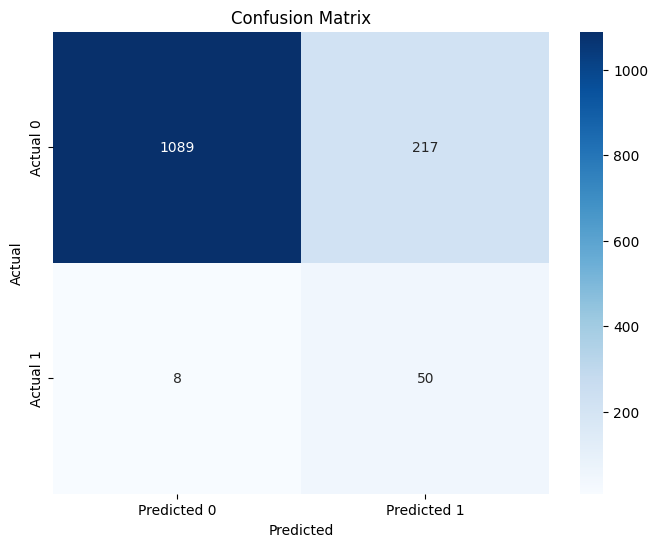

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1089 / 1306 = 83.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.86      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_128Size_0.15DO_1698266083
Epoch 1/200
34/34 [==============================] - 5s 72ms/step - loss: 0.5067 - accuracy: 0.7853 - val_loss: 0.3439 - val_accuracy: 0.8797
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3446 - accuracy: 0.8537 - val_loss: 0.3889 - val_accuracy: 0.8386
Epoch 3/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3214 - accuracy: 0.8659 - val_loss: 0.4012 - val_accuracy: 0.8485
Epoch 4/20

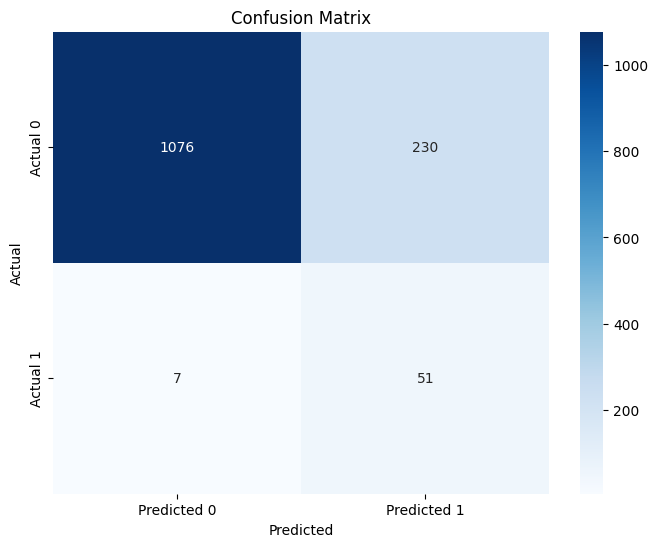

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1076 / 1306 = 82.39%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1306
           1       0.18      0.88      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.85      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_128Size_0.1DO_1698266096
Epoch 1/200
34/34 [==============================] - 5s 75ms/step - loss: 0.5044 - accuracy: 0.7831 - val_loss: 0.3249 - val_accuracy: 0.8731
Epoch 2/200
34/34 [==============================] - 1s 17ms/step - loss: 0.3426 - accuracy: 0.8610 - val_loss: 0.4808 - val_accuracy: 0.7787
Epoch 3/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3157 - accuracy: 0.8722 - val_loss: 0.4341 - val_accuracy: 0.8145
Epoch 4/200

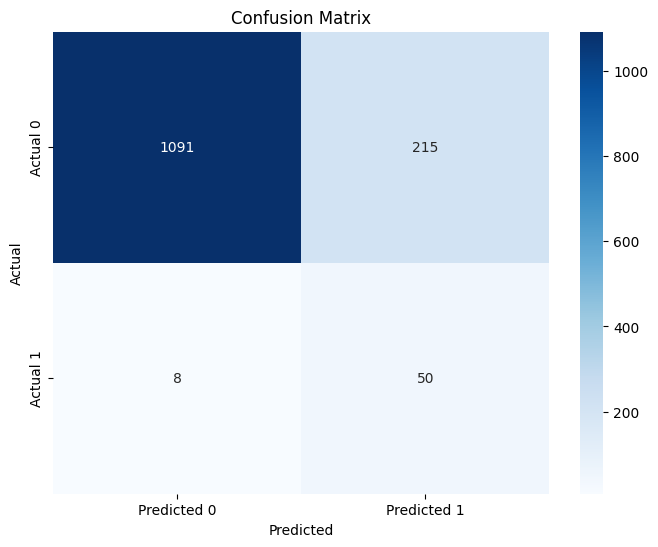

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1091 / 1306 = 83.54%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.86      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_128Size_0.2DO_1698266107
Epoch 1/200
34/34 [==============================] - 6s 106ms/step - loss: 0.5808 - accuracy: 0.7155 - val_loss: 0.3470 - val_accuracy: 0.8863
Epoch 2/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3702 - accuracy: 0.8467 - val_loss: 0.3837 - val_accuracy: 0.8480
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3289 - accuracy: 0.8661 - val_loss: 0.4485 - val_accuracy: 0.8329
Epoch 4/20

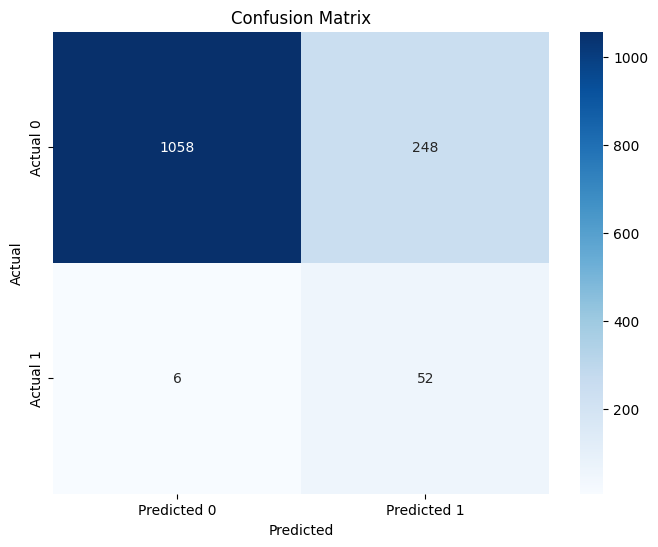

------------------------------
Percentage of positive (1) predicted correctly: 52 / 58 = 89.66%
Percentage of negative (0) predicted correctly: 1058 / 1306 = 81.01%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1306
           1       0.17      0.90      0.29        58

    accuracy                           0.81      1364
   macro avg       0.58      0.85      0.59      1364
weighted avg       0.96      0.81      0.87      1364

FEA_EXT_DENSE_3Layers_128Size_0.15DO_1698266122


Epoch 1/200
34/34 [==============================] - 5s 61ms/step - loss: 0.5053 - accuracy: 0.7763 - val_loss: 0.3360 - val_accuracy: 0.8556
Epoch 2/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3453 - accuracy: 0.8610 - val_loss: 0.4575 - val_accuracy: 0.8008
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3146 - accuracy: 0.8701 - val_loss: 0.4328 - val_accuracy: 0.8282
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 0.3074 - accuracy: 0.8737 - val_loss: 0.4489 - val_accuracy: 0.8259
Epoch 5/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3025 - accuracy: 0.8727 - val_loss: 0.4457 - val_accuracy: 0.8414
Epoch 5: early stopping
loaded
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_340 (Dense)           (None, 128)               1792      
                                      

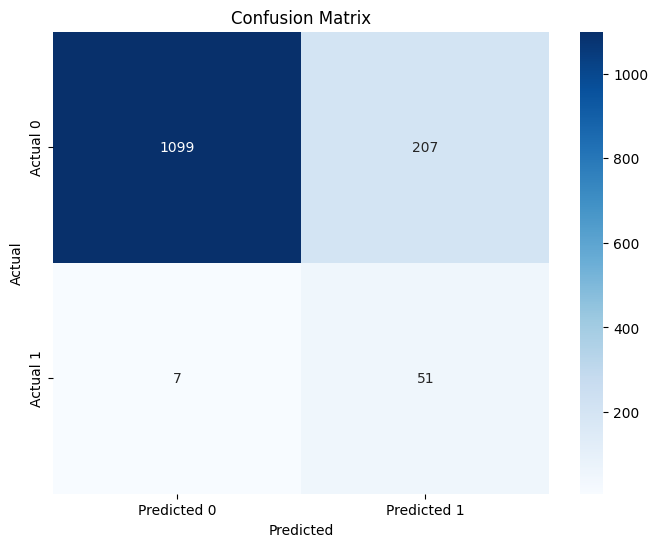

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1099 / 1306 = 84.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.20      0.88      0.32        58

    accuracy                           0.84      1364
   macro avg       0.60      0.86      0.62      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.1DO_1698266135
Epoch 1/200
34/34 [==============================] - 4s 74ms/step - loss: 0.4911 - accuracy: 0.8098 - val_loss: 0.3912 - val_accuracy: 0.8117
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3268 - accuracy: 0.8603 - val_loss: 0.4228 - val_accuracy: 0.8164
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3072 - accuracy: 0.8751 - val_loss: 0.4629 - val_accuracy: 0.8056
Epoch 4/200

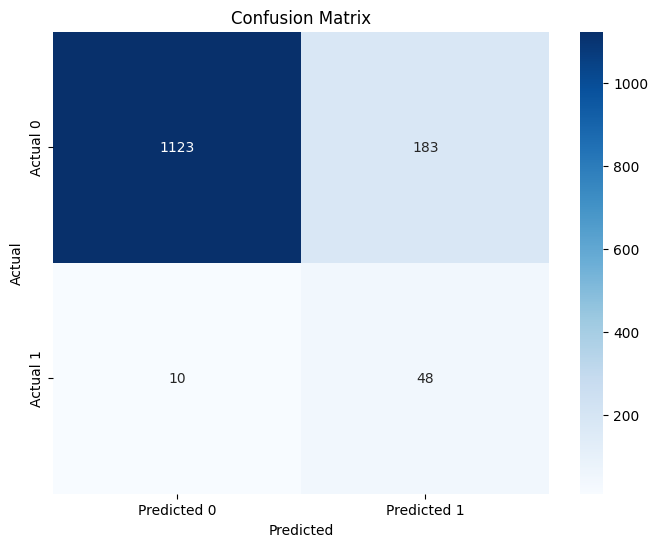

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1123 / 1306 = 85.99%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.83      0.33        58

    accuracy                           0.86      1364
   macro avg       0.60      0.84      0.63      1364
weighted avg       0.96      0.86      0.90      1364

FEA_EXT_DENSE_3Layers_128Size_0.2DO_1698266143
Epoch 1/200
34/34 [==============================] - 3s 54ms/step - loss: 0.5468 - accuracy: 0.7427 - val_loss: 0.3665 - val_accuracy: 0.8537
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3503 - accuracy: 0.8582 - val_loss: 0.3894 - val_accuracy: 0.8443
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3198 - accuracy: 0.8674 - val_loss: 0.3892 - val_accuracy: 0.8598
Epoch 4/200

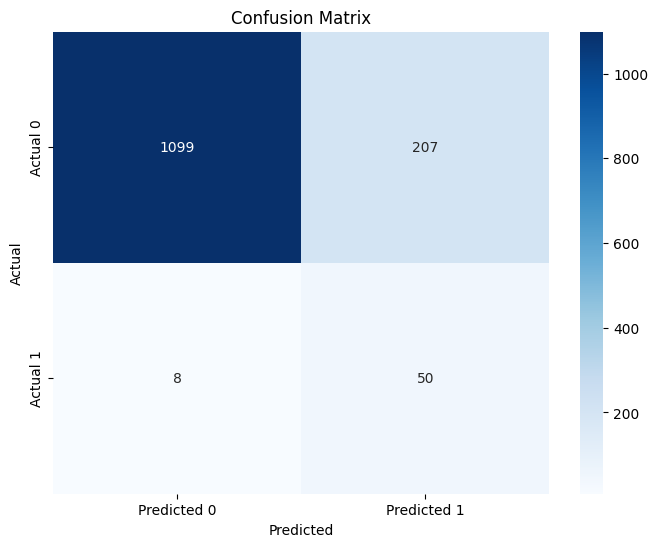

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1099 / 1306 = 84.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.86      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.15DO_1698266150
Epoch 1/200
34/34 [==============================] - 4s 72ms/step - loss: 0.5118 - accuracy: 0.7768 - val_loss: 0.3333 - val_accuracy: 0.8806
Epoch 2/200
34/34 [==============================] - 1s 15ms/step - loss: 0.3383 - accuracy: 0.8544 - val_loss: 0.3921 - val_accuracy: 0.8211
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3144 - accuracy: 0.8692 - val_loss: 0.4123 - val_accuracy: 0.8320
Epoch 4/20

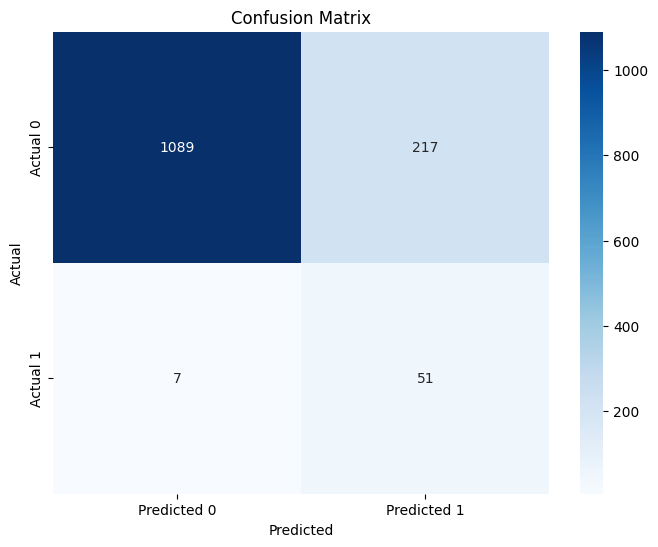

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1089 / 1306 = 83.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.88      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.86      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_128Size_0.1DO_1698266157
Epoch 1/200
34/34 [==============================] - 3s 49ms/step - loss: 0.4579 - accuracy: 0.8089 - val_loss: 0.3323 - val_accuracy: 0.8532
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3338 - accuracy: 0.8591 - val_loss: 0.4310 - val_accuracy: 0.8075
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3137 - accuracy: 0.8704 - val_loss: 0.3580 - val_accuracy: 0.8518
Epoch 4/200

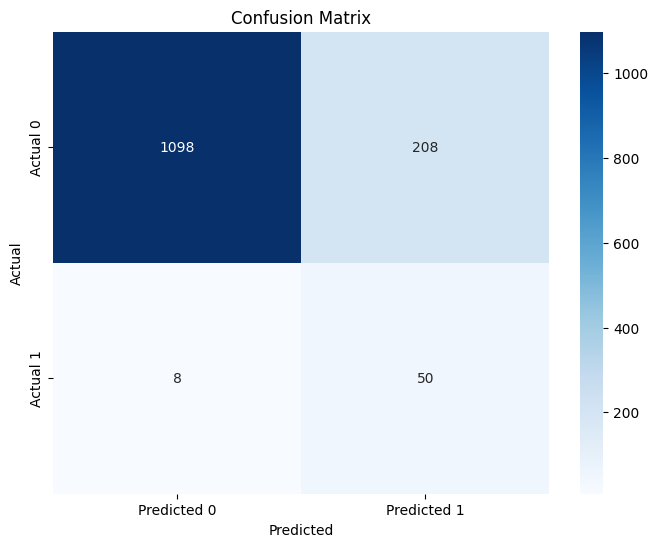

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1098 / 1306 = 84.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.86      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.2DO_1698266164
Epoch 1/200
34/34 [==============================] - 4s 71ms/step - loss: 0.5170 - accuracy: 0.7688 - val_loss: 0.3317 - val_accuracy: 0.8584
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3488 - accuracy: 0.8563 - val_loss: 0.4435 - val_accuracy: 0.8122
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3180 - accuracy: 0.8688 - val_loss: 0.4552 - val_accuracy: 0.8207
Epoch 4/200

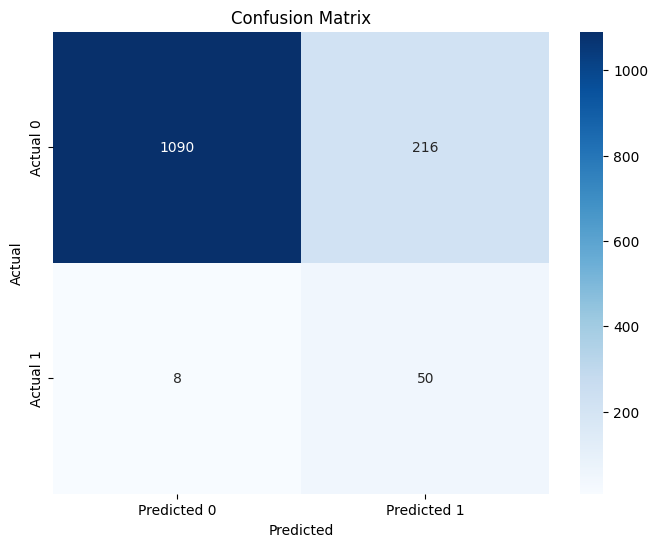

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1090 / 1306 = 83.46%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91      1306
           1       0.19      0.86      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.96      0.84      0.88      1364

FEA_EXT_DENSE_3Layers_128Size_0.15DO_1698266170
Epoch 1/200
34/34 [==============================] - 3s 57ms/step - loss: 0.4613 - accuracy: 0.8105 - val_loss: 0.3305 - val_accuracy: 0.8551
Epoch 2/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3288 - accuracy: 0.8631 - val_loss: 0.4552 - val_accuracy: 0.8089
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3067 - accuracy: 0.8702 - val_loss: 0.4807 - val_accuracy: 0.8051
Epoch 4/20

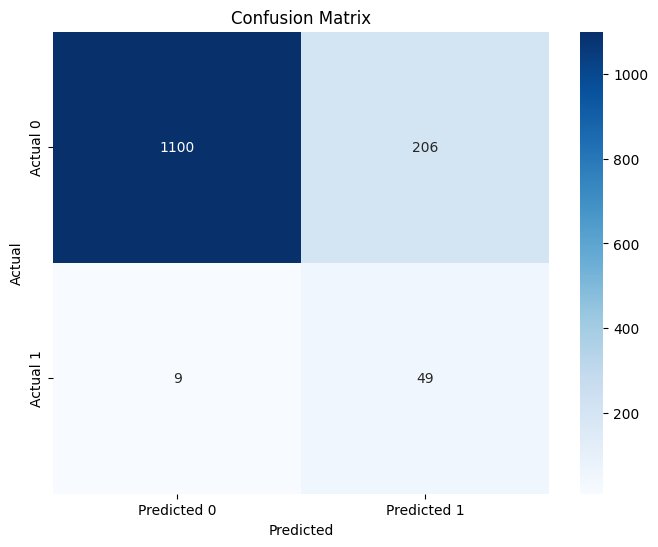

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1100 / 1306 = 84.23%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.19      0.84      0.31        58

    accuracy                           0.84      1364
   macro avg       0.59      0.84      0.61      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.1DO_1698266179
Epoch 1/200
34/34 [==============================] - 6s 65ms/step - loss: 0.4484 - accuracy: 0.8178 - val_loss: 0.3637 - val_accuracy: 0.8362
Epoch 2/200
34/34 [==============================] - 1s 19ms/step - loss: 0.3250 - accuracy: 0.8669 - val_loss: 0.4278 - val_accuracy: 0.8230
Epoch 3/200
34/34 [==============================] - 1s 18ms/step - loss: 0.3028 - accuracy: 0.8742 - val_loss: 0.4410 - val_accuracy: 0.8202
Epoch 4/200

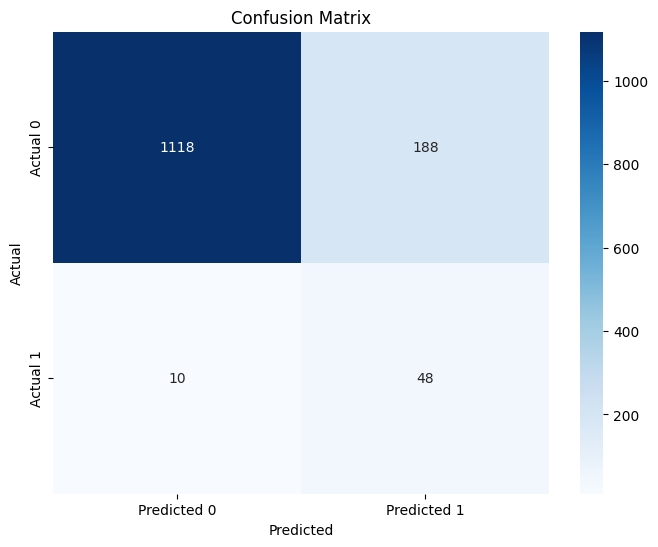

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1118 / 1306 = 85.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.20      0.83      0.33        58

    accuracy                           0.85      1364
   macro avg       0.60      0.84      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.2DO_1698266191
Epoch 1/200
34/34 [==============================] - 4s 67ms/step - loss: 0.4762 - accuracy: 0.7958 - val_loss: 0.2674 - val_accuracy: 0.9108
Epoch 2/200
34/34 [==============================] - 1s 21ms/step - loss: 0.3385 - accuracy: 0.8561 - val_loss: 0.4022 - val_accuracy: 0.8348
Epoch 3/200
34/34 [==============================] - 1s 20ms/step - loss: 0.3178 - accuracy: 0.8703 - val_loss: 0.4919 - val_accuracy: 0.8103
Epoch 4/200

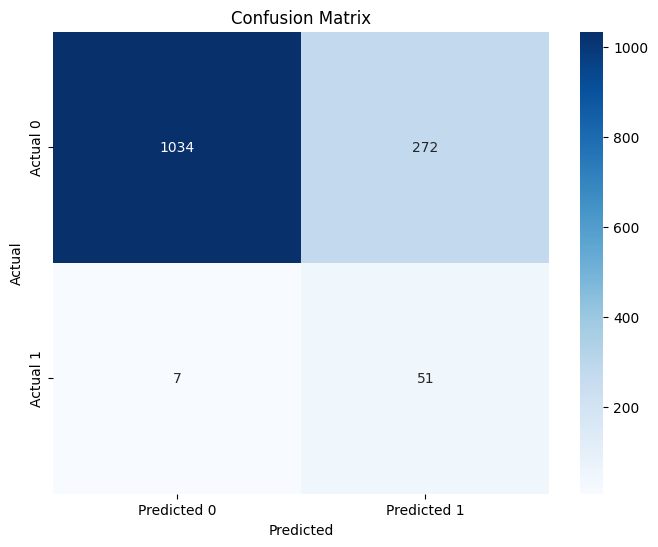

------------------------------
Percentage of positive (1) predicted correctly: 51 / 58 = 87.93%
Percentage of negative (0) predicted correctly: 1034 / 1306 = 79.17%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      1306
           1       0.16      0.88      0.27        58

    accuracy                           0.80      1364
   macro avg       0.58      0.84      0.57      1364
weighted avg       0.96      0.80      0.86      1364

FEA_EXT_DENSE_3Layers_128Size_0.15DO_1698266204
Epoch 1/200
34/34 [==============================] - 5s 74ms/step - loss: 0.4966 - accuracy: 0.7780 - val_loss: 0.3023 - val_accuracy: 0.8764
Epoch 2/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3365 - accuracy: 0.8670 - val_loss: 0.4318 - val_accuracy: 0.8249
Epoch 3/200
34/34 [==============================] - 1s 18ms/step - loss: 0.3188 - accuracy: 0.8749 - val_loss: 0.4393 - val_accuracy: 0.8301
Epoch 4/20

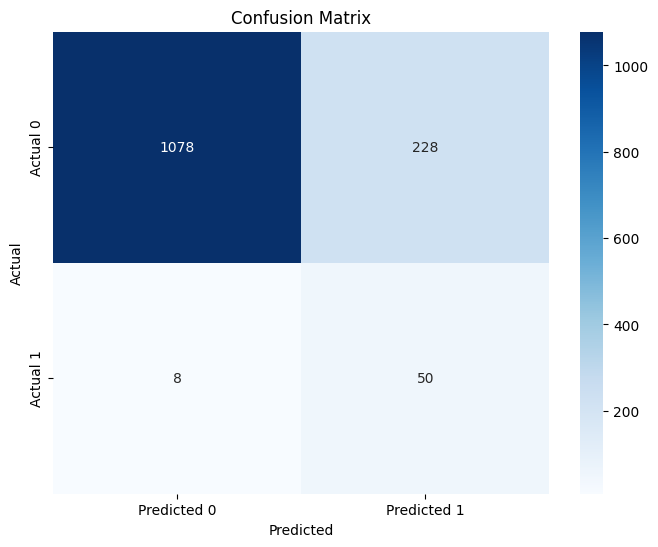

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1078 / 1306 = 82.54%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1306
           1       0.18      0.86      0.30        58

    accuracy                           0.83      1364
   macro avg       0.59      0.84      0.60      1364
weighted avg       0.96      0.83      0.88      1364

FEA_EXT_DENSE_3Layers_128Size_0.1DO_1698266214
Epoch 1/200
34/34 [==============================] - 5s 96ms/step - loss: 0.4381 - accuracy: 0.8253 - val_loss: 0.4156 - val_accuracy: 0.7961
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 0.3233 - accuracy: 0.8638 - val_loss: 0.4174 - val_accuracy: 0.8249
Epoch 3/200
34/34 [==============================] - 2s 74ms/step - loss: 0.3038 - accuracy: 0.8748 - val_loss: 0.4138 - val_accuracy: 0.8249
Epoch 4/200

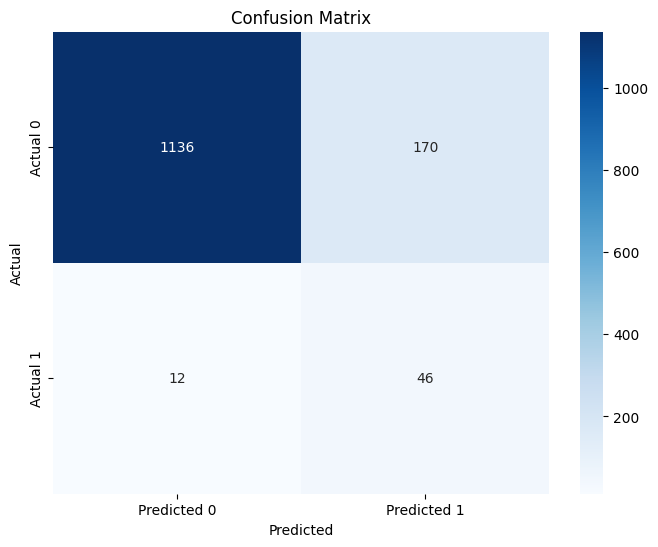

------------------------------
Percentage of positive (1) predicted correctly: 46 / 58 = 79.31%
Percentage of negative (0) predicted correctly: 1136 / 1306 = 86.98%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1306
           1       0.21      0.79      0.34        58

    accuracy                           0.87      1364
   macro avg       0.60      0.83      0.63      1364
weighted avg       0.96      0.87      0.90      1364

FEA_EXT_DENSE_3Layers_128Size_0.2DO_1698266228
Epoch 1/200


34/34 [==============================] - 7s 67ms/step - loss: 0.4980 - accuracy: 0.7942 - val_loss: 0.3538 - val_accuracy: 0.8443
Epoch 2/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3439 - accuracy: 0.8580 - val_loss: 0.3986 - val_accuracy: 0.8424
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3190 - accuracy: 0.8729 - val_loss: 0.4596 - val_accuracy: 0.8160
Epoch 4/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3081 - accuracy: 0.8704 - val_loss: 0.4170 - val_accuracy: 0.8476
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 0.2998 - accuracy: 0.8789 - val_loss: 0.4939 - val_accuracy: 0.8174
Epoch 5: early stopping
loaded
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_384 (Dense)           (None, 128)               1792      
                                                 

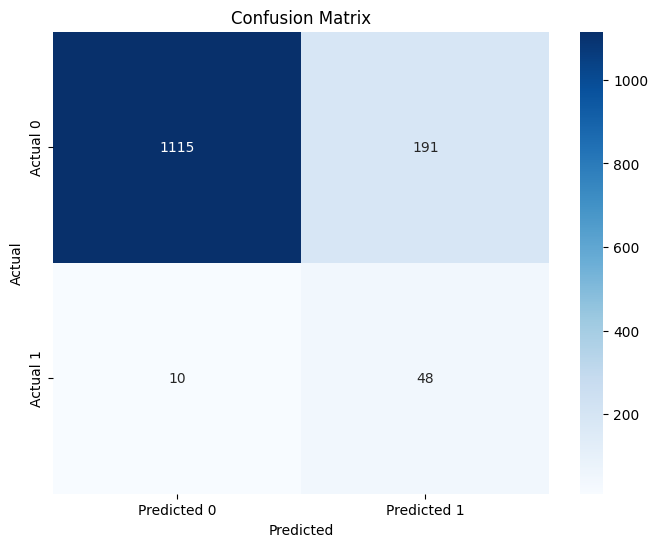

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1115 / 1306 = 85.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.83      0.32        58

    accuracy                           0.85      1364
   macro avg       0.60      0.84      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.15DO_1698266241
Epoch 1/200
34/34 [==============================] - 6s 72ms/step - loss: 0.4435 - accuracy: 0.8133 - val_loss: 0.3747 - val_accuracy: 0.8193
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.3278 - accuracy: 0.8643 - val_loss: 0.3782 - val_accuracy: 0.8462
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3120 - accuracy: 0.8683 - val_loss: 0.4593 - val_accuracy: 0.8235
Epoch 4/20

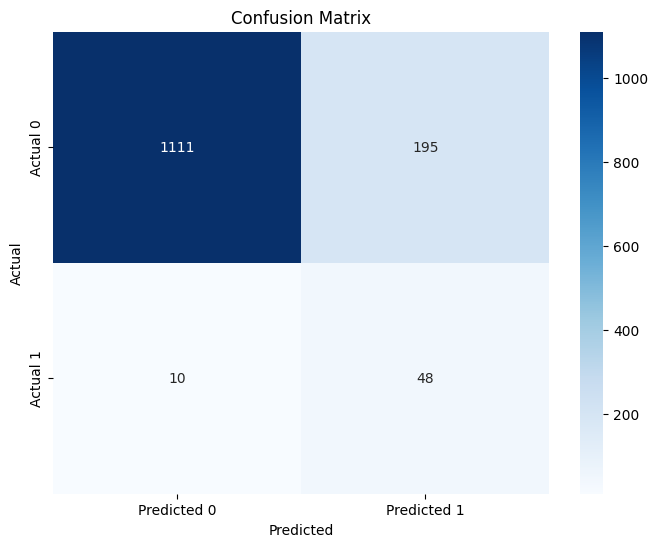

------------------------------
Percentage of positive (1) predicted correctly: 48 / 58 = 82.76%
Percentage of negative (0) predicted correctly: 1111 / 1306 = 85.07%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1306
           1       0.20      0.83      0.32        58

    accuracy                           0.85      1364
   macro avg       0.59      0.84      0.62      1364
weighted avg       0.96      0.85      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.1DO_1698266251
Epoch 1/200
34/34 [==============================] - 3s 53ms/step - loss: 0.4601 - accuracy: 0.7979 - val_loss: 0.3765 - val_accuracy: 0.8268
Epoch 2/200
34/34 [==============================] - 2s 64ms/step - loss: 0.3217 - accuracy: 0.8623 - val_loss: 0.3582 - val_accuracy: 0.8537
Epoch 3/200
34/34 [==============================] - 0s 13ms/step - loss: 0.3086 - accuracy: 0.8715 - val_loss: 0.4321 - val_accuracy: 0.8315
Epoch 4/200

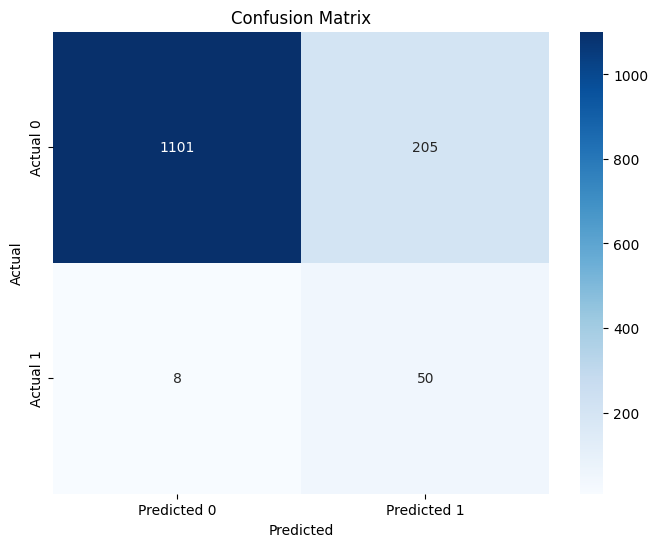

------------------------------
Percentage of positive (1) predicted correctly: 50 / 58 = 86.21%
Percentage of negative (0) predicted correctly: 1101 / 1306 = 84.30%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1306
           1       0.20      0.86      0.32        58

    accuracy                           0.84      1364
   macro avg       0.59      0.85      0.62      1364
weighted avg       0.96      0.84      0.89      1364

FEA_EXT_DENSE_3Layers_128Size_0.2DO_1698266260
Epoch 1/200
34/34 [==============================] - 4s 66ms/step - loss: 0.4744 - accuracy: 0.7910 - val_loss: 0.3949 - val_accuracy: 0.8084
Epoch 2/200
34/34 [==============================] - 2s 47ms/step - loss: 0.3376 - accuracy: 0.8592 - val_loss: 0.3915 - val_accuracy: 0.8410
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 0.3127 - accuracy: 0.8715 - val_loss: 0.4097 - val_accuracy: 0.8480
Epoch 4/200

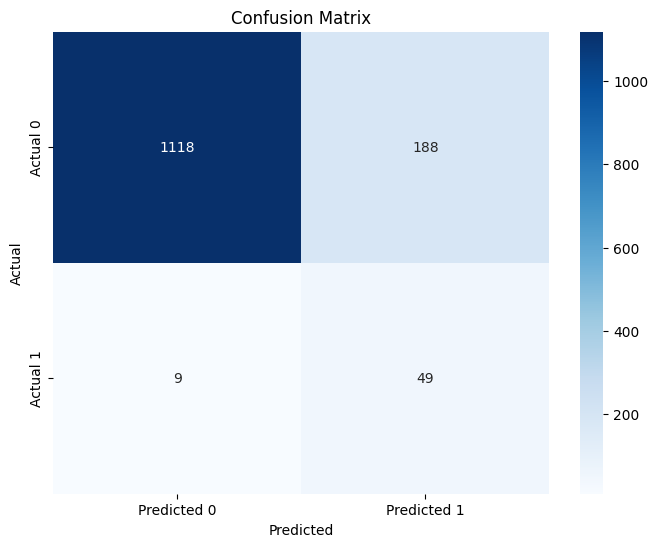

------------------------------
Percentage of positive (1) predicted correctly: 49 / 58 = 84.48%
Percentage of negative (0) predicted correctly: 1118 / 1306 = 85.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1306
           1       0.21      0.84      0.33        58

    accuracy                           0.86      1364
   macro avg       0.60      0.85      0.63      1364
weighted avg       0.96      0.86      0.89      1364



In [ ]:
from itertools import permutations

# Defining hyperparameters that we want to try combinations off
dense_layers = [2,3]
layer_sizes = [32,64,96,128]
DOs = [0.15,0.1,0.2]

# tracking max weighted accuracy by using our previsously defined test_model functions
max = 0
for dense_layer in dense_layers:
    for perm in permutations(layer_sizes, dense_layer):
        for DO in DOs:
            list_perm = list(perm)
            layer_size=list_perm[0]

            # Creating a unique model name using time.tinm()
            NAME = f"FEA_EXT_DENSE_{dense_layer}Layers_{layer_size}Size_{DO}DO_{int(time.time())}"
            print(NAME)

            # Creating each model based on the iterations loops
            model = Sequential()

            model.add(Dense(layer_size, input_shape=(X_selected.shape[1],)))
            model.add(Dropout(DO))

            model.add(Activation('relu'))

            for i in range(1,len(list_perm)):
                model.add(Dense(list_perm[i]))
                model.add(Activation('relu'))
                model.add(Dropout(DO))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
            model_checkpoint = ModelCheckpoint(NAME, save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

            model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

            model.fit(X_selected, y_adasyn,
                      batch_size=256,
                      epochs=200,
                      validation_split=0.2,
                      callbacks=[es,model_checkpoint])
            model.load_weights(f'/content/{NAME}')
            print("loaded")
            print(model.summary())
            acc_val = test_model_selected_features(model, feature_selection_KBest)

            # upadating max and best_model_manual to store the best model found so far
            if (acc_val>max):
              max=acc_val
              best_model_manual = model

43/43 [==============================] - 0s 3ms/step - loss: 0.4046 - accuracy: 0.8336
------------------------------
Test loss: 0.4046
Test accuracy: 0.8336
43/43 [==============================] - 0s 3ms/step
------------------------------


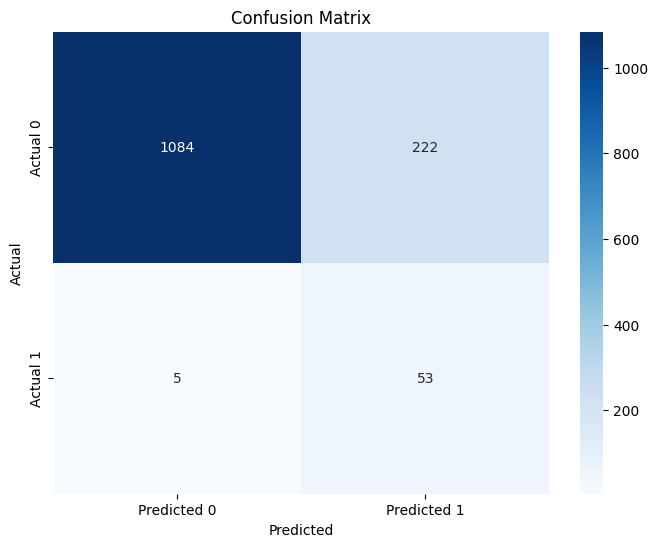

------------------------------
Percentage of positive (1) predicted correctly: 53 / 58 = 91.38%
Percentage of negative (0) predicted correctly: 1084 / 1306 = 83.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91      1306
           1       0.19      0.91      0.32        58

    accuracy                           0.83      1364
   macro avg       0.59      0.87      0.61      1364
weighted avg       0.96      0.83      0.88      1364



0.8719042086919787

In [ ]:
test_model_selected_features(best_model_manual, feature_selection_KBest)

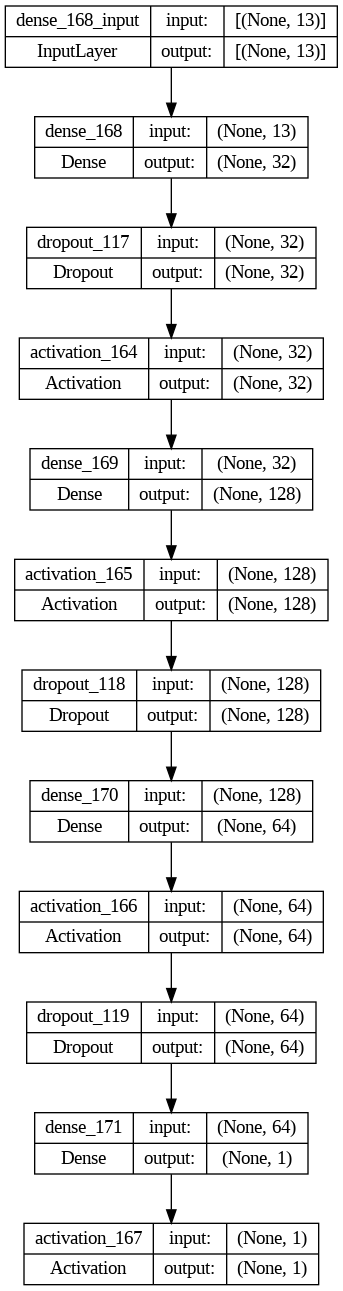

In [ ]:
plot_model(best_model_manual, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

As you can see, hyper parameter tuning manually gives us more control over which values we select as well as how the models performance is evaluated.

We also trained many more models than the keras tuner.

Hence the manualy hyper parameter tuned model performs better than both our arbitarily selected and keras tuned models.

# Pickling and saving all the models

The values of the models will change every time that they are re-trained. This is due to the random initialization of the values of the neurons.
Hence to save the current models for future verification we can pickle and save them and load them later on.

In [ ]:
import pickle

### Saving the models

#### only_scaled_model

In [ ]:
with open('/content/pkls/only_scaled_model.pkl', 'wb') as model_file:
    pickle.dump(only_scaled_model, model_file)

#### smote_model

In [ ]:
with open('/content/pkls/smote_model.pkl', 'wb') as model_file:
    pickle.dump(smote_model, model_file)

#### randomOver_model

In [ ]:
with open('/content/pkls/randomOver_model.pkl', 'wb') as model_file:
    pickle.dump(randomOver_model, model_file)

#### adasyn_model

In [ ]:
with open('/content/pkls/adasyn_model.pkl', 'wb') as model_file:
    pickle.dump(adasyn_model, model_file)

#### randomUnder_model

In [ ]:
with open('/content/pkls/randomUnder_model.pkl', 'wb') as model_file:
    pickle.dump(randomUnder_model, model_file)

#### enn_model

In [ ]:
with open('/content/pkls/enn_model.pkl', 'wb') as model_file:
    pickle.dump(enn_model, model_file)

#### adasyn_and_fs_model

In [ ]:
with open('/content/pkls/adasyn_and_fs_model.pkl', 'wb') as model_file:
    pickle.dump(adasyn_and_fs_model, model_file)

#### best_model_tuned

In [ ]:
with open('/content/pkls/best_model_tuned.pkl', 'wb') as model_file:
    pickle.dump(best_model_tuned, model_file)

#### best_model_manual

In [ ]:
with open('/content/pkls/best_model_manual.pkl', 'wb') as model_file:
    pickle.dump(best_model_manual, model_file)


### Saving the split dataset

We will also be saving the data split of X and y as that is also randomly shuffled. So when the code is re run that may change as well

In [ ]:
with open('/content/pkls/X.pkl', 'wb') as pkl_file:
    pickle.dump(X, pkl_file)
with open('/content/pkls/y.pkl', 'wb') as pkl_file:
    pickle.dump(y, pkl_file)
with open('/content/pkls/X_test.pkl', 'wb') as pkl_file:
    pickle.dump(X_test, pkl_file)
with open('/content/pkls/y_test.pkl', 'wb') as pkl_file:
    pickle.dump(y_test, pkl_file)

### Loading the models

Now to load any of the models or data you can simply use the following code

In [ ]:
PATH_TO_MODEL = 'PATH_TO_MODEL'
with open('PATH_TO_MODEL', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

You can now use this model for predictions or testing